# HR-аналитика

## Цель проекта

Смоделировать уровень удовлетворённости и предсказать увольнение сотрудников, чтобы помочь HR-отделу компании спрогнозировать текучку кадров.

## Задачи проекта

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Это важно для бизнеса, потому что удовлетворённость работой напрямую влияет на отток сотрудников.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

## Описание данных

Исходные данные содержат характеристики сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Данные содержатся в 5 файлах:
- Данные для задачи предсказания уровня удовлетворённости сотрудника:
    - `train_job_satisfaction_rate.csv` — тренировочная выборка;
    - `test_features.csv` — входные признаки тестовой выборки;
    - `test_target_job_satisfaction_rate.csv` —  целевой признак тестовой выборки.
- Данные для задачи предсказания увольнения сотрудника из компании:
    - `train_quit.csv` — тренировочная выборка;
    - `test_target_quit.csv` — целевой признак тестовой выборки.
    - входные признаки тестовой выборки те же, что и в задаче предсказания уровня удовлетворённости сотрудника.

Признаки в данных:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании (целевой признак в задаче предсказания уровня удовлетворённости сотрудника);
- `quit` — увольнение сотрудника из компании (целевой признак в задаче предсказания увольнения сотрудника из компании).

## Установка и обновление библиотек

In [1]:
# обновляем версии библиотек
%pip install scikit-learn==1.2.0 seaborn==0.11.2 matplotlib==3.5.0 -q

# устанавливаем дополнительные библиотеки
%pip install phik shap optuna-integration[sklearn] -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Импорты

In [2]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
import scipy.stats as st

# для подсчёта времени вычислений
from time import time

# для расчёта корреляции Фи
import phik

from sklearn.model_selection import (
    cross_val_score,  # для оценки метрики при кросс-валидации
    GridSearchCV  # для подбора гиперпараметров моделей
)

# для подготовки данных
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    RobustScaler,
    MinMaxScaler,
    LabelEncoder
)

# для отбора признаков
from sklearn.feature_selection import (
    SelectKBest,
    f_regression, 
    f_classif 
)

# классы моделей
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

# для построения пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# для оценки качества моделей
from sklearn.metrics import (
    make_scorer,
    roc_auc_score, 
    confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score, 
    RocCurveDisplay
)
# для оценки важности признаков
from sklearn.inspection import permutation_importance
import shap

# Optuna
from optuna.integration import OptunaSearchCV
from optuna import distributions
import optuna.logging
from optuna.exceptions import ExperimentalWarning

## Настройки

In [3]:
# фиксируем случайное состояние для воспроизводимости результатов
RANDOM_STATE = 42

In [4]:
# отображать таблицы pandas полностью
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
# Настройки Optuna

# скрыть предупреждения об экспериментальном статусе
warnings.filterwarnings('ignore', category=ExperimentalWarning)

# скрыть вывод optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# показать вывод optuna
# optuna.logging.set_verbosity(optuna.logging.INFO)

## Пользовательские функции

In [6]:
def list_unique_values(data, columns=None, show_counts=False):
    """
    Для каждого из указанных столбцов таблицы выводит 
    отсортированный список уникальных значений в этом столбце.
    """
    # если не указаны столбцы, выбираем все
    if columns is None:
        columns = data.columns
    
    # если указан один столбец, преобразуем в список
    if isinstance(columns, str):
        columns = [columns]

    # выводим список уникальных значений в каждом из выбранных столбцов
    for col in columns:
        try:
            if show_counts:
                print(f'Уникальные значения в столбце \'{col}\' и их количество:')
                print_data = data[col].value_counts(sort=False, dropna=False).sort_index()
                if print_data.index.is_object():
                    print_data.index = print_data.index.map("'{}'".format, na_action='ignore')
                print(print_data.to_string())
            else:
                print(f'Уникальные значения в столбце \'{col}\':\n'
                      f'{data[col].sort_values().unique().tolist()}')
        except:
            print(f'Столбца {col} не существует.')
        print()

In [7]:
def stat_plots(data, column: str, target: str = None):
    """
    Строит графики, характеризующие признак:
    - гистограмму распределения и диаграмму размаха для количественных признаков,
    - столбчатую диаграмму и круговую диаграмму для категориальных признаков,
    с опциональной разбивкой по целевому признаку.
    """
    # если нет такого столбца
    if column not in data.columns:
        print(f"В таблице отсутствует столбец '{column}'")
        return None

    # если признак совпадает с целевым
    if target == column:
        target = None
    
    # если признак количественный
    if data[column].dtype in ['int64', 'float64']:
        # если признак дискретный
        if data[column].dtype == 'int64' and data[column].nunique() <= 30:
            discrete = True
            kde = False
        else:
            discrete = False
            kde = True
            
        # создаём область построения графиков
        nrows = 2 if target is not None else 1
        fig, axes = plt.subplots(
            nrows=nrows, 
            ncols=2, 
            figsize=(10, nrows*4), 
            constrained_layout=True, 
            squeeze=False
        )
        
        # строим гистограмму распределения
        sns.histplot(
            data=data, 
            x=column, 
            discrete=discrete, 
            kde=kde, 
            stat='count', 
            ax=axes[0, 0]
        )
        # добавляем линии: среднее и медиана
        axes[0, 0].axvline(
            x=data[column].mean(), 
            color='red', 
            label='Среднее'
        )
        axes[0, 0].axvline(
            x=data[column].median(), 
            color='red', 
            label='Медиана', 
            linestyle='--'
        )
        
        axes[0, 0].legend()
        axes[0, 0].set_xlabel('Значение признака ' + column)
        axes[0, 0].set_ylabel('Количество объектов')
        axes[0, 0].set_title('Гистограмма распределения признака ' + column)
        
        # строим диаграмму размаха
        sns.boxplot(
            data=data, 
            x=column, 
            ax=axes[0, 1]
        )
        axes[0, 1].set_yticklabels([])
        axes[0, 1].set_xlabel('Значение признака ' + column)
        axes[0, 1].set_title('Диаграмма размаха признака ' + column)
       
        # если задан целевой признак
        if target is not None:
            # строим гистограмму распределения
            sns.histplot(
                data=data, 
                x=column, 
                hue=target, 
                discrete=discrete, 
                kde=kde, 
                stat='probability', 
                common_norm=False, 
                ax=axes[1, 0]
            )
            axes[1, 0].set_xlabel('Значение признака ' + column)
            axes[1, 0].set_ylabel('Доля объектов')
            axes[1, 0].set_title('Гистограмма распределения (с разбивкой)')
            
            
            # добавляем линии: среднее и медиана
            colors = colormaps['tab10'].colors
            line_labels = []
            line_handles = []
            for u, color in zip(data[target].unique(), colors):
                vl1 = axes[1, 0].axvline(
                    x=data.loc[data[target] == u, column].mean(), 
                    color=color, 
                    linestyle='-',
                )
                line_labels.append('Среднее ({}: {})'.format(target, str(u)))
                line_handles.append(vl1)
                vl2 = axes[1, 0].axvline(
                    x=data.loc[data[target] == u, column].median(), 
                    color=color, 
                    linestyle='--',
                )
                line_labels.append('Медиана ({}: {})'.format(target, str(u)))
                line_handles.append(vl2)
            
            # добавляем легенду
            handles = axes[1, 0].get_legend().legendHandles
            labels = data[target].unique().tolist()
            axes[1, 0].legend(
                handles=handles+line_handles, 
                labels=labels+line_labels,
                title=target,
            )
            sns.move_legend(
                axes[1, 0], 'lower center',
                ncol=3,
                bbox_to_anchor=(0.5, 1.1)
            )
            
            # строим диаграмму размаха
            sns.boxplot(
                data=data, 
                x=column, 
                y=target, 
                ax=axes[1, 1]
            )
            axes[1, 1].set_xlabel('Значение признака ' + column)
            axes[1, 1].set_ylabel('Значение признака ' + target)
            axes[1, 1].set_title('Диаграмма размаха (с разбивкой)')
        
        # если признак дискретный, то делаем метки на оси с шагом 1
        if discrete:
            x_min, x_max = data[column].agg(['min', 'max']).tolist()
            for ax in axes.flatten():
                ax.set_xticks(range(x_min, x_max+1))
                
    # если признак категориальный
    elif data[column].dtype in ['object', 'category']:
        # заполняем пропуски строковым значением 'NaN'
        data = data.copy()
        data = data.fillna('NaN')
        
        # данные для построения столбчатой диаграммы
        plot_data_ = (
            data
            .pivot_table(
                index=column,
                columns=target, 
                values=data.columns.drop([column, target], errors='ignore')[0], 
                aggfunc='count'
            )
        )
        # сортируем столбцы в сводной таблице
        plot_data_ = plot_data_.loc[:, plot_data_.columns.sort_values(ascending=False)]

        # если задан целевой признак и у него больше одного уникального значения
        if target is not None and data[target].nunique() > 1:
            uniq = data[target].unique()
        else:
            uniq = []
        # задаём размер область построения графиков
        nrows = 1 + (len(uniq) + 1) // 2    
        
        # если слишком длинные значения признака, то поворачиваем подписи
        # и увеличиваем высоту диаграммы
        if plot_data_.index.astype('str').str.len().max() > 20: 
            angle = 90
            figwidth = 14
            figheight = nrows*6
        else:
            angle = 0
            figwidth = 10
            figheight = nrows*4

        # создаём область построения графиков
        fig, axes = plt.subplots(
            nrows=nrows, 
            ncols=2, 
            figsize=(figwidth, figheight), 
            constrained_layout=True, 
            squeeze=False
        )
        
        # строим столбчатую диаграмму
        plot_data_.plot(
            kind='bar', 
            rot=angle, 
            stacked=True, 
            ax=axes[0, 0]
        )
        axes[0, 0].set_xlabel('Значение признака ' + column)
        axes[0, 0].set_ylabel('Количество объектов')
        axes[0, 0].set_title('Распределение по значениям признака ' + column)

        # добавляем аннотации и настраиваем легенду по разному, 
        # если указан целевой признак или если не указан
        if target is not None:
            # переводим количество в проценты
            percents = plot_data_.transform(lambda x: x / x.sum() * 100, axis=1)
            # добавляем метки со значениями и процентами на график
            for c, col in zip(axes[0, 0].containers, plot_data_.columns):
                vals = percents[col]
                labels = [
                    f'{v.get_height():.0f}\n({val:.1f}%)' if v.get_height() > 0 
                    else '' for v, val in zip(c, vals)
                ]
                axes[0, 0].bar_label(c, labels=labels, label_type='center')
        else:
            # добавляем метки со значениями на график
            for c in axes[0, 0].containers:
                labels = [
                    f'{v.get_height():.0f}' if v.get_height() > 0 
                    else '' for v in c
                ]
                axes[0, 0].bar_label(c, labels=labels, label_type='center')
            # удаляем легенду
            axes[0, 0].get_legend().remove()
            
        # данные для построения круговых диаграмм
        plot_data = [data[column].value_counts()]  
        # добавляем данные с разбивкой по значению целевого признака
        for u in uniq:
            p_d = (
                data
                .loc[data[target] == u, column]
                .value_counts()
            )
            order = plot_data[0].index.intersection(p_d.index)
            plot_data.append(p_d.loc[order])

        # названия круговых диаграмм
        titles = (
            [''] + 
            ['\nв подмножестве со значением признака\n' + target + ' = ' + str(u) for u in uniq]
        )
        for i, p_d in enumerate(plot_data):
            # индексы области построения
            r = (i + 1) // 2
            c = (i + 1) % 2
            # строим круговую диаграмму
            p_d.plot(
                kind='pie', 
                startangle=0, 
                autopct='%.1f%%', 
                pctdistance=0.8,
                ax=axes[r, c]
            )
            axes[r, c].set_ylabel('')
            axes[r, c].set_title('Доля значений признака ' + column + titles[i])
            
    else:
        print('Неподходящий тип данных аргумента.')

    # заголовок
    fig.suptitle('Признак: ' + column)
    
    return fig, axes

In [8]:
def corr_matrix(data, features=None, method='pearson', interval_cols=None):
    """
    Выводит матрицу корреляции количественных признаков features в данных data
    в виде тепловой карты.
    Дополнительный параметр:
    method - метод расчёта корреляции, по умолчанию 'pearson':
        'pearson' - корреляция Пирсона, 
        'spearman' - корреляция Спирмена,
        'kendall' - корреляция Кендалла,
        'phik' - корреляция фи.
    """
    if method == 'pearson':
        method_name = 'Пирсона'
    elif method == 'spearman':
        method_name = 'Спирмена'
    elif method == 'kendall':
        method_name = 'Кендалла'
    elif method == 'phik':
        method_name = '$\phi_k$'
    else:
        print('Неправильно указан метод расчёта корреляций.')
        return None

    if features is None:
        features = data.columns
         
    # расчёт матрицы корреляции
    if method in [ 'pearson', 'spearman', 'kendall']:
        corr_data = data[features].corr(method=method)
        vmin = -1
        vmax = 1
        center = 0
        cmap='bwr'
    elif method == 'phik':
        corr_data = data[features].phik_matrix(interval_cols=interval_cols)
        vmin = 0
        vmax = 1
        center = 0.5
        cmap='Greens'
    
    # строим тепловую карту по матрице корреляции
    ax = sns.heatmap(corr_data, 
                     annot=True,
                     fmt='.2f',
                     square=True,
                     cmap=cmap, 
                     vmin=vmin,
                     vmax=vmax,
                     center=center,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Коэффициенты корреляции {method_name}')

    return ax

In [9]:
def hypothesis_test(result, alpha):
    """
    По заданным аргументам - результату t-теста и уровню статистической значимости 
    выводит результат проверки гипотезы: отвергнуть нулевую гипотезу или нет.
    """
    print(f'Статистика разности (t-statistic): {result.statistic:.2f}')
    print(f'P-value: {result.pvalue:.4g}')
    print('Уровень статистической значимости:', alpha)
    # проверяем p-value
    if result.pvalue < alpha:
        print(f'P-value < {alpha}. Отвергаем нулевую гипотезу.')
    else:
        print(f'P-value ≥ {alpha}. Нельзя отвергнуть нулевую гипотезу.')

In [10]:
def plot_residuals(y_test, y_pred):
    """
    Строит графики для визуального анализа остатков:
    - гистограмму распределения остатков,
    - диаграмму рассеяния остатков и предсказаний модели.
    """
    # остатки модели
    residuals = y_test - y_pred
    # среднее значение остатков
    residuals_mean = residuals.mean()

    # создаём область построения графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)
    
    # строим гистограмму распределения остатков
    sns.histplot(x=residuals, ax=axes[0], kde=True)
    axes[0].axvline(x=residuals_mean, color='red', label='Среднее значение:\n'+str(residuals_mean.round(4)))
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество')
    axes[0].legend()
    
    # строим диаграмму рассеяния остатков и предсказаний модели
    sns.residplot(x=y_pred, y=residuals, ax=axes[1], lowess=True, line_kws=dict(color="r"))
    axes[1].set_xlim(axes[1].get_xlim() * np.array([0.99, 1.01]))
    axes[1].set_title('Анализ разброса остатков')
    axes[1].set_title('Анализ разброса остатков')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    
    # заголовок
    fig.suptitle('Анализ остатков')

    return fig, axes

In [11]:
def plot_feature_importance(importance, feature_names):
    """
    Строит график важности признаков.
    """
    # формируем таблицу
    feature_df = (
        pd.DataFrame({'признак': feature_names, 'значение': importance})
        .sort_values(by='значение', key=lambda x: abs(x), ascending=False)
        .reset_index(drop=True)
    )
    # визуализируем данные в таблице
    sns.barplot(data=feature_df, x='значение', y='признак')

In [12]:
def get_features_lists(pipe):
    """
    Выводит списки признаков, используемых и неиспользуемых моделью в пайплайне.
    """
    # названия входных признаков после подготовки данных
    all_features = pipe['preprocessor'].get_feature_names_out()
    # получаем индексы отобранных признаков
    mask = pipe['feature_selector'].get_support()
    # получаем названия отобранных признаков
    used_features = all_features[mask].tolist()
    # получаем названия отсеянных признаков
    # как разность множеств признаков
    unused_features = list(set(all_features) - set(used_features))
    
    print('Используемые входные признаки:', used_features)
    print('Неиспользуемые входные признаки:', unused_features)

    return used_features, unused_features

In [13]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Строит матрицу ошибок модели классификации.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.xlabel('Предсказанное значение')
    plt.ylabel('Истинное значение')
    plt.title('Матрица ошибок модели')

## Задача 1: Предсказание уровня удовлетворённости сотрудника

### Загрузка и обзор данных

#### Загрузка данных

In [ ]:
# путь к файлам по умолчанию
path_default = '/datasets/'
# путь к файлам на локальном компьютере
path_local_rel = '~/datasets/'
path_local = os.path.expanduser(path_local_rel)
# путь к файлам на внешнем сервере
path_remote = 'https://<LINK_REMOVED>/datasets/'

# определение расположения файлов
if os.path.exists(path_default):
    path = path_default
elif os.path.exists(path_local):
    path = path_local
else:
    path = path_remote
    
# загрузка данных из CSV файлов
df_train_jsr = pd.read_csv(path + 'train_job_satisfaction_rate.csv')
X_test = pd.read_csv(path + 'test_features.csv')
y_test_jsr = pd.read_csv(path + 'test_target_job_satisfaction_rate.csv')

#### Знакомство с данными

Создадим словарь, который будет содержать названия и описания загруженных датасетов.

In [15]:
# словарь с названиями и описаниями датасетов
df_dict = {
    'df_train_jsr': 'Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника',
    'X_test': 'Входные признаки тестовой выборки',
    'y_test_jsr': 'Целевой признак тестовой выборки в задаче предсказания уровня удовлетворённости сотрудника',
}

In [16]:
for df_name in ['df_train_jsr', 'X_test', 'y_test_jsr']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # первые 5 строк таблицы
    display(eval(df_name).head())
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20


Входные признаки тестовой выборки (X_test):


id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800


Целевой признак тестовой выборки в задаче предсказания уровня удовлетворённости сотрудника (y_test_jsr):


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [17]:
for df_name in ['df_train_jsr', 'X_test', 'y_test_jsr']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # общая информация о таблице
    print(eval(df_name).info())
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None

Входные признаки тестовой выборки (X_test):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entr

#### Выводы

- Тренировочная выборка содержит 4000 записей, тестовая — 2000.
- Типы данных и масштабы значений соответствуют описанию данных.
- В тренировочной и тестовой выборках имеются пропущенные значения входных признаков.

### Предобработка данных

#### Обработка пропусков

In [18]:
for df_name in ['df_train_jsr', 'X_test', 'y_test_jsr']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # количество пропусков в столбцах таблицы
    print(eval(df_name).isna().sum())
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Входные признаки тестовой выборки (X_test):
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Целевой признак тестовой выборки в задаче предсказания уровня удовлетворённости сотрудника (y_test_jsr):
id                       0
job_satisfaction_rate    0
dtype: int64



И в тренировочной, и в тестовой выборке присутствуют пропущенные значения категориальных входных признаков `dept` и `level`.
Обнаруженные пропуски разумно заполнить наиболее часто встречающимся значением ("most_frequent") соответствующего признака. Это будет сделано далее в пайплайне при подготовке данных для обучения ML моделей.

#### Обработка дубликатов

Посмотрим количество уникальных значений в столбцах таблиц (с учётом `NaN`).

In [19]:
for df_name in ['df_train_jsr', 'X_test', 'y_test_jsr']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    print('Количество уникальных значений в столбцах:')
    # количество уникальных значений в столбцах таблицы
    print(eval(df_name).nunique(dropna=False))
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):
Количество уникальных значений в столбцах:
id                       4000
dept                        6
level                       4
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     68
job_satisfaction_rate      98
dtype: int64

Входные признаки тестовой выборки (X_test):
Количество уникальных значений в столбцах:
id                       2000
dept                        7
level                       4
workload                    4
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     66
dtype: int64

Целевой признак тестовой выборки в задаче предсказания уровня удовлетворённости сотрудника (y_test_jsr):
Количество уникальных значений в столбцах:
id                       200

Количество уникальных значений в столбце `id` во всех таблицах совпадает с количеством записей в них. Это означает, что дубликаты записей в данных отсутствуют.

Для проверки данных на неявные пропуски и неявные дубликаты значений исследуем уникальные значения категориальных признаков. Также проверим количественные признаки, число уникальных значений которых невелико.

In [20]:
for df_name in ['df_train_jsr', 'X_test']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # уникальные значения в столбцах таблицы
    list_unique_values(
        eval(df_name).drop(columns=['id', 'salary', 'job_satisfaction_rate'], errors='ignore'),
        show_counts=False
    )
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):
Уникальные значения в столбце 'dept':
['hr', 'marketing', 'purchasing', 'sales', 'technology', nan]

Уникальные значения в столбце 'level':
['junior', 'middle', 'sinior', nan]

Уникальные значения в столбце 'workload':
['high', 'low', 'medium']

Уникальные значения в столбце 'employment_years':
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Уникальные значения в столбце 'last_year_promo':
['no', 'yes']

Уникальные значения в столбце 'last_year_violations':
['no', 'yes']

Уникальные значения в столбце 'supervisor_evaluation':
[1, 2, 3, 4, 5]


Входные признаки тестовой выборки (X_test):
Уникальные значения в столбце 'dept':
[' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology', nan]

Уникальные значения в столбце 'level':
['junior', 'middle', 'sinior', nan]

Уникальные значения в столбце 'workload':
[' ', 'high', 'low', 'medium']

Уникальные значения в столбце 'employment_years':
[1, 2, 3, 4, 5, 6, 

В столбце `level` таблиц `df_train_jsr` и `X_test` допущена опечатка в значении `'senior'` ("i" вместо "e"). Исправим её.

In [21]:
# заменяем 'sinior' на 'senior' в столбце 'level'
for df in [df_train_jsr, X_test]:
    df['level'] = df['level'].replace('sinior', 'senior')

Проверим корректность результата.

In [22]:
for df_name in ['df_train_jsr', 'X_test']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # уникальные значения в столбцах таблицы
    list_unique_values(eval(df_name), 'level')
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):
Уникальные значения в столбце 'level':
['junior', 'middle', 'senior', nan]


Входные признаки тестовой выборки (X_test):
Уникальные значения в столбце 'level':
['junior', 'middle', 'senior', nan]




В тестовой выборке в столбцах `dept` и `workload` есть неявные пропуски (пробел вместо значения). Заменим их на явные — `NaN`.

In [23]:
# заменяем пробел на NaN
for col in ['dept', 'workload']:
    X_test[col] = X_test[col].replace(' ', np.nan)

Проверим корректность результата.

In [24]:
# название таблицы
print(f"{df_dict['X_test']} (X_test):")
# уникальные значения в столбцах таблицы
list_unique_values(X_test, ['dept', 'workload'], show_counts=True)

Входные признаки тестовой выборки (X_test):
Уникальные значения в столбце 'dept' и их количество:
'hr'            227
'marketing'     279
'purchasing'    273
'sales'         763
'technology'    455
NaN               3

Уникальные значения в столбце 'workload' и их количество:
'high'       363
'low'        593
'medium'    1043
NaN            1



#### Задание индексов и сортировка записей

Чтобы избежать возможных проблем при преобразованиях датафреймов Pandas в массивы Numpy и обратно в процессе обработки данных в пайплайне для обучения ML моделей, упорядочим записи в датафреймах по `id`, установив его в качестве индекса.

In [25]:
# устанавливаем столбец 'id' в качестве индекса
# и сортируем по индексу
df_train_jsr, X_test, y_test_jsr = [
    df.set_index('id').sort_index() for df in [df_train_jsr, X_test, y_test_jsr]
]

In [26]:
# проверяем результат
for df_name in ['df_train_jsr', 'X_test', 'y_test_jsr']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # первые 5 строк таблицы
    display(eval(df_name).head())
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):


dept   level workload  employment_years last_year_promo  \
id                                                                      
100954  purchasing  junior      low                 1              no   
101057       sales  junior      low                 1              no   
101074       sales  junior   medium                 2              no   
101081       sales  middle      low                 2              no   
101129  technology  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
100954                   no                      4   15600   
101057                  yes                      4   19200   
101074                   no                      2   20400   
101081                   no                      4   28800   
101129                   no                      4   34800   

        job_satisfaction_rate  
id                             
100954                   0.60  
101057                   0.45  
101074                   0.36  
101081                   0.66  
101129                   0.71


Входные признаки тестовой выборки (X_test):


dept   level workload  employment_years last_year_promo  \
id                                                                      
100298          hr  junior      low                 2              no   
100480   marketing  junior      low                 4              no   
100503  purchasing  middle     high                 5              no   
100610       sales  middle   medium                 5              no   
100692       sales  middle     high                 6              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
100298                   no                      4   19200  
100480                   no                      4   16800  
100503                   no                      4   55200  
100610                   no                      4   43200  
100692                   no                      4   48000


Целевой признак тестовой выборки в задаче предсказания уровня удовлетворённости сотрудника (y_test_jsr):


job_satisfaction_rate
id                           
100298                   0.80
100480                   0.84
100503                   0.79
100610                   0.75
100692                   0.69

#### Проверка согласованности данных

Убедимся, что множество id в данных с входными признаками в тестовой выборке совпадает с множеством id в данных с целевым признаком в тестовой выборке.

In [27]:
# проверяем совпадение множеств id в двух таблицах
set(X_test.index) == set(y_test_jsr.index)

True

Также убедимся, что тренировочная и тестовая выборка не содержат одинаковых id.

In [28]:
# проверяем, что пересечение множеств - пустое
set(df_train_jsr.index) & set(X_test.index) == set()

True

#### Выводы

В результате предобработки данных:
- В тренировочной и в тестовой выборке обнаружены пропущенные значения категориальных входных признаков `dept` и `level`. Обнаруженные пропуски разумно заполнить наиболее часто встречающимся значением ("most_frequent") соответствующего признака. Это будет сделано далее в пайплайне при подготовке данных для обучения ML моделей.
- В тестовой выборке в значениях входных признаков `dept` и `workload` неявные пропуски (пробел вместо значения) заменены на явные — `NaN`.
- И в тренировочной, и в тестовой выборке в столбце `level` исправлена опечатка в значении `'senior'` ("i" вместо "e").
- Дубликаты записей в тренировочной и в тестовой выборке не обнаружены.
- Уникальный идентификатор сотрудника `id` задан в качестве индекса в таблицах. Записи в таблицах упорядочены по индексу — `id`, чтобы избежать проблем при преобразованиях датафреймов Pandas в массивы Numpy и обратно.
- Проверена корректность разделения данных на выборки:
    - для тестовой выборки множество id в данных с входными признаками совпадает с множеством id в данных с целевым признаком,
    - тренировочная и тестовая выборка не содержат одинаковых id.

### Исследовательский анализ данных

#### Объединение данных

Объединим датасеты в одну таблицу, пометив соответствующим образом тренировочные и тестовые данные. Это позволит исследовать схожесть распределений значений признаков в тренировочной и в тестовой выборке.

In [ ]:
# объединяем таблицы
df_jsr = pd.concat([
    # помечаем тренировочную выборку значением 'train' в столбце 'subset'
    df_train_jsr.assign(subset='train'),
    # присоединяем к тестовой выборке целевой признак и
    # помечаем тестовую выборку значением 'test' в столбце 'subset'
    X_test.join(y_test_jsr, how='inner').assign(subset='test')
])
# общая информация о таблице
print(df_jsr.info())
# выводим 10 случайных строк таблицы
df_jsr.sample(10, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 100954 to 999029
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   5991 non-null   object 
 1   level                  5995 non-null   object 
 2   workload               5999 non-null   object 
 3   employment_years       6000 non-null   int64  
 4   last_year_promo        6000 non-null   object 
 5   last_year_violations   6000 non-null   object 
 6   supervisor_evaluation  6000 non-null   int64  
 7   salary                 6000 non-null   int64  
 8   job_satisfaction_rate  6000 non-null   float64
 9   subset                 6000 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 515.6+ KB
None


dept   level workload  employment_years last_year_promo  \
id                                                                      
265848       sales  junior      low                 2              no   
535446       sales  junior   medium                 2              no   
854193  technology  junior      low                 1              no   
209957  technology  senior      low                 2              no   
404321       sales  junior   medium                 4              no   
420519  technology  middle   medium                 5              no   
899766   marketing  senior      low                 8              no   
882831  purchasing  middle     high                 7              no   
352702  purchasing  middle     high                 3              no   
132581  purchasing  middle     high                 5             yes   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
265848                   no                      2   14400   
535446                   no                      4   25200   
854193                   no                      4   15600   
209957                   no                      4   46800   
404321                   no                      4   28800   
420519                   no                      3   45600   
899766                   no                      4   42000   
882831                  yes                      3   54000   
352702                   no                      5   61200   
132581                   no                      3   48000   

        job_satisfaction_rate subset  
id                                    
265848                   0.38   test  
535446                   0.79  train  
854193                   0.42   test  
209957                   0.73  train  
404321                   0.93  train  
420519                   0.50  train  
899766                   0.80   test  
882831                   0.42  train  
352702                   0.68  train  
132581                   0.60  train

#### Статистический анализ данных

Для проверки данных на аномалии исследуем **статистические характеристики количественных признаков** с помощью метода `describe()`.

Кроме того, построим графики, характеризующие признаки в данных:
- **Гистограмму распределения и диаграмму размаха для количественных признаков**. На гистограммах для количественных признаков с разбивкой по выборкам (тренировочная и тестовая) покажем доли от общего количества сотрудников в соответствующей выборке. Диаграммы размаха тоже построим с разбивкой по выборкам. Это позволит увидеть различия в распределении значений количественных признаков в выборках и в данных в целом и таким образом проверить выборки на стратифицированность.
- **Столбчатую диаграмму и круговую диаграмму для категориальных признаков**. На столбчатых диаграммах для категориальных признаков покажем разбивку по выборкам. Круговые диаграммы построим для всех данных и отдельно для каждой выборки.

Для этого используем функцию `stat_plots()`.

In [30]:
for df_name in ['df_train_jsr', 'X_test', 'y_test_jsr']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # статистические характеристики количественных признаков
    display(eval(df_name).describe().T)
    print()

Тренировочная выборка в задаче предсказания уровня удовлетворённости сотрудника (df_train_jsr):


count          mean           std       min       25%  \
employment_years       4000.0      3.718500      2.542513      1.00      2.00   
supervisor_evaluation  4000.0      3.476500      1.008812      1.00      3.00   
salary                 4000.0  33926.700000  14900.703838  12000.00  22800.00   
job_satisfaction_rate  4000.0      0.533995      0.225327      0.03      0.36   

                            50%       75%      max  
employment_years           3.00      6.00     10.0  
supervisor_evaluation      4.00      4.00      5.0  
salary                 30000.00  43200.00  98400.0  
job_satisfaction_rate      0.56      0.71      1.0


Входные признаки тестовой выборки (X_test):


count        mean           std      min      25%  \
employment_years       2000.0      3.6665      2.537222      1.0      1.0   
supervisor_evaluation  2000.0      3.5265      0.996892      1.0      3.0   
salary                 2000.0  34066.8000  15398.436729  12000.0  22800.0   

                           50%      75%      max  
employment_years           3.0      6.0     10.0  
supervisor_evaluation      4.0      4.0      5.0  
salary                 30000.0  43200.0  96000.0


Целевой признак тестовой выборки в задаче предсказания уровня удовлетворённости сотрудника (y_test_jsr):


count     mean      std   min   25%   50%   75%  max
job_satisfaction_rate  2000.0  0.54878  0.22011  0.03  0.38  0.58  0.72  1.0

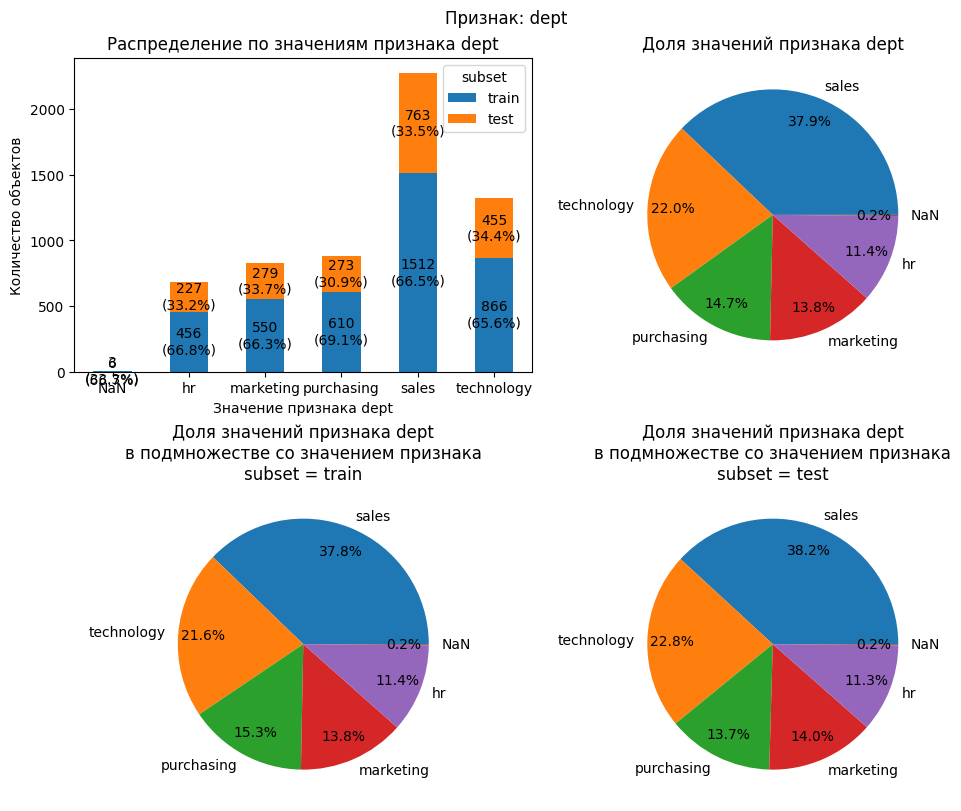

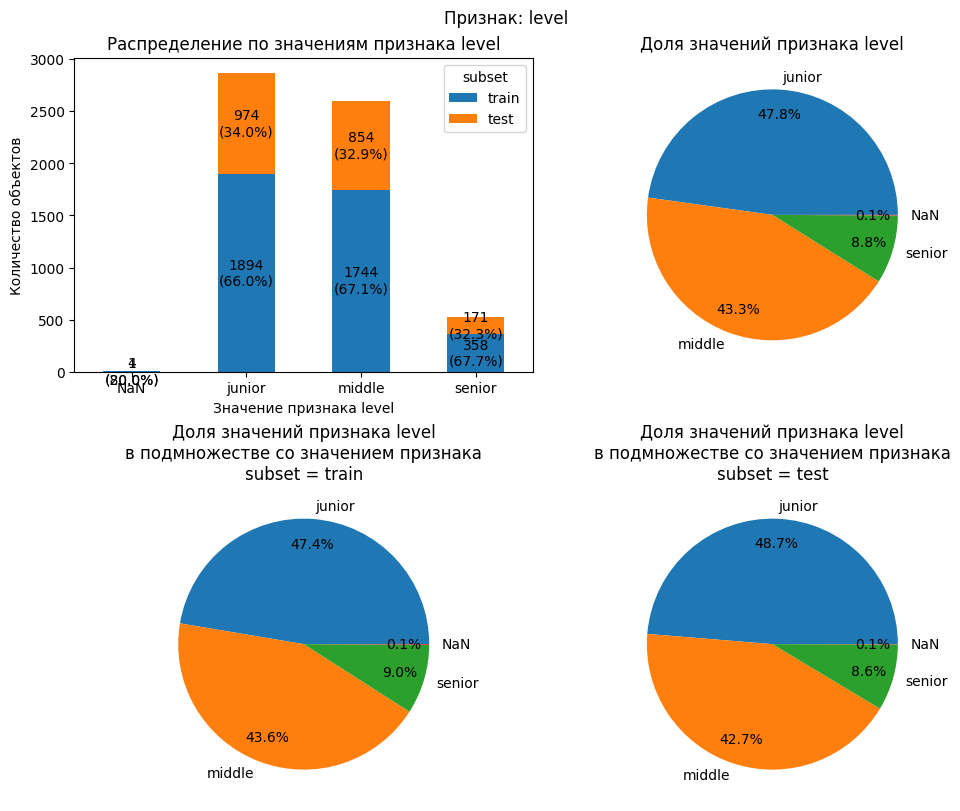

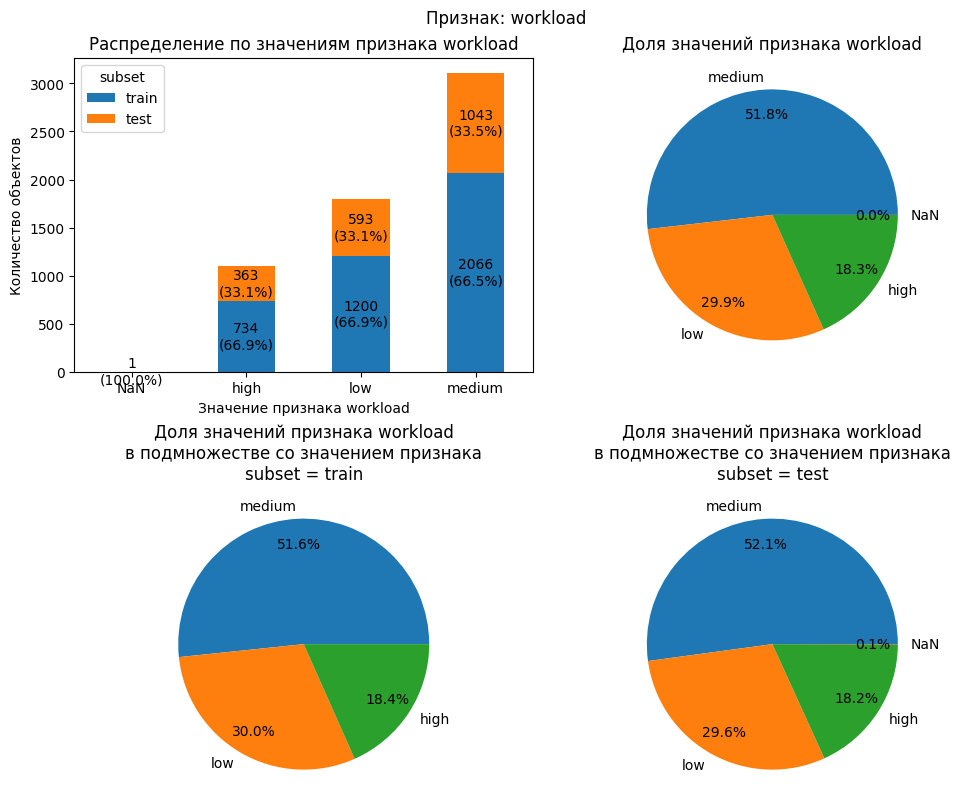

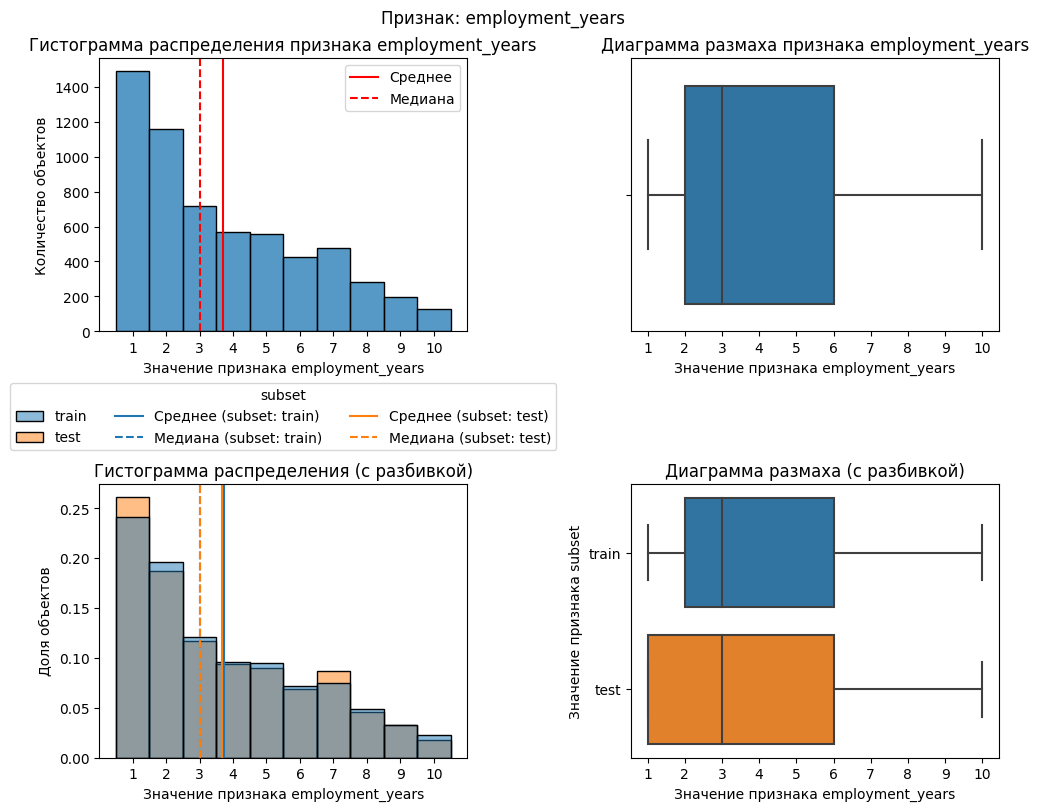

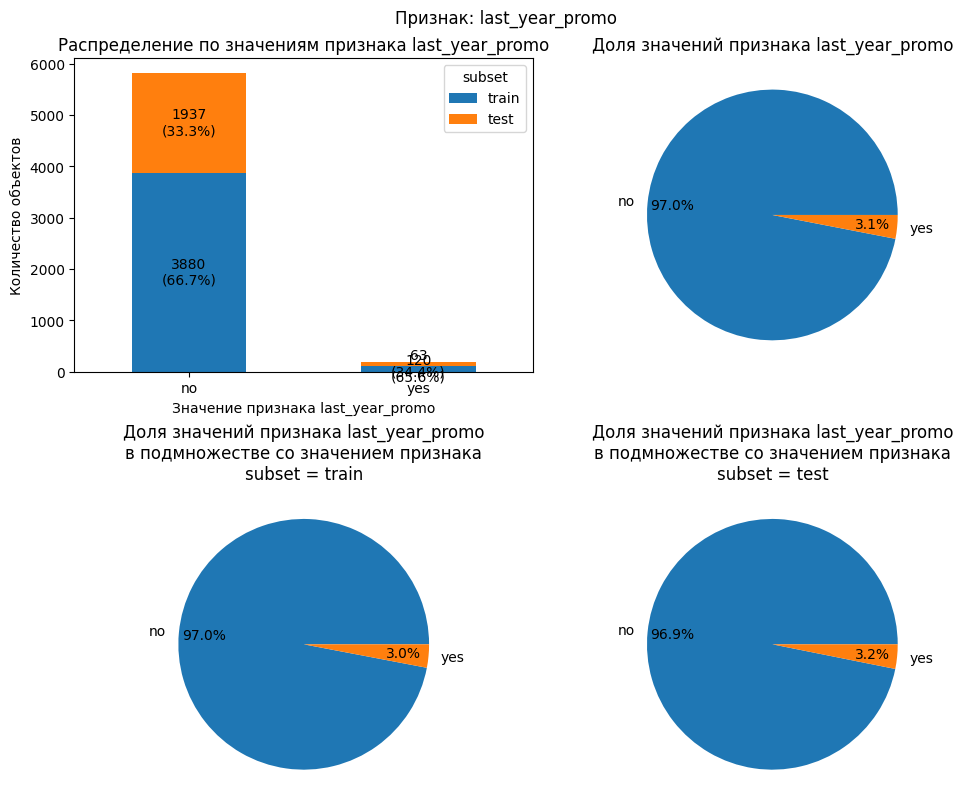

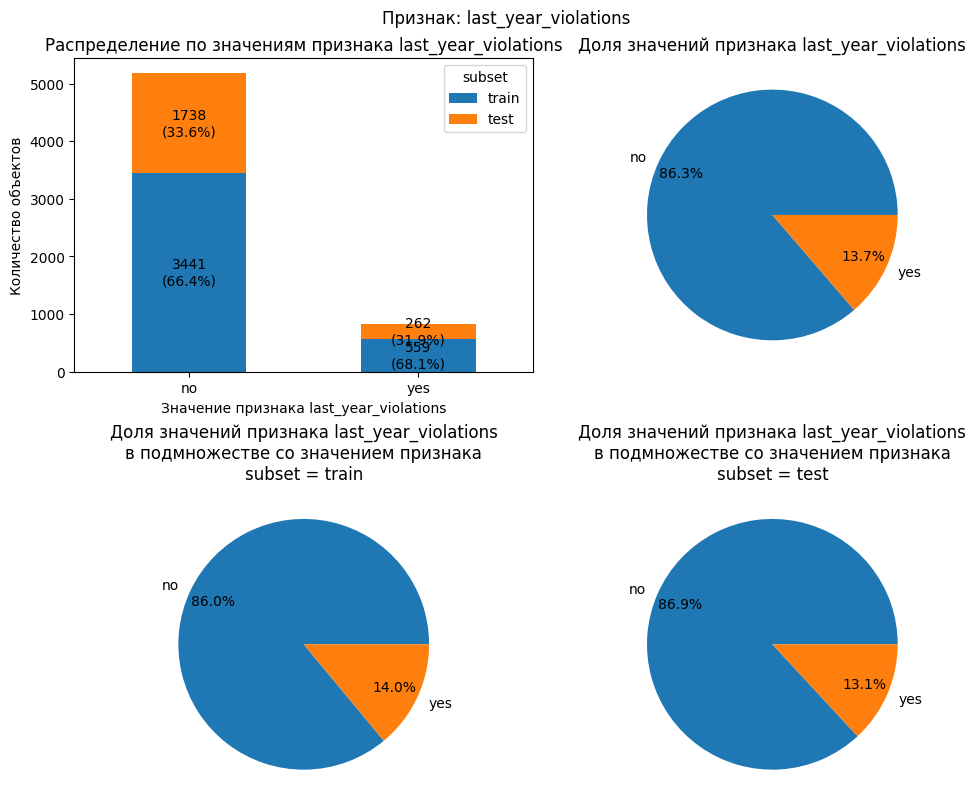

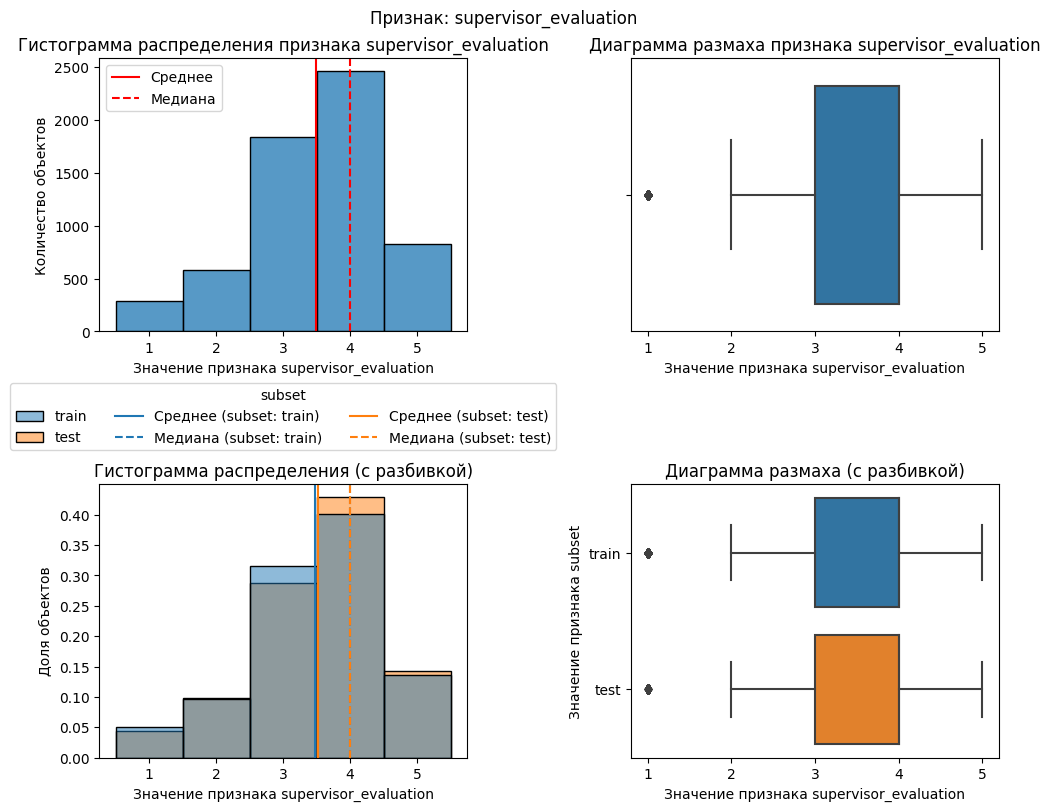

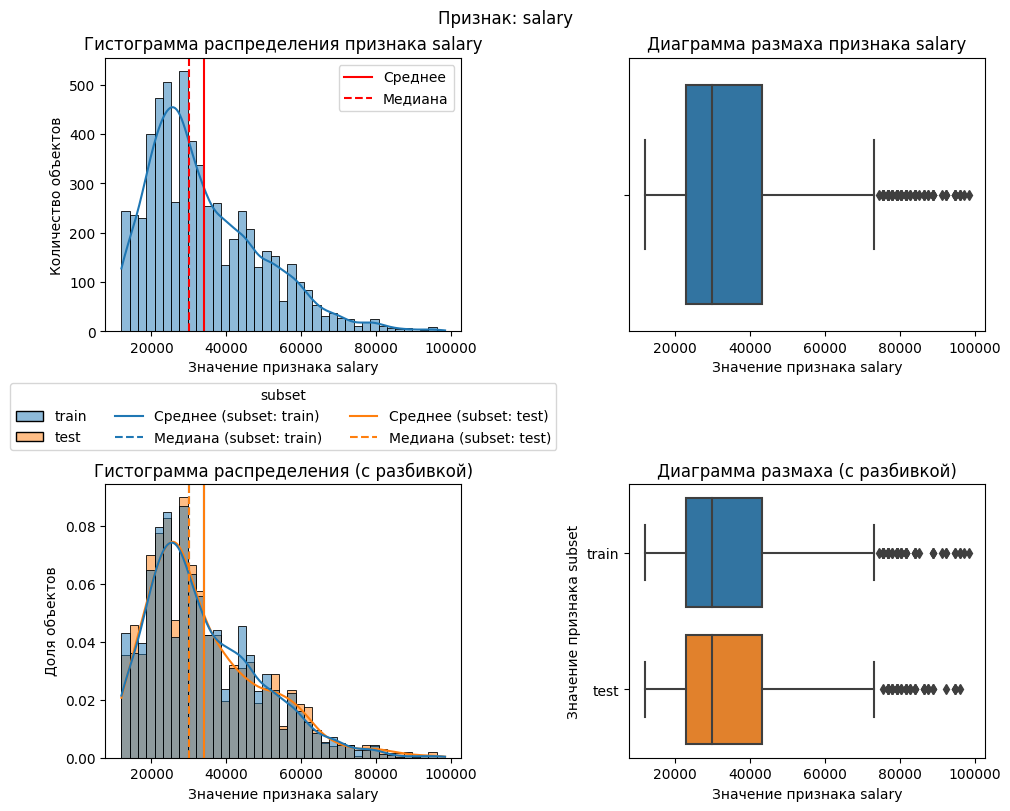

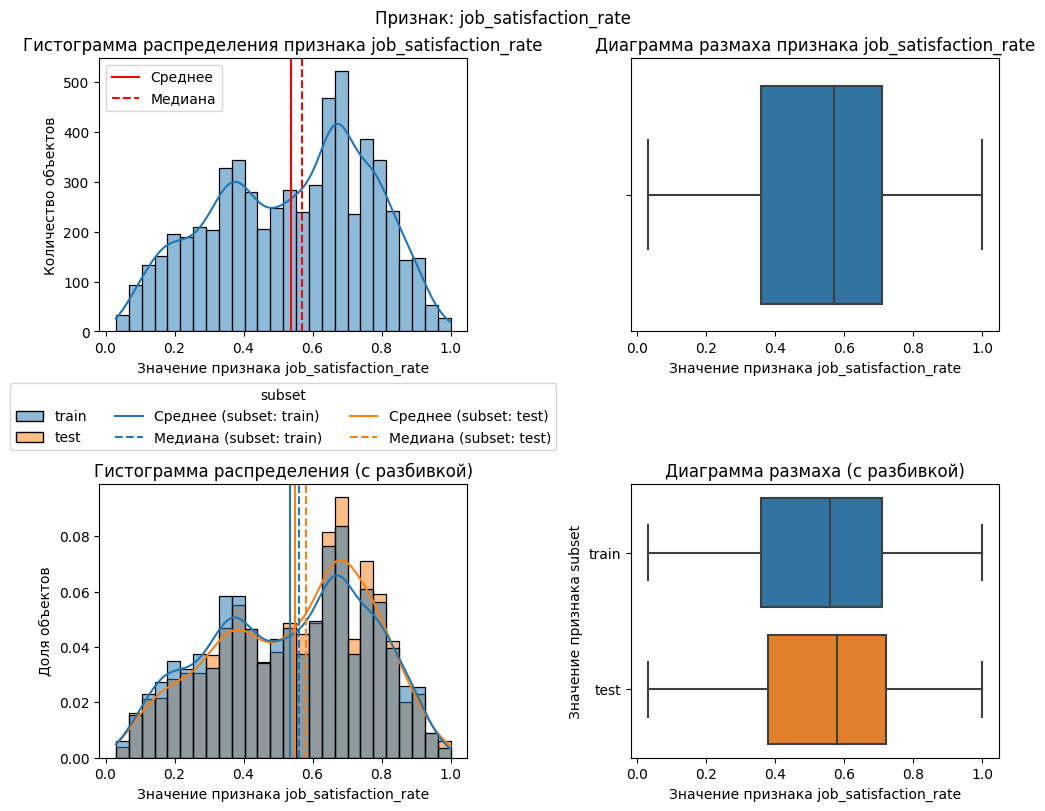

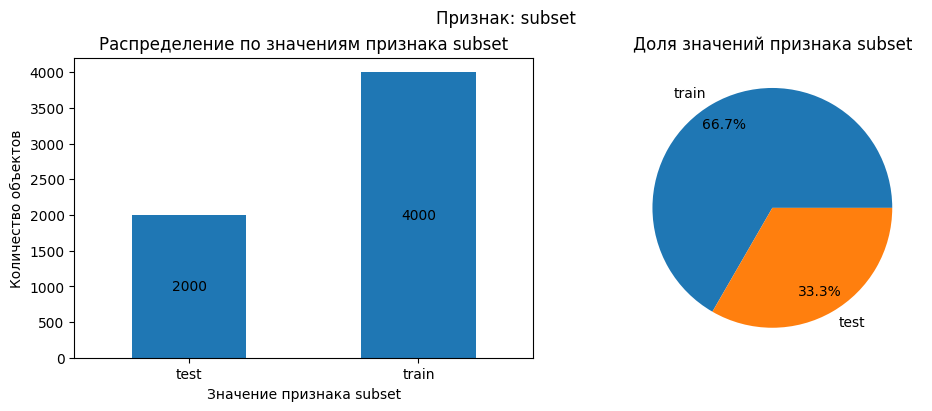

In [31]:
# строим графики для каждого признака в таблице
for feature in df_jsr.columns:
    stat_plots(df_jsr, feature, target='subset')

- Соотношение размеров тренировочной и тестовой выборки составляет 2 к 1.

- Распределения значений и статистические характеристики всех признаков, в том числе и целевого признака `job_satisfaction_rate`, в тренировочной и в тестовой выборке, а также в данных в целом, практически одинаковы. Значит, выборки можно считать стратифицированными.

- Аномалии и выбросы в данных отсутствуют.

- Наблюдения по результатам анализа:
    - В компании 5 отделов: кадров (`hr`), маркетинга (`marketing`), закупок (`purchasing`), продаж (`sales`) и технический (`technology`).
    - Сотрудники делятся на 3 уровня занимаемой должности: `junior`, `middle`, `senior`.
    - Уровней загруженности тоже 3: низкий (`low`),средний (`medium`) и высокий (`high`,).
    - Стаж работы сотрудников составляет от 1 до 10 лет, причём по мере увеличения стажа работы в компании количество сотрудников убывает.
    - Повышение за последний год получили примерно 3% сотрудников.
    - Доля сотрудников с нарушениями составляет около 14%.
    - Качество работы сотрудника руководитель оценивает по 5-балльной шкале от 1 до 5. Самая частая оценка — 4, она же медианная.
    - Распределение по зарплате имеет ожидаемый вид с "хвостом" в области высоких значений, однако длина "хвоста" не слишком велика, существенных выбросов нет.
    - Уровень удовлетворённости сотрудника работой в компании принимает значения в диапазоне от 0.03 до 1. 

#### Корреляционный анализ данных

Исследуем степень связи входных признаков друг с другом, чтобы определить характер и силу связи между каждым из входных признаков и целевым признаком, а также проверить входные признаки на мультиколлинеарность. Для этого рассчитаем матрицу корреляции признаков и визуализируем её в виде тепловой карты. Для этого используем функцию `corr_matrix()`.

Качество и интерпретируемость линейных ML моделей может пострадать из-за мультиколлинеарности между входными признаками, т.е. если между ними есть сильная линейная связь. Степень линейной связи между количественными признаками покажет корреляция Пирсона. 

Анализ корреляций проведём для тренировочной и тестовой выборки отдельно, чтобы убедиться, что между ними нет существенных различий связи признаков. Если это так, то оценка качества ML модели, полученная на тестовой выборке, будет корректной.

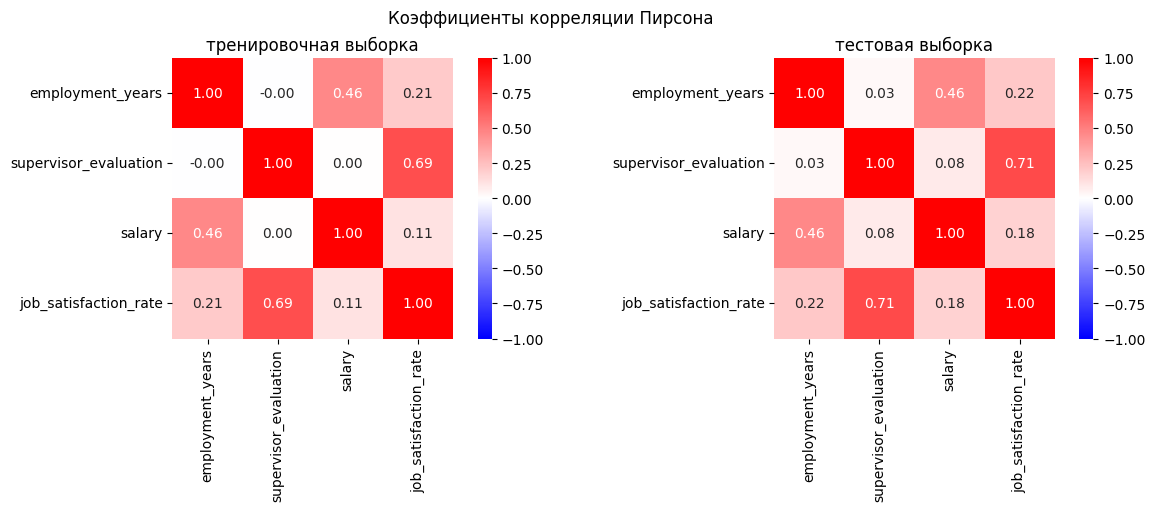

In [32]:
# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True)

plt.sca(axes[0])
# строим матрицу корреляции
# для тренировочной выборки
corr_matrix(df_train_jsr)
title = axes[0].get_title()
axes[0].set_title('тренировочная выборка')

plt.sca(axes[1])
# строим матрицу корреляции
# для тестовой выборки
corr_matrix(X_test.join(y_test_jsr))
axes[1].set_title('тестовая выборка')

fig.suptitle(title);

- Значения коэффициентов корреляции Пирсона между количественными признаками в тренировочной выборке не превышают 0.7. Значит, мультиколлинеарности нет.

- Коэффициенты корреляции признаков в тренировочной и тестовой выборках близки. Самое сильное различие в корреляции между признаком `salary` (зарплата) и целевым признаком `job_satisfaction_rate` (уровень удовлетворённости): 0.11 в тренировочной и 0.18 в тестовой.

Для анализа связи целевого признака `job_satisfaction_rate` с категориальными признаками (что важно для проверки на утечку целевого признака), а также проверки категориальных признаков на мультиколлинеарность, рассчитаем коэффициенты корреляции фи ($\phi_k$) для всех признаков. Для этого используем метод `phik_matrix()` из библиотеки `phik`.

При использовании `phik_matrix()` нужно передать ему в аргументе `interval_cols`  список с названиями **непрерывных количественных признаков**, т.к. от типа признака зависит метод оценки корреляции. В анализируемых данных такими признаками являются `salary` и `job_satisfaction_rate`. 

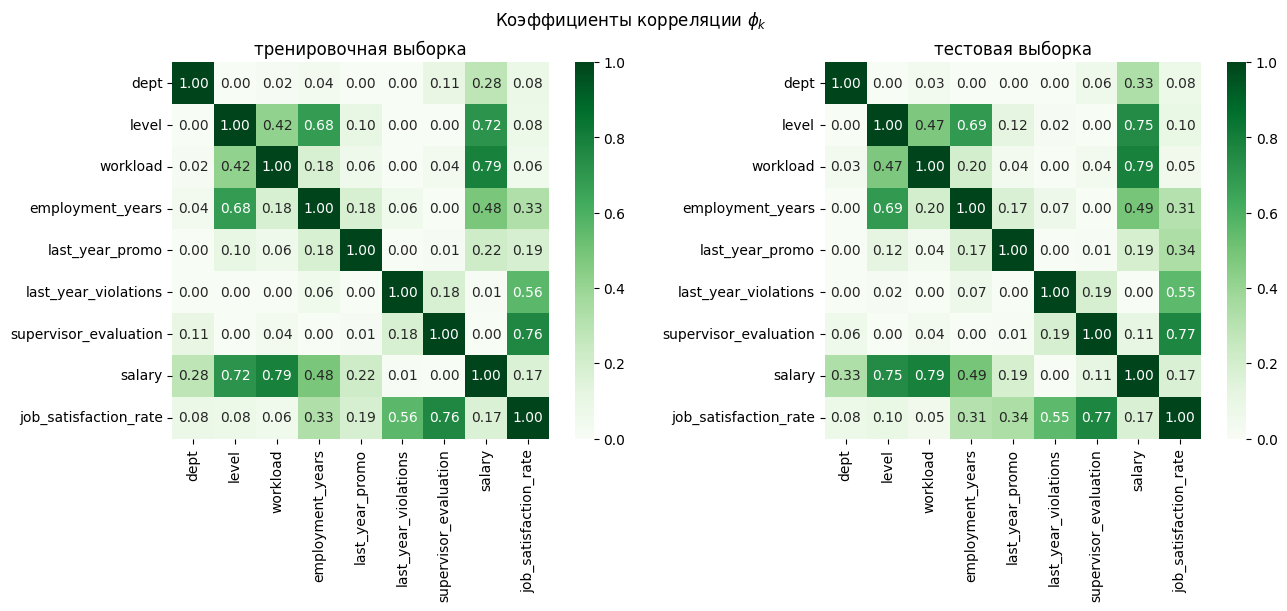

In [33]:
# список непрерывных количественных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), constrained_layout=True)

plt.sca(axes[0])
# строим матрицу корреляции
# для тренировочной выборки
corr_matrix(df_train_jsr, method='phik', interval_cols=interval_cols)
title = axes[0].get_title()
axes[0].set_title('тренировочная выборка')

plt.sca(axes[1])
# строим матрицу корреляции
# для тестовой выборки
corr_matrix(X_test.join(y_test_jsr), method='phik', interval_cols=interval_cols)
axes[1].set_title('тестовая выборка')

fig.suptitle(title);

- Значения коэффициентов корреляции $\phi_k$ между признаками в тренировочной выборке не превышают 0.8. Значит, мультиколлинеарности и утечки целевого признака нет.
- Коэффициенты корреляции $\phi_k$ в тренировочной и тестовой отличаются не принципиально. Самое сильное различие в величине корреляции между признаком `last_year_promo` (было ли повышение за последний год) и целевым признаком `job_satisfaction_rate` (уровень удовлетворённости): 0.19 в тренировочной и 0.34 в тестовой.

#### Выводы

- Статистический анализ признаков показал:
    - Тренировочную и тестовую выборки можно считать стратифицированными. Распределения значений всех признаков в них, а также в данных в целом, практически одинаковы.
    - Аномалии и выбросы в данных отсутствуют.

- Из результатов статистического анализа признаков можно сделать выводы о том, как нужно подготовить данные для обучения ML моделей:
    - Категориальный номинальный признак `dept` (отдел) следует кодировать с помощью `OneHotEncoder`.
    - Категориальные бинарные признаки `last_year_promo` и `last_year_violations` тоже лучше кодировать с помощью `OneHotEncoder`, тогда выходные признаки будут более информативны. Например, первый признак после кодирования преобразуется в бинарный с названием `last_year_promo_yes`, т.е. значение 1 означает, что сотрудник получил повышение.
    - Категориальные порядковые признаки `level` (уровень занимаемой должности) и `workload` (уровень загруженности) следует кодировать с помощью `OrdinalEncoder` в порядке возрастания уровня.
    - Количественные входные признаки следует масштабировать. Поскольку распределения не имеют выбросов, то для этого подойдёт стандартизация (скейлер `StandardScaler`). Но при подборе наилучших гиперпараметров моделей можно попробовать и другие скейлеры, хотя применение нормализации к признаку `salary` - не лучшая идея из-за хвоста в распределении.

- Корреляционный анализ признаков показал:
    - Мультиколлинеарность между входными признаками отсутствует.
    - С целевым признаком `job_satisfaction_rate` сильнее всего связан признак `supervisor_evaluation` (оценка руководителя), заметная связь также с признаком `last_year_violations` (его влияние на удовлетворённость должно быть негативное).
    - Различия между величинами коэффициентов корреляции признаков в тренировочной и тестовой выборках не значительны. Наибольшее различие между выборками в корреляции существует между признаками `salary` (зарплата) и `last_year_promo` (было ли повышение за последний год) и целевым признаком `job_satisfaction_rate` (уровень удовлетворённости), однако составляет не более 0.15. Поэтому оценка качества ML модели, полученная на тестовой выборке, будет корректной.

### Подготовка данных

#### Проверка на дубликаты

Перед обучением модели на данных их нужно проверить на наличие дубликатов — записей с одинаковым набором признаков. Наличие таких дубликатов в тренировочной выборке не только не принесёт пользы при обучении модели, а даже может навредить. Поэтому при обнаружении их следует удалить.

In [34]:
print(
    'Количество дубликатов в тренировочной выборке:', 
    df_train_jsr.duplicated().sum()
)

Количество дубликатов в тренировочной выборке: 245


Дубликаты обнаружены. Удалим их.

In [35]:
# удаляем дубликаты
df_train_jsr = df_train_jsr.drop_duplicates()
print('Количество записей в тренировочной выборке:',len(df_train_jsr))

Количество записей в тренировочной выборке: 3755


#### Преобразование данных

Подготовим данные для обучения и проверки качества ML моделей:
- Выделим из тренировочной выборки `df_train_jsr` входные признаки в переменную `X_train_jsr` и целевой признак `job_satisfaction_rate` в переменную `y_train_jsr`.
- Преобразуем целевой признак тестовой выборки в переменной `y_test_jsr` из датафрейма в ряд (`pandas.Series`).

In [36]:
# входные признаки тренировочной выборки
X_train_jsr = df_train_jsr.drop(columns='job_satisfaction_rate')
# целевой признак тренировочной выборки
y_train_jsr = df_train_jsr['job_satisfaction_rate']
# целевой признак тестовой выборки
y_test_jsr = y_test_jsr['job_satisfaction_rate']

#### Сборка пайплайна

Подготовим списки признаков для кодирования и масштабирования в соотвествии с выводами о подходящем для каждого признака типе кодировщика и скейлера.

In [37]:
# категориальные номинальные признаки для кодирования OneHotEncoder
ohe_columns = [
    'dept',
    'last_year_promo',
    'last_year_violations',
]
# категориальные порядковые признаки для кодирования OrdinalEncoder
ord_columns = [
    'level',
    'workload',
]
cat_columns = ohe_columns + ord_columns

# количественные признаки для масштабирования
num_columns = [
    'employment_years',
    'supervisor_evaluation',
    'salary',
]

# выводим списки исходных входных признаков и их количество
print('Категориальные признаки для кодирования OneHotEncoder:', ohe_columns)
print('Категориальные признаки для кодирования OrdinalEncoder:', ord_columns)
print('Количественные признаки для масштабирования:', num_columns)
print()
print('Всего {} исходных входных признаков, из них {} количественных и {} категориальных.'
      .format(len(num_columns + cat_columns),
              len(num_columns),
              len(cat_columns)
             ),
     )

Категориальные признаки для кодирования OneHotEncoder: ['dept', 'last_year_promo', 'last_year_violations']
Категориальные признаки для кодирования OrdinalEncoder: ['level', 'workload']
Количественные признаки для масштабирования: ['employment_years', 'supervisor_evaluation', 'salary']

Всего 8 исходных входных признаков, из них 3 количественных и 5 категориальных.


Построим пайплайны для подготовки данных и соберём из них итоговый пайплайн для обучения ML моделей.
- В пайплайне для кодирования категориальных признаков используем `SimpleImputer` для заполнения пропусков самым часто встречающимся значением.
- В пайплайнах для масштабирования количественных признаков используем `SimpleImputer` для заполнения пропусков медианным значением.
- Предусмотрим в итоговом пайплайне этап отбора входных признаков для удаления признаков с низкой значимостью. 
- Предсказание значений непрерывной количественной величины — это задача регрессии. В качестве базовой ML модели возьмём линейную регрессию `LinearRegression`.

In [38]:
# пайплайн для кодирования категориальных номинальных признаков
ohe_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ]
)
# пайплайн для кодирования категориальных номинальных признаков
ord_pipe = Pipeline(
    [
        ('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=np.nan,
            categories=[
                ['junior', 'middle', 'senior'],  # признак 'level'
                ['low', 'medium', 'high']  # признак 'workload'
            ])
        ),
        ('imputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)
# пайплайн для масштабирования количественных признаков
num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler()),
    ]
)
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ordinal', ord_pipe, ord_columns),
        ('numeric', num_pipe, num_columns),
    ], 
    remainder='drop',
    verbose_feature_names_out=False,
)
# итоговый пайплайн
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('feature_selector', 'passthrough'),
        ('model', LinearRegression())
    ]
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', 'passthrough'),
                ('model', LinearRegression())])

Посмотрим, какой набор входных признаков получается после кодирования исходных категориальных признаков.

In [39]:
# обучаем пайплайн подготовки данных
data_preprocessor.fit(X_train_jsr)
# получаем из пайплайна названия признаков
pd.Series(data_preprocessor.get_feature_names_out())

0               dept_marketing
1              dept_purchasing
2                   dept_sales
3              dept_technology
4          last_year_promo_yes
5     last_year_violations_yes
6                        level
7                     workload
8             employment_years
9        supervisor_evaluation
10                      salary
dtype: object

Получилось 11 входных признаков, из которых 6 бинарных (значения 0, 1), 2 тернарных (значения 0, 1, 2) и 3 масштабированных количественных.

#### Выводы

- Из тренировочной выборки удалены обнаруженные дубликаты — записи с одинаковым набором признаков. Наличие таких дубликатов в тренировочной выборке не принесло бы пользы при обучении модели, а даже могло навредить.
- Входные признаки и целевой признак тренировочной выборки выделены в отдельные переменные. Целевой признак тестовой выборки преобразован из датафрейма в ряд (`pandas.Series`).

- Входные признаки разделены на наборы для кодирования и масштабирования в соответствии с выводами о подходящем для каждого признака типе кодировщика и скейлера:
    - Категориальные номинальные признаки  `dept`, `last_year_promo` и `last_year_violations` закодированы с помощью `OneHotEncoder`.
    - Категориальные порядковые признаки `level` и `workload`  закодированы с помощью `OrdinalEncoder` в порядке возрастания уровня занимаемой должности и загруженности соответственно.
    - Количественные входные признаки `employment_years`, `supervisor_evaluation` и `salary` масштабированы стандартизацией с помощью `StandardScaler`.
    - В результате получилось 11 входных признаков, из которых 6 бинарных (значения 0, 1), 2 тернарных (значения 0, 1, 2) и 3 масштабированных количественных.
    
- Построен пайплайн для подготовки данных и обучения ML моделей.
    - В пайплайне подготовки данных пропуски значений категориальных признаков заполяются самым часто встречающимся значением, а пропуски значений количественных признаков заполяются медианным значением.
    - В итоговом пайплайне предусмотрен этап отбора входных признаков для удаления признаков с низкой значимостью. 
    - В качестве базовой регрессионой модели задана линейная регрессия `LinearRegression`.

### Обучение моделей

#### Метрика SMAPE

Для оценки качества ML моделей в данной задаче используем метрику SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»):
$$\text{SMAPE} = \frac{100}{n} \sum\limits_{i=1}^{n}{\frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2}},$$
где $y_i$ — фактическое значение целевого признака для объекта с порядковым номером $i$ в выборке; $\hat{y_i}$ — предсказанное значение целевого признака для объекта с порядковым номером $i$ в выборке, $n$ — количество объектов в выборке.

Чтобы использовать метрику SMAPE, создадим функцию, которая принимает на вход массивы NumPy или объекты pandas.Series и возвращает значение метрики SMAPE. Затем создадим на основе этой функции создадим пользовательскую метрику с помощью функции `make_scorer`, чтобы использовать её при подборе гиперпараметров и оценке качества моделей. При этом необходимо указать, что меньшие значения метрики лучше, для чего нужно задать аргумент `greater_is_better=False`. В результате к значению метрики будет добавлен знак "минус", чтобы соответствовать принятому соглашению о том, что большее значение метрики означает лучшее качество модели.

In [40]:
def smape_func(y_true, y_pred):
    """
    Метрика SMAPE (symmetric mean absolute percentage error).
    """
    n = len(y_true)
    assert (y_true.shape == (n,)) and (y_pred.shape == (n,))
    
    smape = 100/n * np.sum( abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2) )
    
    return smape

In [41]:
# пользовательская метрика SMAPE
smape_score = make_scorer(smape_func, greater_is_better=False)

#### Обучение и настройка моделей

##### Линейная регрессия

В качестве базовой модели в пайплайне задана линейная регрессия `LinearRegression`. 
- Оценим её качество на тренировочной выборке при кросс-валидации.
- Попробуем улучшить модель, подобрав оптимальный тип скейлера и используя отбор входных признаков.

In [42]:
# вычисляем метрику модели на тренировояной выборке при кросс-валидации
baseline_cv_score = cross_val_score(final_pipe, X_train_jsr, y_train_jsr, cv=5, n_jobs=-1, scoring=smape_score)
print('SMAPE модели линейной регрессии на тренировочной выборке при кросс-валидации:')
print(f'Среднее значение: {-baseline_cv_score.mean():.4f}')
print(f'Стандартное отклонение: {baseline_cv_score.std():.4f}')

SMAPE модели линейной регрессии на тренировочной выборке при кросс-валидации:
Среднее значение: 24.9871
Стандартное отклонение: 0.5749


Значение метрики получилось большое. Возможно, подбор параметров подготовки данных поможет улучшить качество модели.

In [43]:
# словарь со списками параметров для перебора
param_grid = {
    'preprocessor__numeric__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'feature_selector': [SelectKBest(score_func=f_regression)],
    'feature_selector__k': range(1, 12)
}

In [44]:
# инициализируем класс для автоматизированного подбора параметров
search_linreg = GridSearchCV(
    final_pipe,
    param_grid,
    cv=5,
    scoring=smape_score,
    n_jobs=-1 
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_linreg.fit(X_train_jsr, y_train_jsr)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 15.646 с


In [45]:
# лучшая метрика на кросс-валидации
print(f'Метрика SMAPE лучшей модели линейной регрессии на тренировочной выборке при кросс-валидации: '
      f'{-search_linreg.best_score_:.4f}')

Метрика SMAPE лучшей модели линейной регрессии на тренировочной выборке при кросс-валидации: 24.9871


In [46]:
# оптимальные параметры подготовки данных
search_linreg.best_params_

{'feature_selector': SelectKBest(k=11, score_func=<function f_regression at 0x7f95ed1fd5e0>),
 'feature_selector__k': 11,
 'preprocessor__numeric__scaler': MinMaxScaler()}

In [47]:
# пайплайн лучшей модели 
best_pipe_linreg = search_linreg.best_estimator_
# лучшая модель SVR
best_model_linreg = best_pipe_linreg['model']
best_model_linreg

LinearRegression()

Подбор параметров не помог: у лучшей модели отличается только тип скейлера для подготовки данных, и для обучения модели используются все 11 входных признаков. Значение метрики получается таким же.

Таким образом, линейная модель не справляется с задачей. Скорее всего причина в том, что зависимость целевого признака от входных имеет нелинейный характер.

Посмотрим на коэффициенты влияния признаков, чтобы понять, какие признаки наиболее важны для модели линейной регрессии. Для этого используем функцию `plot_feature_importance()`.

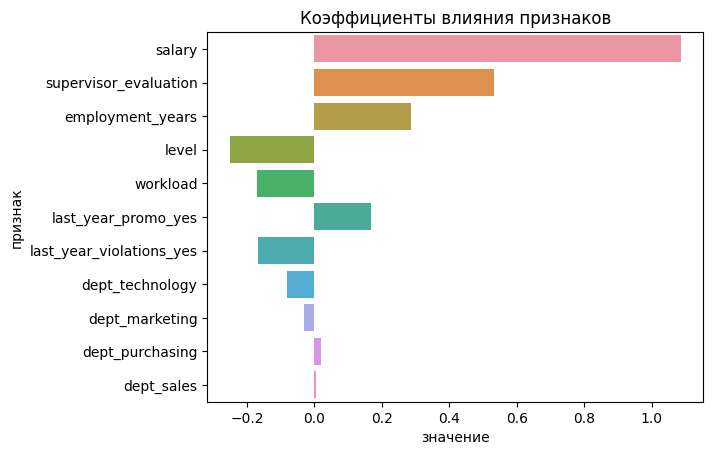

In [48]:
# пайплайн лучшей модели 
best_pipe_linreg = search_linreg.best_estimator_
# названия признаков
feature_names = final_pipe[:-1].get_feature_names_out()
# строим график важности признаков для модели
plot_feature_importance(best_pipe_linreg['model'].coef_, feature_names)
plt.title('Коэффициенты влияния признаков');

В принципе всё в основном логично: уровень удовлетворённости сотрудника работой в компании больше, если у него выше зарплата, он получил повышение и его высоко оценивает руководитель, и меньше, если он сильно загружен работой и имеет взыскания за нарушения. Неожиданно только то, что высокий уровень занимаемой должности приводит к низкой удовлетворённости работой.

##### Дерево решений

Обучим модель дерева решений для задачи регрессии — `DecisionTreeRegressor`. Дерево решений должно лучше справляться при наличии нелинейных зависимостей между входными признаками и целевым.

In [49]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = DecisionTreeRegressor(random_state=RANDOM_STATE)
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                                  ('imputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', 'passthrough'),
                ('model', DecisionTreeRegressor(random_state=42))])

In [50]:
# вычисляем метрику модели на тренировочной выборке при кросс-валидации
tree_cv_score = cross_val_score(final_pipe, X_train_jsr, y_train_jsr, cv=5, n_jobs=-1, scoring=smape_score)
print('SMAPE модели дерева решений на тренировочной выборке при кросс-валидации:')
print(f'Среднее значение: {-tree_cv_score.mean():.4f}')
print(f'Стандартное отклонение: {tree_cv_score.std():.4f}')

SMAPE модели дерева решений на тренировочной выборке при кросс-валидации:
Среднее значение: 16.4178
Стандартное отклонение: 0.8178


Попробуем улучшить метрику, подобрав гиперпараметры модели. У модели дерева решений несколько гиперпараметров, определяющих его структуру, среди них:
- `max_depth` — максимальная глубина дерева (по умолчанию не ограничена);
- `min_samples_split` — минимальное количество объектов в узле для его разделения (по умолчанию 2);
- `min_samples_leaf` — минимальное количество объектов в листе (по умолчанию 1).

Чтобы определиться с диапазоном значений глубины дерева, в котором будем искать оптимальное значение, надо узнать глубину обученного дерева, если не задано ограничение глубины.

In [51]:
# обучаем модель на тренировочной выборке
final_pipe.fit(X_train_jsr, y_train_jsr)
# глубина дерева решений
max_depth = final_pipe['model'].get_depth()
print(f'Глубина дерева решений, если не задано ограничение глубины: {max_depth = }')

Глубина дерева решений, если не задано ограничение глубины: max_depth = 24


Подбор оптимальной комбинации гиперпараметров методом полного перебора с использованием `GridSearchCV` занял бы много времени, а при случайном поиске с использованием `RandomizedSearchCV` есть риск пропустить хорошую комбинацию. Поэтому используем поиск с помощью метода байесовской оптимизации, реализованный в `OptunaSearchCV`.

In [52]:
# словарь со списками параметров для перебора
param_optuna = {
    'model__max_depth': distributions.IntDistribution(1, max_depth),
    'model__min_samples_split': distributions.IntDistribution(2, 15),
    'model__min_samples_leaf': distributions.IntDistribution(1, 15),
}
# инициализируем класс для автоматизированного подбора параметров
search_tree_reg = OptunaSearchCV(
    final_pipe,
    param_optuna,
    cv=5,
    scoring=smape_score,
    n_trials=100,
    random_state=RANDOM_STATE,
    verbose=-1
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_tree_reg.fit(X_train_jsr, y_train_jsr)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 97.525 с


Посмотрим на параметры лучшей модели дерева решений и её значение метрики SMAPE на тренировочной выборке при кросс-валидации.

In [53]:
# пайплайн лучшей модели 
best_pipe_tree_reg = search_tree_reg.best_estimator_
# лучшая модель дерева решений
best_pipe_tree_reg['model']

DecisionTreeRegressor(max_depth=17, min_samples_split=8, random_state=42)

Лучшая модель — дерево решений с глубиной 17 и минимальным количеством объектов в узле для его разделения, равным 8. 

In [54]:
# метрика лучшей модели
print(f'Метрика SMAPE лучшей модели дерева решений на тренировочной выборке при кросс-валидации: '
      f'{-search_tree_reg.best_score_:.4f}')

Метрика SMAPE лучшей модели дерева решений на тренировочной выборке при кросс-валидации: 15.3492


Посмотрим, какие признаки наиболее важны для лучшей модели дерева решений. 

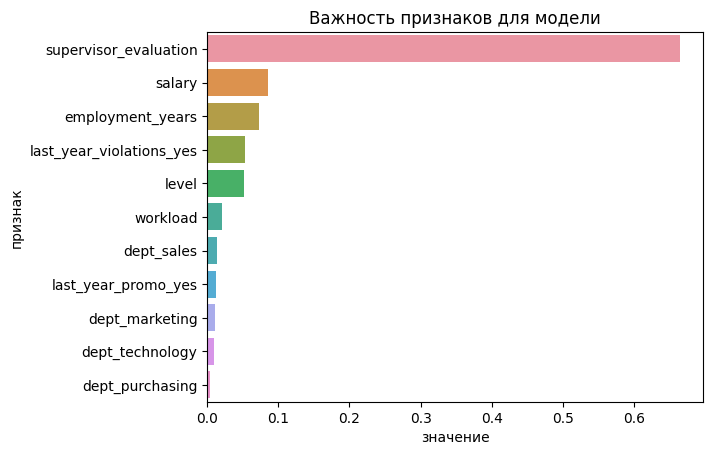

In [55]:
# названия признаков
feature_names = best_pipe_tree_reg[:-1].get_feature_names_out()
# строим график важности признаков для модели
plot_feature_importance(best_pipe_tree_reg['model'].feature_importances_, feature_names)
plt.title('Важность признаков для модели');

С большим отрывом лидирует признак `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель. Этот признак, как было установлено ранее, имеет наибольшую корреляцию с целевым признаком `job_satisfaction_rate`.

Возникают подозрения, нет ли здесь утечки целевого признака. В описании методики сбора данных сказано, что данные получают из форм обратной связи (тест-опросников), которые заполняют сотрудники. Не понятно, откуда берётся оценка руководителя: её указывает сам сотрудник или его руководитель. Этот момент требует уточнения у заказчика описания методики сбора данных.

##### Модель опорных векторов

Обучим ещё одну регрессионную модель — модель метода опорных векторов (SVM) `SVR`. Используем тип ядра по умолчанию — RBF. Благодаря нелинейному ядру модель SVM может работать со сложными данными с нелинейной зависимостью.

In [56]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = SVR()
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', 'passthrough'), ('model', SVR())])

In [57]:
# вычисляем метрику базовой модели на тренировояной выборке при кросс-валидации
svr_cv_score = cross_val_score(final_pipe, X_train_jsr, y_train_jsr, cv=5, n_jobs=-1, scoring=smape_score)
print('SMAPE модели SVR на тренировочной выборке при кросс-валидации:')
print(f'Среднее значение: {-svr_cv_score.mean():.4f}')
print(f'Стандартное отклонение: {svr_cv_score.std():.4f}')

SMAPE модели SVR на тренировочной выборке при кросс-валидации:
Среднее значение: 14.7295
Стандартное отклонение: 0.4107


Метрика на тренировочной выборке для модели SVR с параметрами по умолчанию лучше, чем у лучшей модели дерева решений (15.3492).

Чтобы улучшить результат, подберём оптимальное значение одного из гиперпараметров модели — силы регуляризации (параметр `C`), используя метод байесовской оптимизации, реализованный в `OptunaSearchCV`.

In [58]:
# словарь со списками параметров для перебора
param_optuna = {
    'model__C': distributions.FloatDistribution(0.1, 10, log=True),
}
# инициализируем класс для автоматизированного подбора параметров
search_svr = OptunaSearchCV(
    final_pipe,
    param_optuna,
    cv=5,
    scoring=smape_score,
    n_trials=20,
    random_state=RANDOM_STATE,
    verbose=-1
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_svr.fit(X_train_jsr, y_train_jsr)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 132.512 с


In [59]:
# пайплайн лучшей модели 
best_pipe_svr = search_svr.best_estimator_
# лучшая модель SVR
best_model_svr = best_pipe_svr['model']
best_model_svr

SVR(C=3.789424464186491)

In [60]:
# метрика лучшей модели
print(f'Метрика SMAPE лучшей модели SVM на тренировочной выборке при кросс-валидации: '
      f'{-search_svr.best_score_:.4f}')

Метрика SMAPE лучшей модели SVM на тренировочной выборке при кросс-валидации: 14.5834


В результате подбора параметра регуляризации удалось повысить качество модели. 

Чтобы проверить, не переобучилась ли модель, посмотрим, какое у неё стандартное отклонение метрики SMAPE на тренировочной выборке при кросс-валидации.

In [61]:
# датафрейм с результатами подбора гиперпараметров
optuna_results = search_svr.trials_dataframe()
# стандартное отклонение метрики SMAPE лучшей модели
best_model_std_cv_score = optuna_results.loc[
    search_svr.best_index_, 
    'user_attrs_std_test_score'
]
print('Стандартное отклонение SMAPE лучшей модели SVR '
      'на тренировочной выборке при кросс-валидации: '
      f'{best_model_std_cv_score:.4f}')

Стандартное отклонение SMAPE лучшей модели SVR на тренировочной выборке при кросс-валидации: 0.5041


Значение близко к тому, которое было у базовой модели линейной регрессии. Значит, переобучения нет.

#### Выбор лучшей модели

Лучшие значения метрики SMAPE на тренировочной выборке при кросс-валидации для моделей трёх разных классов приведены в таблице.
- Наименьшее, а значит наилучшее, значение метрики у модели SVR.
- Модель дерева решений показала более слабый худший результат.
- Модель линейной регрессии показала самый худший результат. 

In [62]:
# метрики лучших моделей каждого класса
pd.DataFrame({
    'модель': ['LinearRegression', 'DecisionTreeRegressor', 'SVR'],
    'SMAPE': [-search.best_score_ for search in (search_linreg, search_tree_reg, search_svr)]
}).sort_values('SMAPE').reset_index(drop=True).round(2)

модель  SMAPE
0                    SVR  14.58
1  DecisionTreeRegressor  15.35
2       LinearRegression  24.99

Таким образом, **лучшая модель** — это модель метода опорных векторов `SVR` с ядром RBF и значением параметра регуляризации `C ≈ 3.789`.

Оценим качество лучшей модели SVR на тестовой выборке.

In [63]:
# считаем метрику на тестовой выборке
best_model_test_score = smape_score(best_pipe_svr, X_test, y_test_jsr)
print(f'Метрика SMAPE лучшей модели SVR на тестовой выборке: {-best_model_test_score:.4f}')

Метрика SMAPE лучшей модели SVR на тестовой выборке: 13.6083


Значение метрики SMAPE лучшей модели SVR на тестовой выборке удовлетворяет критерию успеха: SMAPE ≤ 15.

#### Анализ лучшей модели

##### Проверка на адекватность

Для проверки лучшей модели на адекватность сравним её с дамми-моделью `DummyRegressor`, которая всегда предсказывает константу — среднее значение целевого признака в тренировочной выборке. 

Лучшую модель можно считать адекватной, если качество её предсказаний на тестовой выборке лучше, чем у дамми-модели.

In [64]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = DummyRegressor()
)
display(final_pipe)
# обучаем модель на тренировочной выборке
final_pipe.fit(X_train_jsr, y_train_jsr)
# считаем метрику на тестовой выборке
dummy_model_test_score = smape_score(final_pipe, X_test, y_test_jsr)
print(f'Метрика SMAPE дамми-модели на тестовой выборке: {-dummy_model_test_score:.4f}')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', 'passthrough'),
                ('model', DummyRegressor())])

Метрика SMAPE дамми-модели на тестовой выборке: 38.2623


Дамми-модель показала намного худшее качество, чем лучшая модель SVR. Значит, выбранная лучшая модель SVR адекватно предсказывает значения целевого признака `job_satisfaction_rate` — уровня удовлетворённости сотрудника работой в компании.

##### Анализ остатков

Оценим стабильность и устойчивость лучшей модели, проведя анализ остатков на тестовой выборке. Для этого используем функцию `plot_residuals()`.

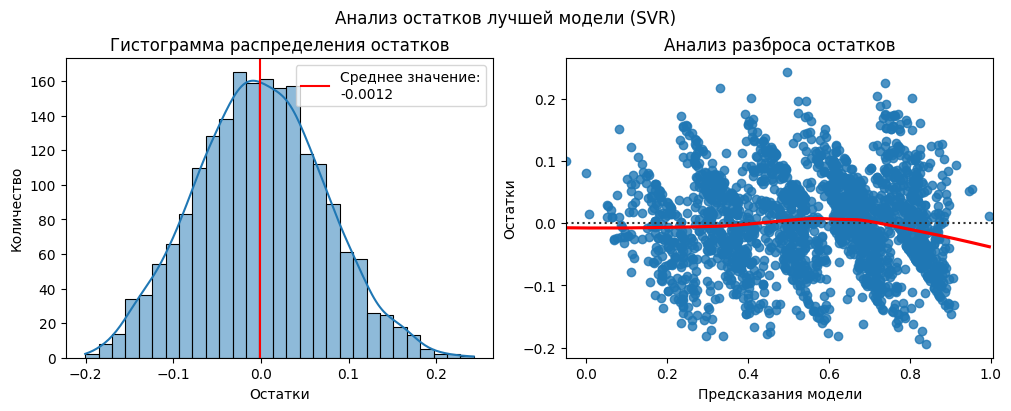

In [65]:
# повторно обучаем пайплайн лучшей модели SVR на тренировочной выборке
best_pipe_svr.fit(X_train_jsr, y_train_jsr)
# получаем предсказания модели SVR на тестовой выборке
y_pred_jsr_svr = best_pipe_svr.predict(X_test)

# строим графики для анализа остатков
fig, _ = plot_residuals(y_test_jsr, y_pred_jsr_svr)
fig.suptitle('Анализ остатков лучшей модели (SVR)');

Анализ остатков показывает:
- Распределение остатков похоже на нормальное и симметрично относительно нуля, значит модель ошибается равномерно и в принципе работает стабильно.
- Заметные выбросы в остатках отсутствуют.
- Разброс остатков в среднем примерно постоянен при различных значениях целевого признака, но имеет выраженную периодическую структуру. Это говорит о высоком качестве модели, поскольку в среднем она ошибается равномерно во всём диапазоне значений величины. Предсказания моделей сгруппированы в 5 кластеров, вероятно, соответствующих дискретным значениям признака признака `supervisor_evaluation` — оценки по 5-балльной шкале.

Сравним предсказания лучшей модели (SVR) с истинными значениями целевого признака `job_satisfaction_rate` в тестовой выборке. Для этого исследуем совместное распределение предсказанного и истинного значений на диаграмме рассеяния. Для идеальной модели все точки должны лежать на диагональной линии $y_{pred} = y_{true}$.

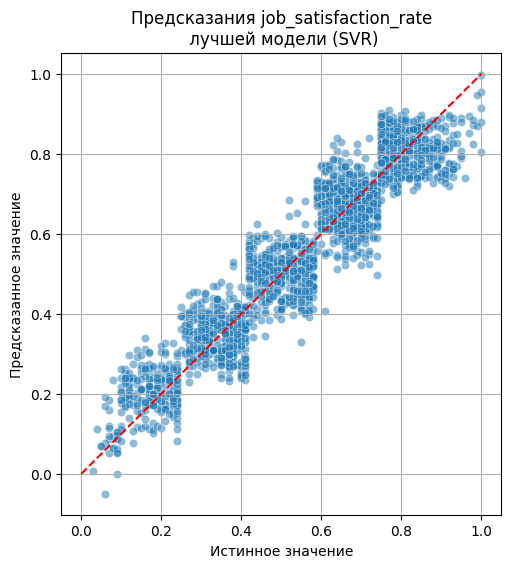

In [66]:
plt.figure(figsize=(6, 6))
# строим диаграмму рассеяния
ax = sns.scatterplot(x=y_test_jsr, y=y_pred_jsr_svr, alpha=0.5)
# проводим пунктирную диагональную линию
ax.plot([0, 1], [0, 1], 'r--')

ax.set_xlabel('Истинное значение')
ax.set_ylabel('Предсказанное значение')
ax.set_title('Предсказания job_satisfaction_rate\n лучшей модели (SVR)')
ax.grid()
ax.set_aspect('equal')

- На диаграмме рассеяния стало лучше заметно, что в предсказаниях лучшей модели практически отсутствуют выбросы. 

- У лучшей модели (SVR) есть маленький недостаток: в редких случаях предсказанные значения уровня удовлетворённости сотрудника могут выходить за пределы диапазона $[0, 1]$. Поэтому предсказания модели нужно корректировать, приводя выходящие за пределы диапазона значения к его границам, например, с помощью метода `numpy.ndarray.clip`.

- В предсказаниях модели проявляется группировка прогнозов модели из-за дискретности входного признака `supervisor_evaluation`. В пограничных интервалах значений между кластерами на диаграмме рассеяния предсказания модели могут быть неустойчивы: вблизи пограничного истинного значения целевого признака небольшое его изменение может приводить к значительной разнице прогнозов. Для повышения устойчивости предсказаний модели и получения более равномерного распределения прогнозов  следовало бы увеличить число градаций шкалы оценки качества работы сотрудника, которую даёт руководитель.

Поэтому можно сформулировать **рекомендацию** по улучшению методики получения входных данных для предсказания уровня удовлетворённости сотрудника:
- Необходимо увеличить число возможных градаций оценки качества работы сотрудника, которую даёт руководитель. Например, использовать хотя бы 10-балльную шкалу.

##### Оценка важности признаков

У модели SVR отсутствуют встроенные средства оценки важности признаков, поэтому оценим её, используя функцию `permutation_importance` из модуля `sklearn.inspection`. Но для её использования нужно выделить из пайплайна модели и подготовить данные с помощью трансформера из пайплайна, добавив в них затем названия признаков.

In [67]:
# трансформер для подготовки данных из пайплайна лучшей модели
best_transformer = best_pipe_svr[:-1]

# преобразуем тренировочную выборку
X_train_transformed = best_transformer.fit_transform(X_train_jsr, y_train_jsr)
# получаем из трансформера названия признаков
feature_names_out = best_transformer.get_feature_names_out()
# добавляем в тренировочную выборку названия признаков
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names_out)

# преобразуем тестовую выборку
X_test_transformed = best_transformer.transform(X_test)
# добавляем в тестовую выборку названия признаков
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_out)

# повторно обучаем модель на тренировочной выборке
best_model_svr.fit(X_train_transformed, y_train_jsr);

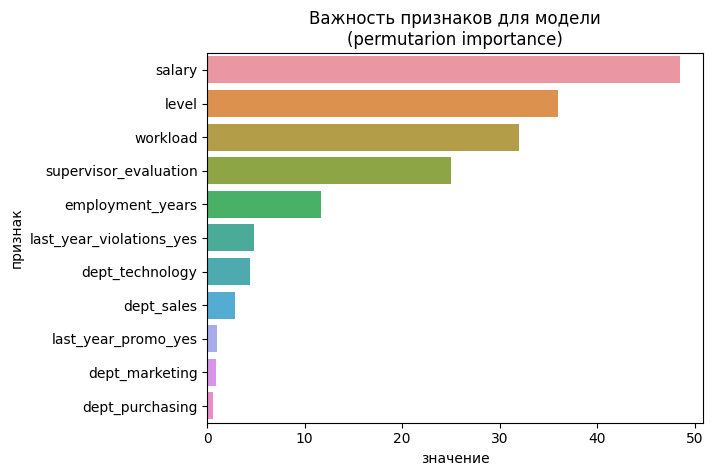

In [68]:
# определяем важность признаков для модели
permutation = permutation_importance(
    best_model_svr, 
    X_test_transformed, 
    y_test_jsr, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_repeats=10,
    n_jobs=-1,
)

# строим график важности признаков для модели
plot_feature_importance(permutation['importances_mean'], best_model_svr.feature_names_in_)
plt.title('Важность признаков для модели\n(permutarion importance)');

Для лучшей модели SVR на первом месте по важности — зарплата, далее следуют уровень занимаемой должности и уровень загруженности, оценка руководителя на 4-м месте по значимости.

Можно ожидать, что направленность влияния признаков такая же, как и для базовой модели линейной регрессии. Проверим это, используя метод SHAP для оценки значимости и характера влияния признаков на предсказания модели.

In [69]:
# инициализируем объект shap.Explainer
shap_explainer = shap.Explainer(best_model_svr.predict, X_train_transformed, seed=RANDOM_STATE)
# вычисляем значения Шепли для части тестовой выборки
shap_values = shap_explainer(X_test_transformed.sample(100, random_state=RANDOM_STATE))

PermutationExplainer explainer: 101it [07:56,  4.77s/it]                         


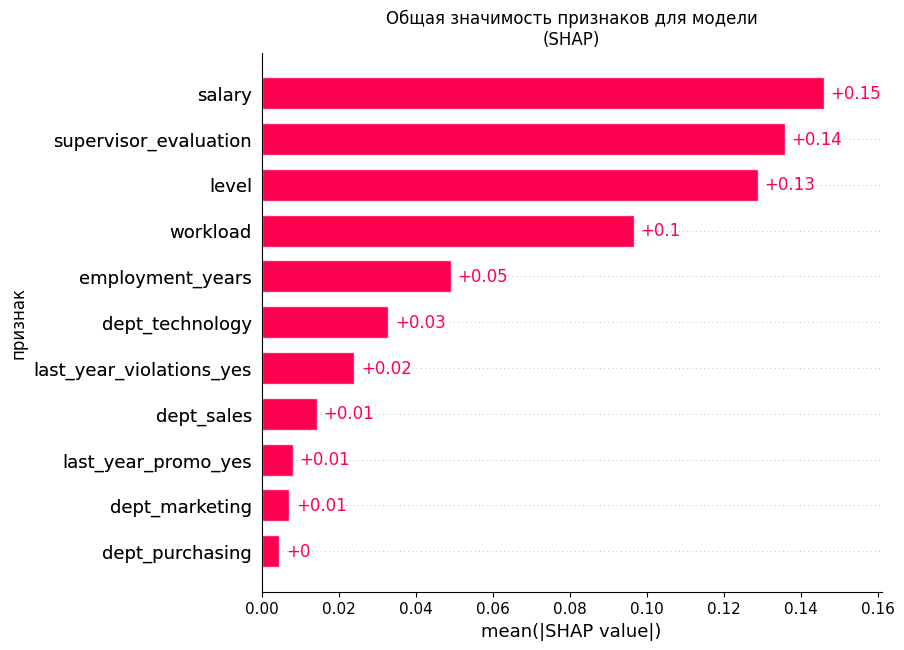

In [70]:
# строим график общей значимости признаков
shap.plots.bar(shap_values, max_display=11, show=False) 
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Общая значимость признаков для модели\n(SHAP)');

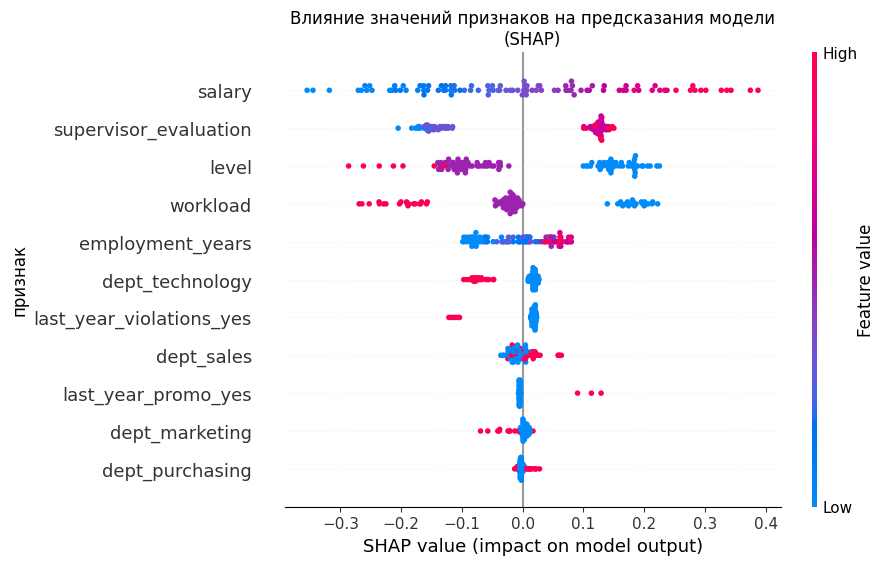

In [71]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака для каждого объекта
shap.plots.beeswarm(shap_values, max_display=11, show=False)
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Влияние значений признаков на предсказания модели\n(SHAP)');

- Оценка общей значимости признаков для модели по методу SHAP примерно совпадает с таковой по методу "permutarion importance".
- Метод SHAP показал более высокую значимость для модели признака `supervisor_evaluation` (оценка качества работы сотрудника руководителем).
- На графике влияния признаков видно, что сотрудники с высоким уровнем занимаемой должности менее удовлетворены своей работой. Возможно, есть связь с их высокой загруженностью. На это нужно обратить внимание заказчика.
- Ещё можно отметить негативное влияние принадлежности к техническому отделу (`dept_technology`) на уровнь удовлетворённости работой. 

Проверим, как распределяется уровень загруженности в зависимости от уровня занимаемой должности.

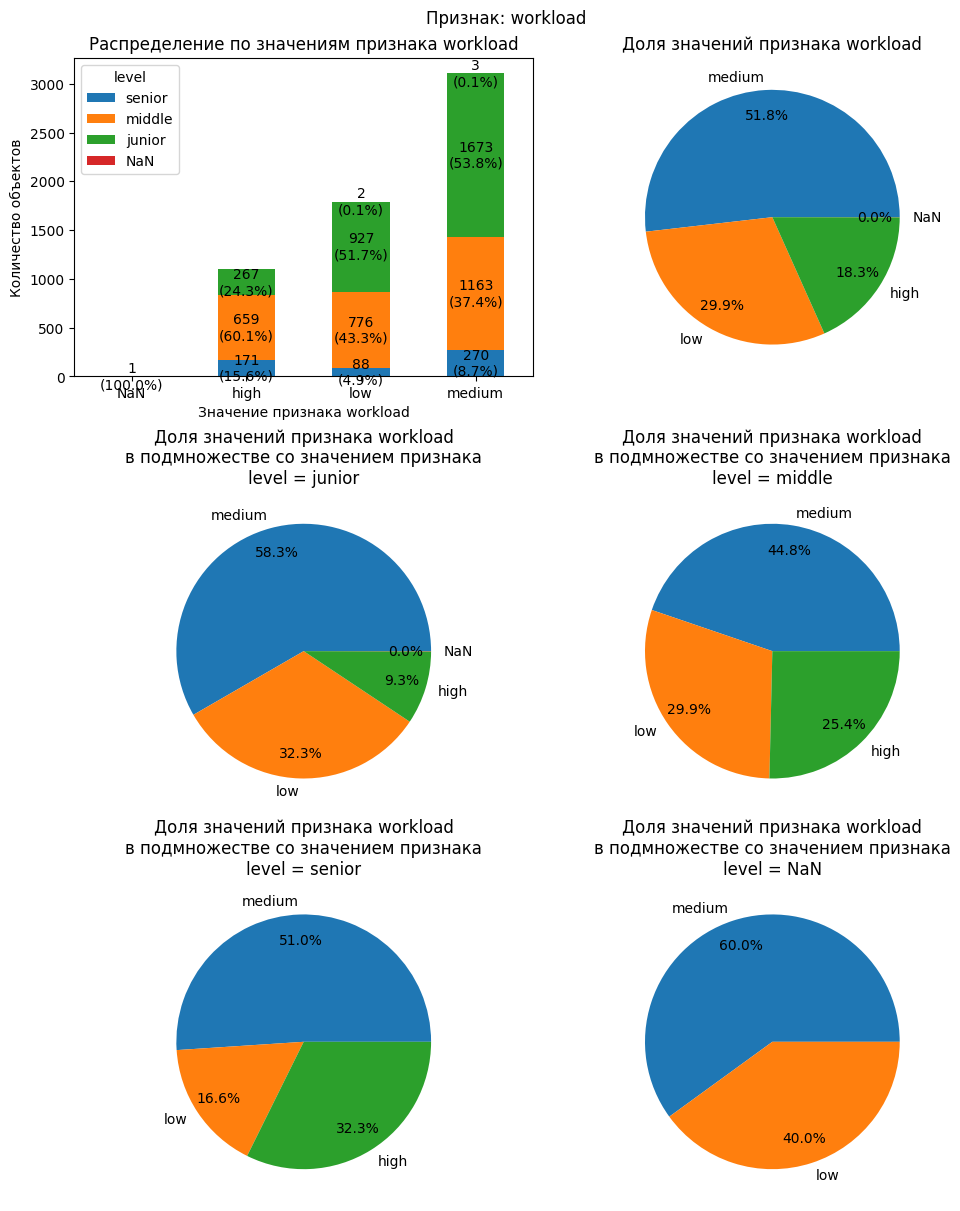

In [72]:
# строим графики
stat_plots(df_jsr, 'workload', target='level');

Действительно, сотрудники более высокого уровня загружены сильнее.

#### Выводы

1. Обучены три регрессионные модели:
    - линейная регрессия `LinearRegression`;
    - дерево решений `DecisionTreeRegressor`;
    - модель метода опорных векторов `SVR`.

2. Для моделей дерева решений и SVR подобраны оптимальные значения гиперпараметров, обеспечивающих минимальное (по абсолютной величине) значение метрики SMAPE.

3. Модель `LinearRegression` не справляется с задачей. Значение метрики на тренировочной выборке при кросс-валидации существенно превышает заданный целевой уровень SMAPE ≤ 15. Скорее всего причина в том, что зависимость целевого признака от входных имеет нелинейный характер.

4. Модель дерева решений `DecisionTreeRegressor` даже с оптимальными значениями гиперпараметров показала среднее качество на тренировочной выборке при кросс-валидации. Возможная причина такого результата в том, что модель слишком высоко оценивает важность одного признака — `supervisor_evaluation`.
    
5. Лучшая модель — `SVR` с ядром RBF и значением параметра регуляризации `C ≈ 3.789`, показала более высокое качество (меньшее значение метрики SMAPE), чем дерево решений на тренировочной выборке при кросс-валидации (14.58 против 15.35), и удовлетворяет критерию успеха (SMAPE = 13.61 ≤ 15 на тестовой выборке).

6. Проверка лучшей модели на адекватность показала, что модель хорошо справляется с задачей предсказания уровня удовлетворённости сотрудника: качество её предсказаний намного лучше, чем у дамми-модели, которая всегда предсказывает константу — среднее значение целевого признака в тренировочной выборке.

7. Анализ остатков лучшей модели на тестовой выборке показал:
    - Предсказания модели стабильны.
    - Модель допускает мало значительных ошибок в предсказаниях.
    - В среднем модель ошибается равномерно во всём диапазоне значений величины.
    - У модели SVR есть недостаток: в редких случаях предсказанные значения уровня удовлетворённости сотрудника могут выходить за пределы диапазона $[0, 1]$. Поэтому предсказания модели нужно корректировать, приводя выходящие за пределы диапазона значения к его границам, например, с помощью метода `numpy.ndarray.clip`.
    - Предсказания модели сгруппированы в 5 кластеров, соответствующих дискретным значениям признака признака `supervisor_evaluation` — оценки по 5-балльной шкале. В пограничных интервалах значений между кластерами на диаграмме рассеяния предсказания модели могут быть неустойчивы: небольшому изменению истинного значения  целевого признака соответствует большая разница прогнозов модели. Для повышения устойчивости предсказаний и получения более равномерного распределения прогнозов можно рекомендовать увеличить число возможных градаций оценки качества работы сотрудника, которую даёт руководитель (например, использовать хотя бы 10-балльную шкалу).
    
8. Анализ важности признаков для лучшей модели показал:
    - Наиболее значимые для модели признаки: `salary` (зарплата), `supervisor_evaluation` (оценка качества работы сотрудника руководителем), `level` (уровень занимаемой должности), `workload` (уровень загруженности).
    - Сотрудники с высоким уровнем занимаемой должности менее удовлетворены своей работой, возможно, по причине высокой загруженности. 

### Выводы по задаче предсказания уровня удовлетворённости сотрудника

1. Лучшая модель для задачи предсказания уровня удовлетворённости сотрудника — это модель метода опорных векторов `SVR` с ядром RBF и значением параметра регуляризации `C ≈ 3.789`.
    - Значение метрики SMAPE лучшей модели SVR на тестовой выборке удовлетворяет критерию успеха: SMAPE = 13.61 ≤ 15.
    - Лучшая модель адекватна задаче и обеспечивает стабильную и в среднем равномерную точность прогноза, а также допускает мало значительных ошибок.
    - Тем не менее, у модели есть недостаток: в редких случаях предсказанные значения уровня удовлетворённости сотрудника могут выходить за пределы диапазона $[0, 1]$, поэтому предсказания модели нужно корректировать, приводя выходящие за пределы диапазона значения к его границам.
    - Нужно учитывать, что предсказания лучшей модели в определённых узких интервалах значения целевого признака могут быть неустойчивыми по причине слишком грубой дискретности одного из наиболее значимых признаков для модели — оценки качества работы сотрудника руководителем. Для повышения устойчивости предсказаний необходимо увеличить число возможных градаций оценки качества работы сотрудника, которую даёт руководитель.
    
2. Модель дерева решений `DecisionTreeRegressor` даже с оптимальными значениями гиперпараметров показала среднее качество на тренировочной выборке при кросс-валидации. Возможная причина такого результата в том, что модель слишком высоко оценивает важность одного признака — `supervisor_evaluation`.

3. Модель линейной регрессии `LinearRegression` не справляется с задачей. Значение метрики на тренировочной выборке при кросс-валидации существенно превышает заданный целевой уровень SMAPE ≤ 15. Скорее всего причина в том, что модель не может подстроиться под нелинейную зависимость целевого признака от входных.

## Задача 2: Предсказание увольнения сотрудника из компании

### Загрузка и обзор данных

#### Загрузка данных

In [73]:
# загрузка данных из CSV файлов
df_train_quit = pd.read_csv(path + 'train_quit.csv')
y_test_quit = pd.read_csv(path + 'test_target_quit.csv')

#### Знакомство с данными

Дополним словарь с названиями и описаниями датасетов новыми данными.

In [74]:
# дополняем словарь с названиями и описаниями датасетов
df_dict.update({
    'df_train_quit': 'Тренировочная выборка в задаче предсказания увольнения сотрудника из компании',
    'y_test_quit': 'Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании',
})

In [75]:
for df_name in ['df_train_quit', 'X_test', 'y_test_quit']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # первые 5 строк таблицы
    display(eval(df_name).head())
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no


Входные признаки тестовой выборки (X_test):


dept   level workload  employment_years last_year_promo  \
id                                                                      
100298          hr  junior      low                 2              no   
100480   marketing  junior      low                 4              no   
100503  purchasing  middle     high                 5              no   
100610       sales  middle   medium                 5              no   
100692       sales  middle     high                 6              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
100298                   no                      4   19200  
100480                   no                      4   16800  
100503                   no                      4   55200  
100610                   no                      4   43200  
100692                   no                      4   48000


Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании (y_test_quit):


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [76]:
for df_name in ['df_train_quit', 'y_test_quit']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # общая информация о таблице
    print(eval(df_name).info())
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None

Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании (y_test_quit):
<class 'pandas.core.fram

#### Выводы

- Тренировочная выборка содержит 4000 записей.
- Датасет с целевым признаком содержит 2000 записей, что совпадает с размером тестовой выборки.
- Типы данных и масштабы значений соответствуют описанию данных.

### Предобработка данных

#### Обработка пропусков

In [77]:
for df_name in ['df_train_quit', 'X_test', 'y_test_quit']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # количество пропусков в столбцах таблицы
    print(eval(df_name).isna().sum())
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Входные признаки тестовой выборки (X_test):
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании (y_test_quit):
id      0
quit    0
dtype: int64



В тренировочной выборке и целевом признаке тестовой выборки пропущенные значения отсутствуют. Но в значениях входных признаков тестовой выборки `X_test` есть пропуски. Эти пропуски разумно заполнить наиболее часто встречающимся значением ("most_frequent") соответствующего признака, что будет сделано далее в пайплайне при подготовке данных для обучения ML моделей.

#### Обработка дубликатов

Посмотрим количество уникальных значений в столбцах таблиц (с учётом `NaN`).

In [78]:
for df_name in ['df_train_quit', 'y_test_quit']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    print('Количество уникальных значений в столбцах:')
    # количество уникальных значений в столбцах таблицы
    print(eval(df_name).nunique(dropna=False))
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):
Количество уникальных значений в столбцах:
id                       4000
dept                        5
level                       3
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     69
quit                        2
dtype: int64

Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании (y_test_quit):
Количество уникальных значений в столбцах:
id      2000
quit       2
dtype: int64



Количество уникальных значений в столбце `id` во всех таблицах совпадает с количеством записей в них. Это означает, что дубликаты записей в данных отсутствуют.

Для проверки данных на неявные пропуски  и неявные дубликаты значений исследуем уникальные значения категориальных признаков. Также проверим количественные признаки, число уникальных значений которых невелико.

In [79]:
for df_name in ['df_train_quit', 'y_test_quit']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # уникальные значения в столбцах таблицы
    list_unique_values(
        eval(df_name).drop(columns=['id', 'salary'], errors='ignore'),
        show_counts=False
    )
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):
Уникальные значения в столбце 'dept':
['hr', 'marketing', 'purchasing', 'sales', 'technology']

Уникальные значения в столбце 'level':
['junior', 'middle', 'sinior']

Уникальные значения в столбце 'workload':
['high', 'low', 'medium']

Уникальные значения в столбце 'employment_years':
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Уникальные значения в столбце 'last_year_promo':
['no', 'yes']

Уникальные значения в столбце 'last_year_violations':
['no', 'yes']

Уникальные значения в столбце 'supervisor_evaluation':
[1, 2, 3, 4, 5]

Уникальные значения в столбце 'quit':
['no', 'yes']


Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании (y_test_quit):
Уникальные значения в столбце 'quit':
['no', 'yes']




В столбце `level` таблицы `df_train_quit` допущена та же опечатка в значении `'senior'` ("i" вместо "e"). Исправим её.

In [80]:
# заменяем значение в столбце
df_train_quit['level'] = df_train_quit['level'].replace('sinior', 'senior')
# проверяем результат:
# уникальныея значения в столбцах таблицы
list_unique_values(df_train_quit, 'level')

Уникальные значения в столбце 'level':
['junior', 'middle', 'senior']



#### Задание индексов и сортировка записей

Чтобы избежать возможных проблем при преобразованиях датафреймов Pandas в массивы Numpy и обратно в процессе обработки данных в пайплайне для обучения ML моделей, упорядочим записи в датафреймах по `id`, установив его в качестве индекса.

In [81]:
# устанавливаем столбец 'id' в качестве индекса
# и сортируем по индексу
df_train_quit, y_test_quit = [
    df.set_index('id').sort_index() for df in [df_train_quit, y_test_quit]
]

In [82]:
# проверяем результат
for df_name in ['df_train_quit', 'y_test_quit']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # первые 5 строк таблицы
    display(eval(df_name).head())
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):


dept   level workload  employment_years last_year_promo  \
id                                                                      
100222       sales  junior   medium                 3              no   
100459  purchasing  junior   medium                 3              no   
100469   marketing  junior   medium                 1              no   
100601  technology  middle     high                 4              no   
100858       sales  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
100222                   no                      2   20400  yes  
100459                   no                      3   21600  yes  
100469                   no                      4   28800   no  
100601                   no                      4   68400   no  
100858                   no                      4   25200  yes


Целевой признак тестовой выборки в задаче предсказания увольнения сотрудника из компании (y_test_quit):


quit
id         
100298   no
100480   no
100503   no
100610   no
100692   no

#### Проверка согласованности данных

Убедимся, что множество id в данных с входными признаками в тестовой выборке совпадает с множеством id в данных с целевым признаком в тестовой выборке.

In [83]:
# проверяем совпадение множеств id в двух таблицах
set(X_test.index) == set(y_test_quit.index)

True

Также убедимся, что тренировочная и тестовая выборка не содержат одинаковых id.

In [84]:
# проверяем, что пересечение множеств - пустое
set(df_train_quit.index) & set(X_test.index) == set()

True

Дополнительно проверим, совпадают ли множества id тренировочных выборок в обеих задачах и пересекаются ли они.

In [85]:
# проверяем совпадение множеств id в двух таблицах
set(df_train_jsr.index) == set(df_train_quit.index)

False

In [86]:
# проверяем, что пересечение множеств - пустое
set(df_train_quit.index) & set(df_train_jsr.index) == set()

True

Получается, тренировочные выборки для двух задач содержат информацию о непересекающихся множествах сотрудников.

#### Выводы

В результате предобработки данных:
- В тренировочной выборке в столбце `level` исправлена опечатка в значении `'senior'` ("i" вместо "e").
- Дубликаты записей и пропущенные значения в тренировочной выборке и целевом признаке тестовой выборки не обнаружены.
- Уникальный идентификатор сотрудника `id` задан в качестве индекса в таблицах. Записи в таблицах упорядочены по индексу — `id`, чтобы избежать проблем при преобразованиях датафреймов Pandas в массивы Numpy и обратно.
- Проверена корректность разделения данных на выборки:
    - для тестовой выборки множество id в данных с входными признаками совпадает с множеством id в данных с целевым признаком,
    - тренировочная и тестовая выборка не содержат одинаковых id.

### Исследовательский анализ данных

#### Объединение данных

Объединим датасеты в одну таблицу, пометив соответствующим образом тренировочные и тестовые данные. Это позволит исследовать схожесть распределений значений признаков в тренировочной и в тестовой выборке.

In [87]:
# объединяем таблицы
df_quit = pd.concat([
    # помечаем тренировочную выборку значением 'train' в столбце 'subset'
    df_train_quit.assign(subset='train'),
    # присоединяем к тестовой выборке целевый признак и
    # помечаем тестовую выборку значением 'test' в столбце 'subset'
    X_test.join(y_test_quit, how='inner').assign(subset='test')
])
# общая информация о таблице
print(df_quit.info())
# выводим 10 случайных строк таблицы
df_quit.sample(10, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 100222 to 999029
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   5997 non-null   object
 1   level                  5999 non-null   object
 2   workload               5999 non-null   object
 3   employment_years       6000 non-null   int64 
 4   last_year_promo        6000 non-null   object
 5   last_year_violations   6000 non-null   object
 6   supervisor_evaluation  6000 non-null   int64 
 7   salary                 6000 non-null   int64 
 8   quit                   6000 non-null   object
 9   subset                 6000 non-null   object
dtypes: int64(3), object(7)
memory usage: 515.6+ KB
None


dept   level workload  employment_years last_year_promo  \
id                                                                      
265848       sales  junior      low                 2              no   
548107          hr  senior      low                 9              no   
854193  technology  junior      low                 1              no   
205244          hr  junior   medium                 4              no   
415825       sales  junior     high                 2              no   
433225  purchasing  middle   medium                 7              no   
899766   marketing  senior      low                 8              no   
886836       sales  middle   medium                 5              no   
362060       sales  junior      low                 1              no   
129026       sales  middle     high                 7              no   

       last_year_violations  supervisor_evaluation  salary quit subset  
id                                                                      
265848                   no                      2   14400  yes   test  
548107                   no                      2   32400   no  train  
854193                   no                      4   15600  yes   test  
205244                   no                      1   28800   no  train  
415825                   no                      5   32400  yes  train  
433225                   no                      2   33600   no  train  
899766                   no                      4   42000   no   test  
886836                  yes                      3   31200   no  train  
362060                   no                      4   12000  yes  train  
129026                   no                      3   55200   no  train

#### Статистический анализ данных

Для проверки данных на аномалии исследуем **статистические характеристики количественных признаков** с помощью метода `describe()`.

Кроме того, построим графики, характеризующие признаки в данных:
- **Гистограмму распределения и диаграмму размаха для количественных признаков**. На гистограммах для количественных признаков с разбивкой по выборкам (тренировочная и тестовая) покажем доли от общего количества сотрудников в соответствующей выборке. Диаграммы размаха тоже построим с разбивкой по выборкам. Это позволит увидеть различия в распределении значений количественных признаков в выборках и в данных в целом и таким образом проверить выборки на стратифицированность.
- **Столбчатую диаграмму и круговую диаграмму для категориальных признаков**. На столбчатых диаграммах для категориальных признаков покажем разбивку по выборкам. Круговые диаграммы построим для всех данных и отдельно для каждой выборки.

Для этого используем функцию `stat_plots()`.

In [88]:
for df_name in ['df_train_quit', 'X_test']:
    # название таблицы
    print(f'{df_dict[df_name]} ({df_name}):')
    # статистические характеристики количественных признаков
    display(eval(df_name).describe().T)
    print()

Тренировочная выборка в задаче предсказания увольнения сотрудника из компании (df_train_quit):


count         mean           std      min      25%  \
employment_years       4000.0      3.70150      2.541852      1.0      2.0   
supervisor_evaluation  4000.0      3.47475      1.004049      1.0      3.0   
salary                 4000.0  33805.80000  15152.415163  12000.0  22800.0   

                           50%      75%      max  
employment_years           3.0      6.0     10.0  
supervisor_evaluation      4.0      4.0      5.0  
salary                 30000.0  43200.0  96000.0


Входные признаки тестовой выборки (X_test):


count        mean           std      min      25%  \
employment_years       2000.0      3.6665      2.537222      1.0      1.0   
supervisor_evaluation  2000.0      3.5265      0.996892      1.0      3.0   
salary                 2000.0  34066.8000  15398.436729  12000.0  22800.0   

                           50%      75%      max  
employment_years           3.0      6.0     10.0  
supervisor_evaluation      4.0      4.0      5.0  
salary                 30000.0  43200.0  96000.0

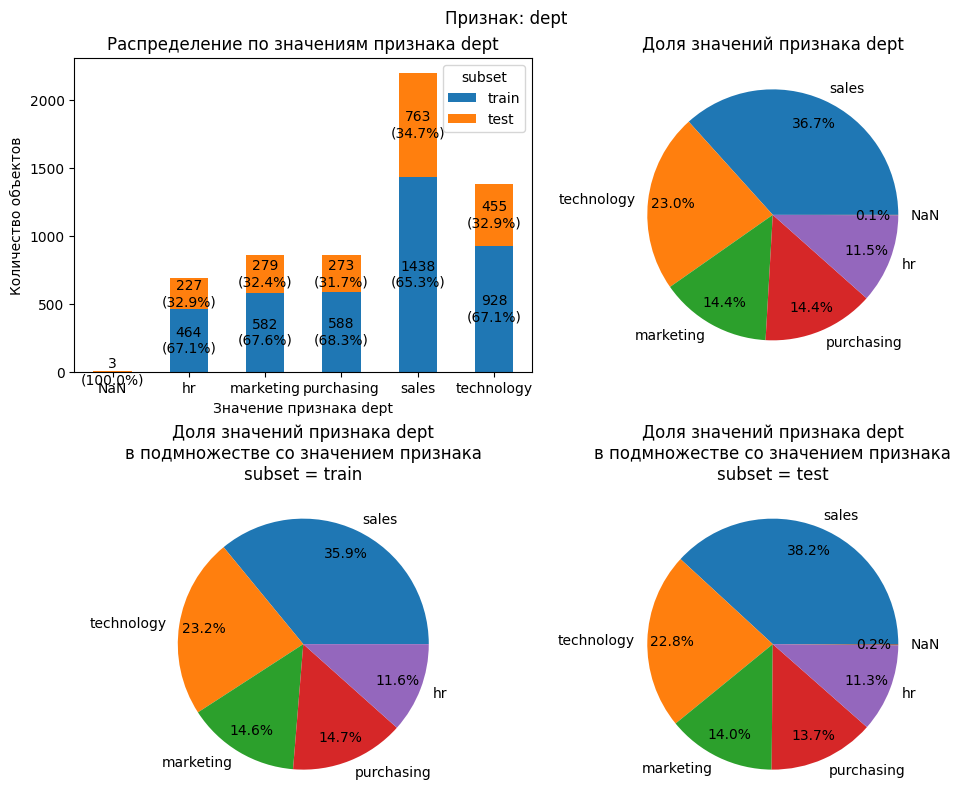

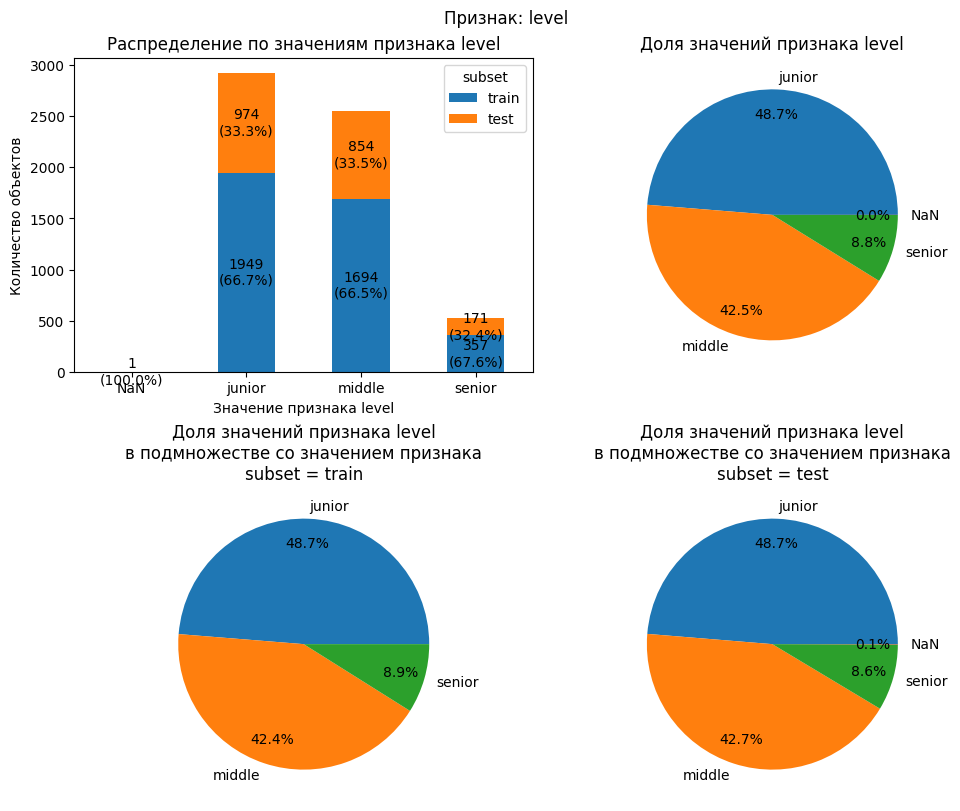

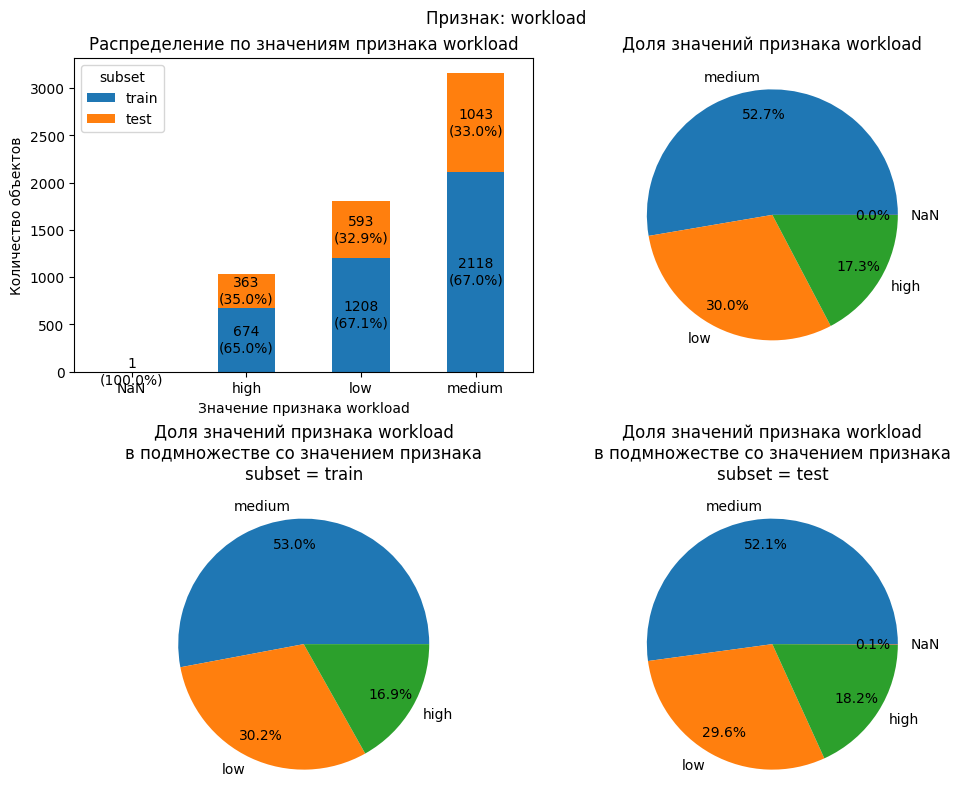

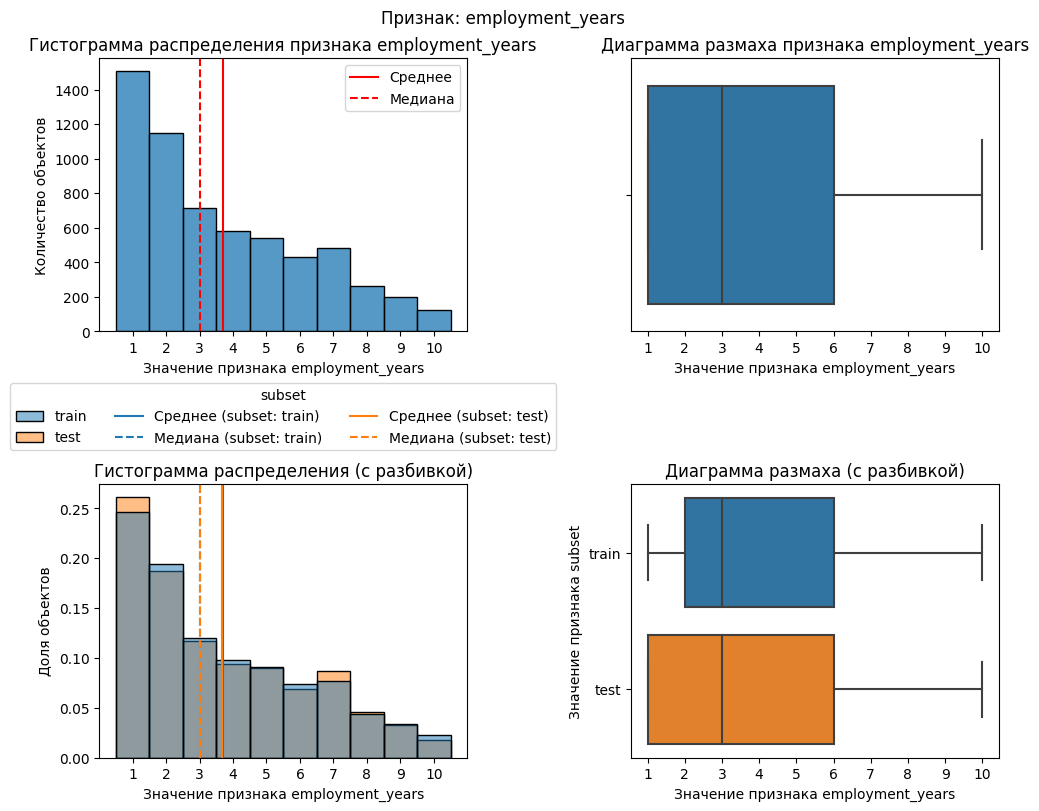

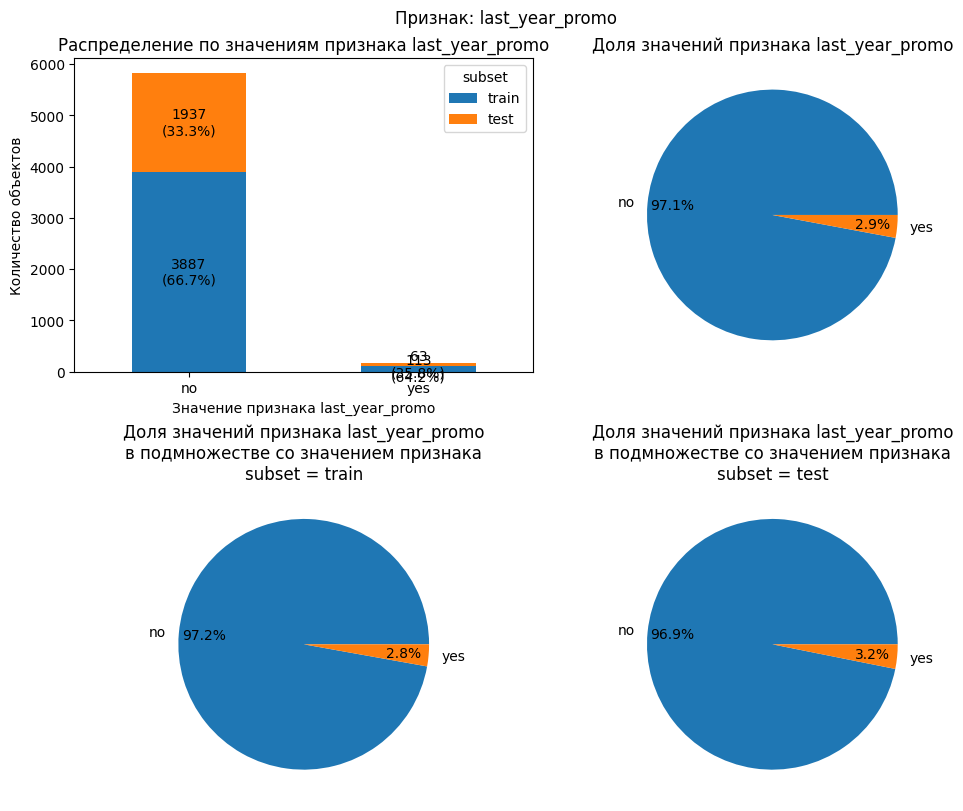

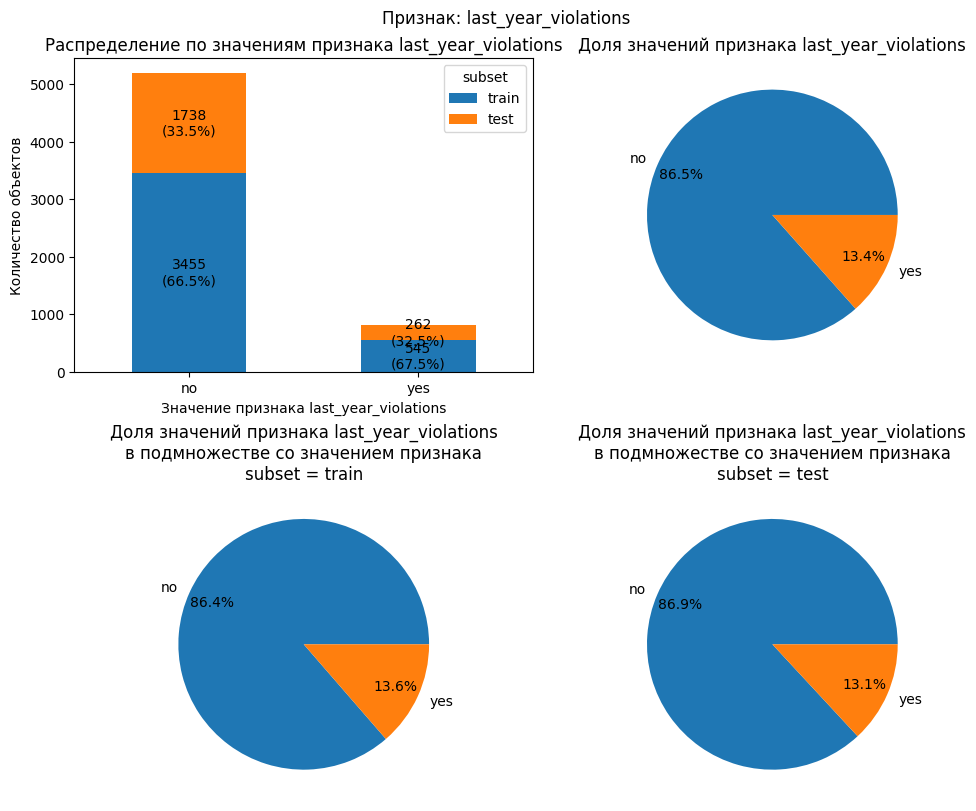

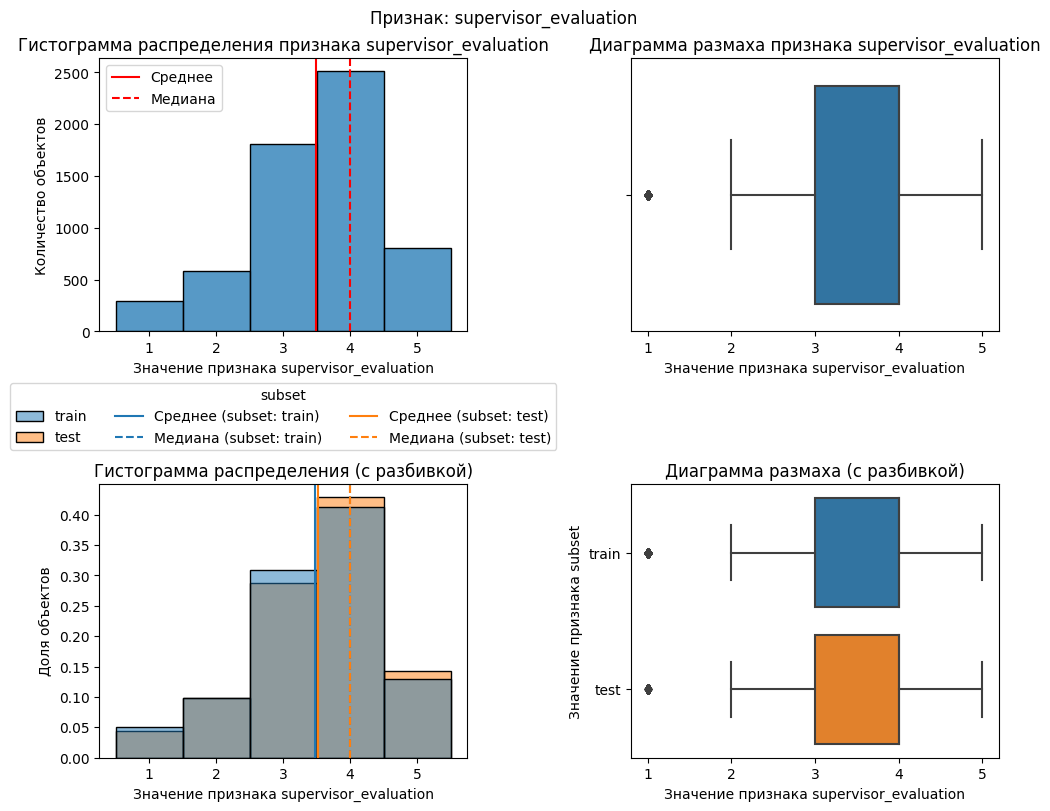

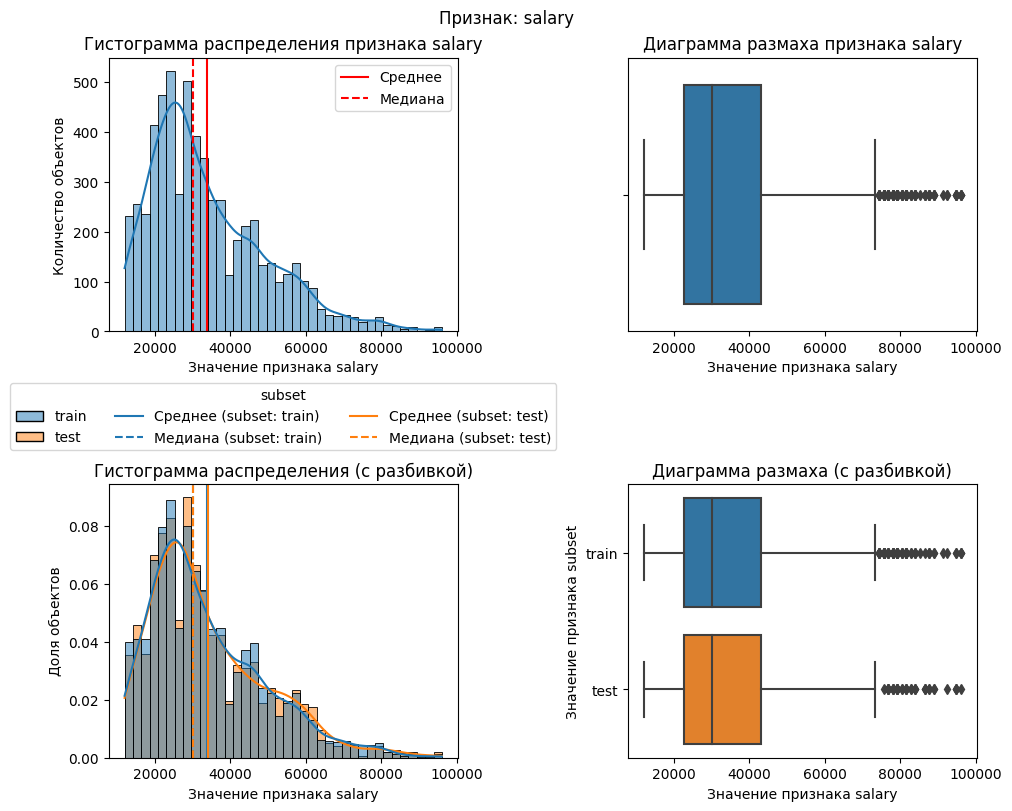

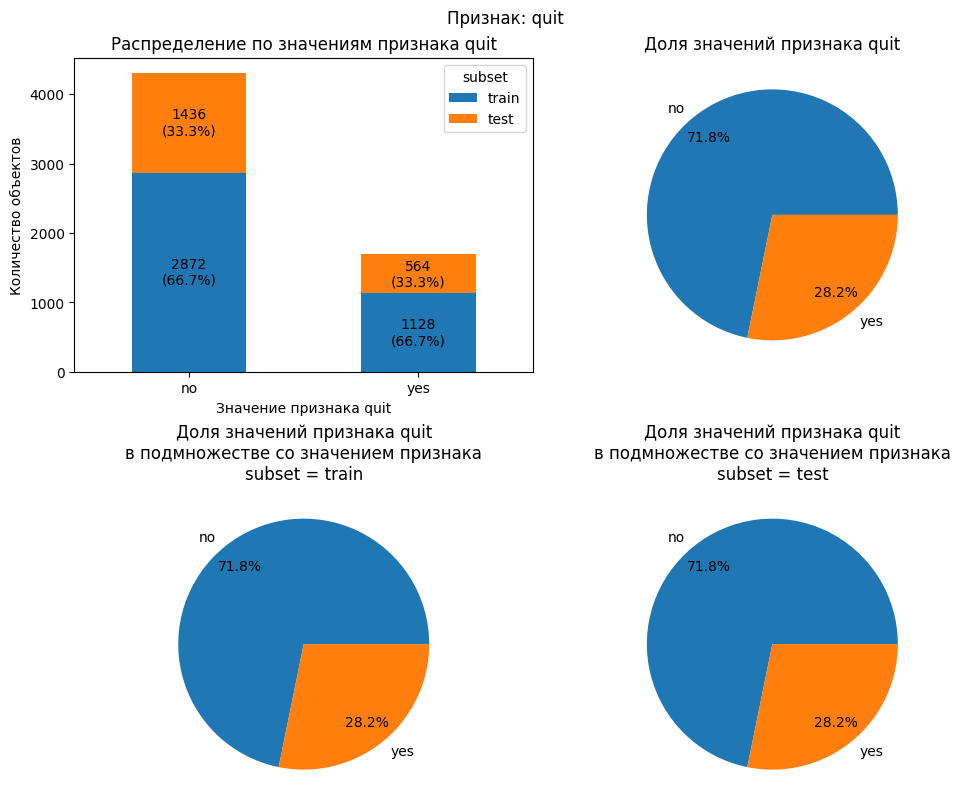

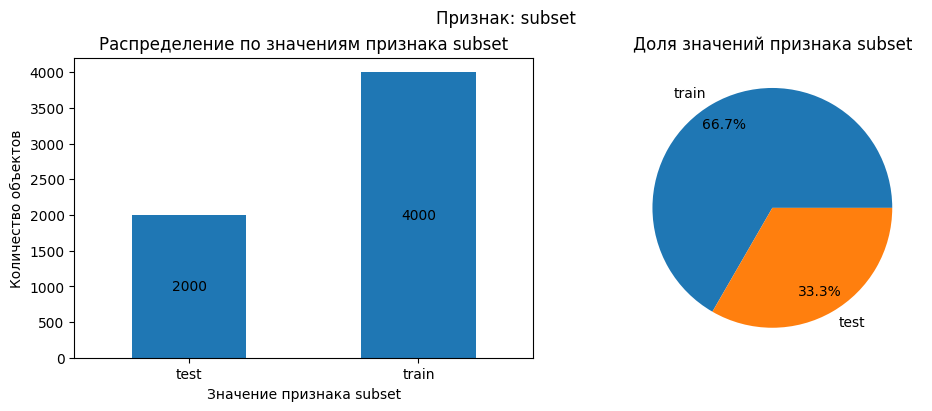

In [89]:
# строим графики для каждого признака в таблице
for feature in df_quit.columns:
    stat_plots(df_quit, feature, target='subset')

- Соотношение размеров тренировочной и тестовой выборки составляет 2 к 1.
- Распределения значений и статистические характеристики всех признаков в тренировочной и в тестовой выборке, а также в данных в целом, практически одинаковы. Значит, выборки можно считать стратифицированными по входным признакам.
- Распределение значений целевого признака `quit` в тренировочной и в тестовой выборке одинаковы. Значит, выборки можно считать стратифицированными по целевому признаку.
- Имеется дисбаланс данных по целевому признаку `quit`: доля уволившихся сотрудников составляет 28.2%. Однако степень дисбаланса умеренная и данных минорного класса должно быть достаточно для обучения моделей.
- Аномалии и выбросы в данных отсутствуют.

#### Портрет уволившегося сотрудника

Чтобы составить портрет уволившегося сотрудника, проведём анализ распределений признаков в разбивке по значению целевого признака `quit` — факту увольнения сотрудника из компании.
- Исследуем статистические характеристики количественных признаков с помощью метода `describe()`.
- Построим графики, характеризующие признаки в данных, как это было сделано выше на этапе статистического анализа данных.

In [90]:
print('в целом:')
display(df_quit.describe().T)
for quit in df_quit['quit'].unique():
    print('quit = {}:'.format(quit))
    # статистические характеристики количественных признаков
    display(df_quit.query('quit == @quit').describe().T)
    print()

в целом:


count          mean           std      min      25%  \
employment_years       6000.0      3.689833      2.540152      1.0      1.0   
supervisor_evaluation  6000.0      3.492000      1.001883      1.0      3.0   
salary                 6000.0  33892.800000  15234.077185  12000.0  22800.0   

                           50%      75%      max  
employment_years           3.0      6.0     10.0  
supervisor_evaluation      4.0      4.0      5.0  
salary                 30000.0  43200.0  96000.0

quit = yes:


count          mean          std      min      25%  \
employment_years       1692.0      1.888298     1.374751      1.0      1.0   
supervisor_evaluation  1692.0      3.044917     0.957582      1.0      3.0   
salary                 1692.0  24241.843972  9813.458139  12000.0  18000.0   

                           50%      75%      max  
employment_years           1.0      2.0     10.0  
supervisor_evaluation      3.0      4.0      5.0  
salary                 22800.0  28800.0  80400.0


quit = no:


count          mean           std      min      25%  \
employment_years       4308.0      4.397400      2.543499      1.0      2.0   
supervisor_evaluation  4308.0      3.667595      0.963701      1.0      3.0   
salary                 4308.0  37683.286908  15312.620591  12000.0  25200.0   

                           50%      75%      max  
employment_years           4.0      6.0     10.0  
supervisor_evaluation      4.0      4.0      5.0  
salary                 34800.0  46800.0  96000.0

Построим графики, которые помогут сравнить частоты, с которыми значения признаков стречаются среди уволившихся и оставшихся сотрудников.

Для категориальных признаков:
- Столбчатая диаграмма (stacked bar chart), на которой показано общее количество сотрудников с данным значением признака, а также количество и доля уволившихся и оставшихся среди них.
- Круговая диаграмма (pie chart), на которой показана доля сотрудников с данным значением признака от всего множества сотрудников.
- Отдельные для подмножеств уволившихся и оставшихся сотрудников круговые диаграммы, на которых показана доля сотрудников с данным значением признака в подмножестве.

Для количественных признаков:
- Гистограмма распределения по значениям признака количества сотрудников для всего множества сотрудников, а также соответствующая ему диаграмма размаха.
- Совмещённые гистограммы распределения по значениям признака доли сотрудников в подмножествах уволившихся и оставшихся сотрудников и соответствующие ему диаграмма размаха. Отдельная для каждого подмножества нормаировка распределений позволяет исследовать их сходство и различия вне зависимости от соотношения размеров подмножеств.

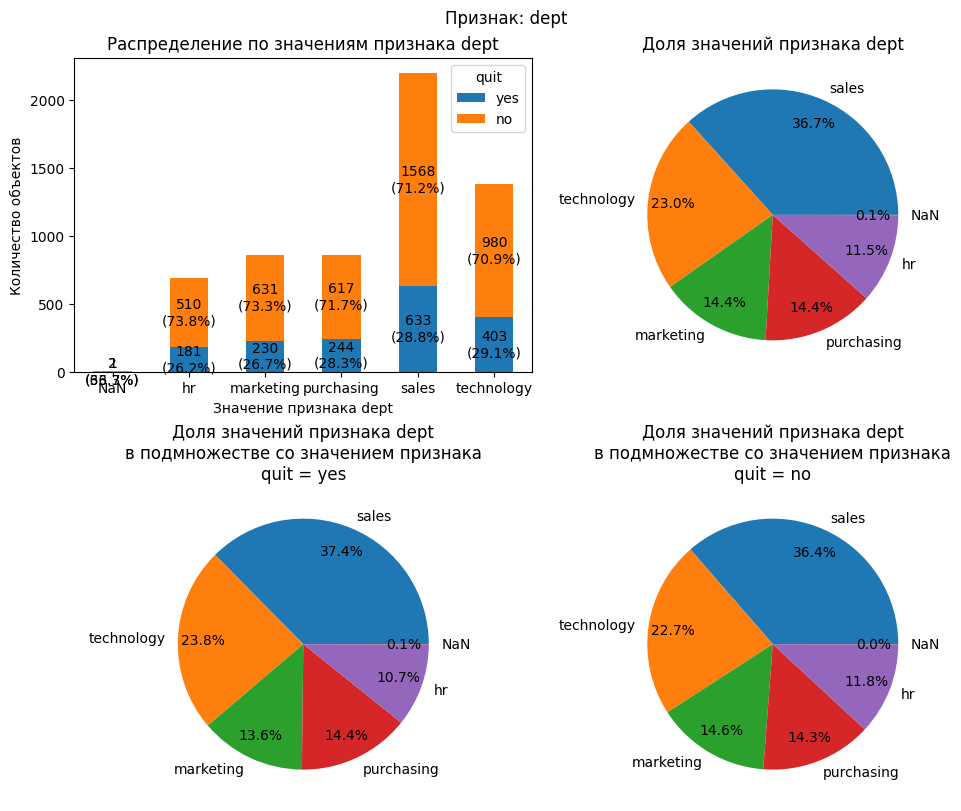

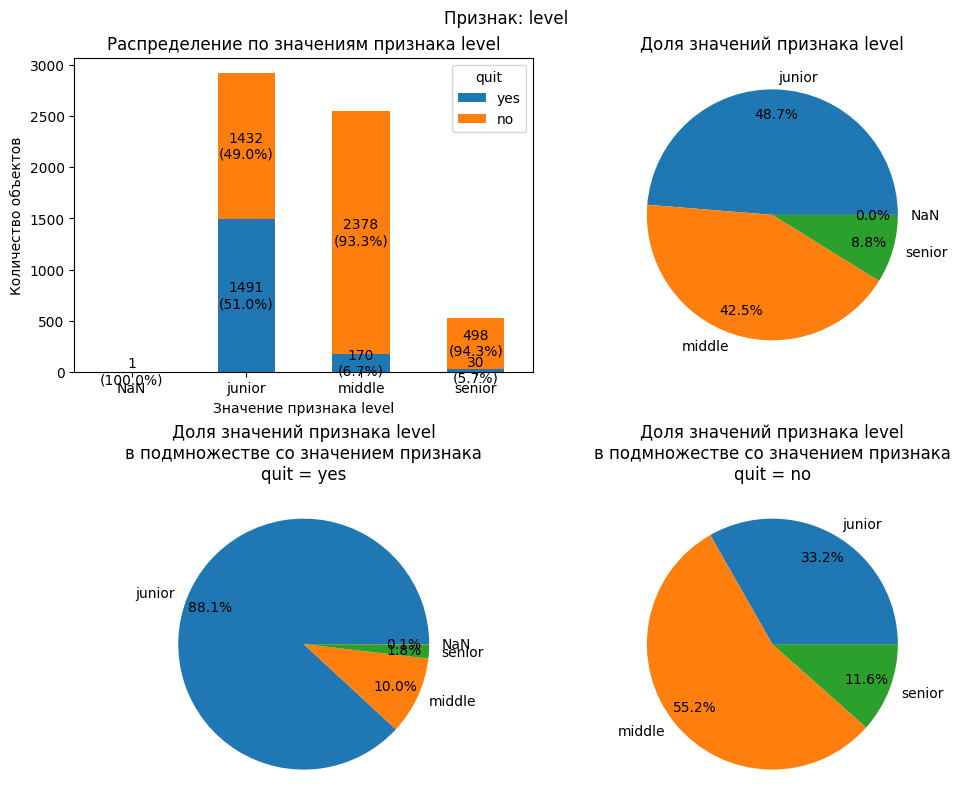

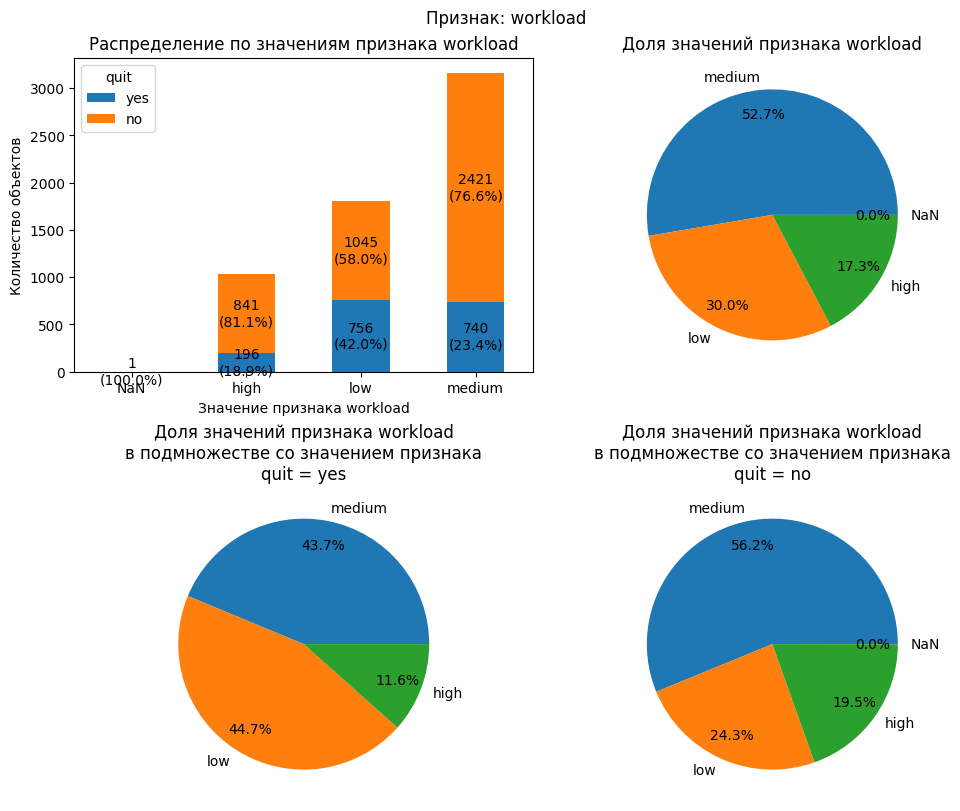

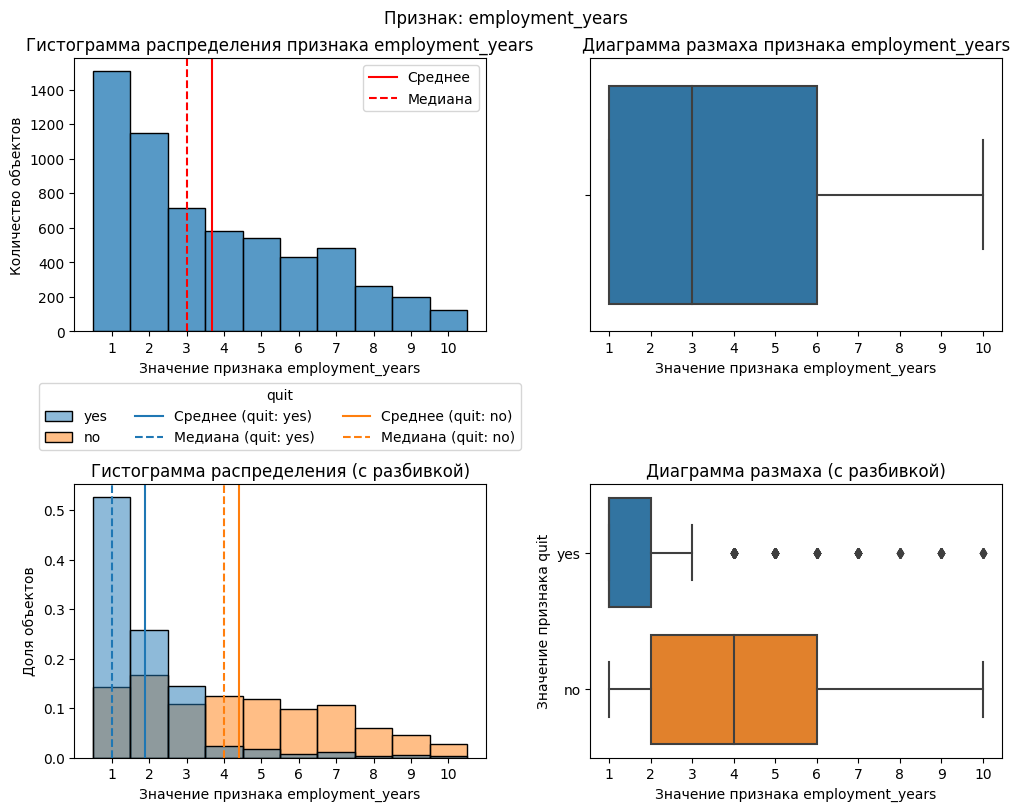

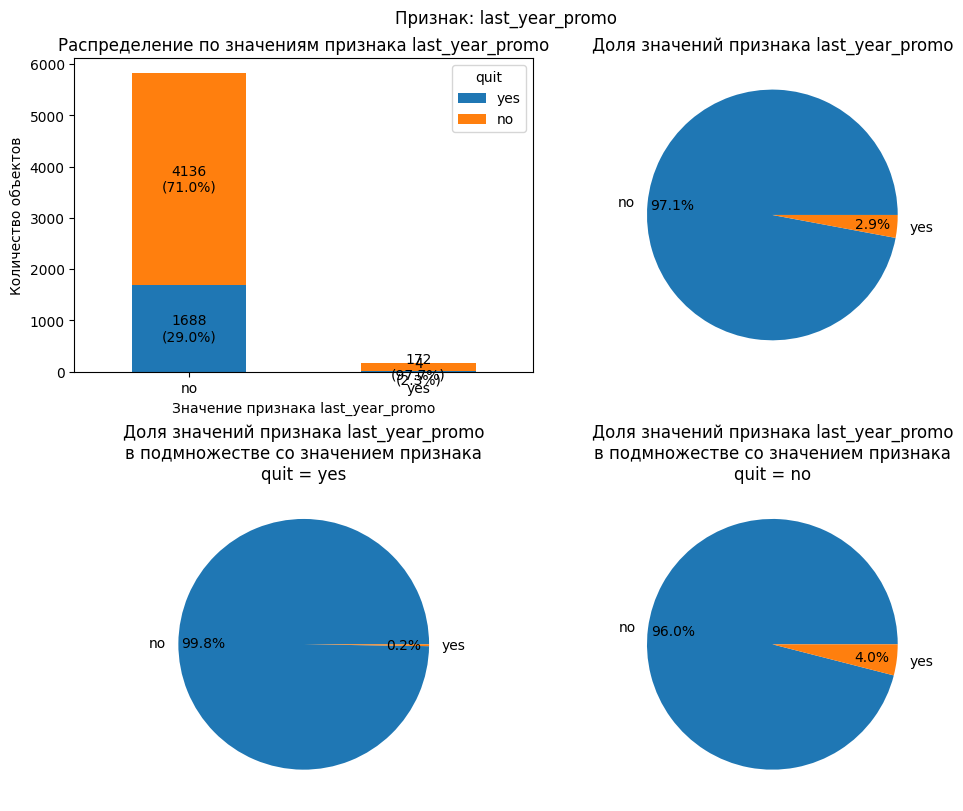

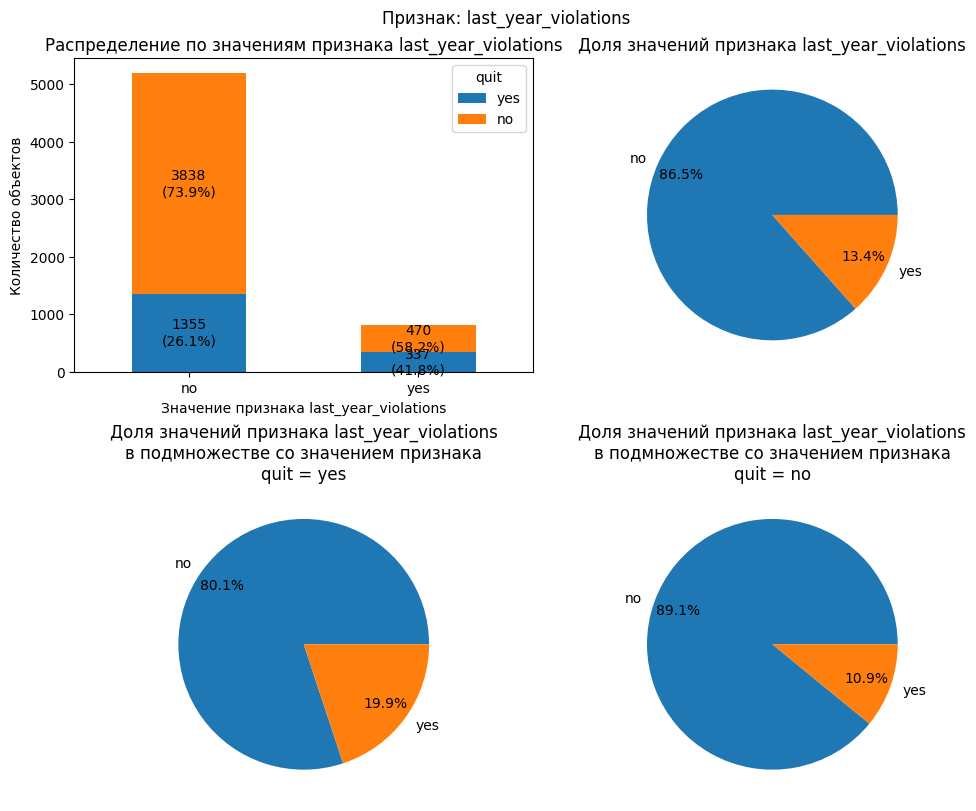

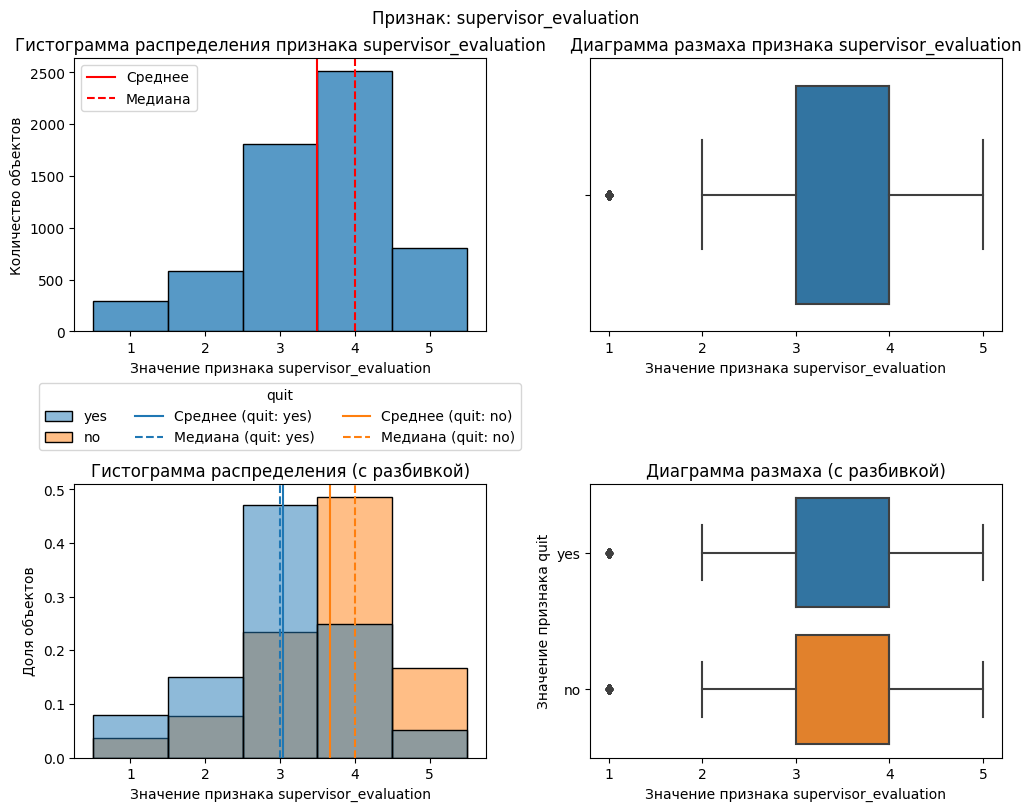

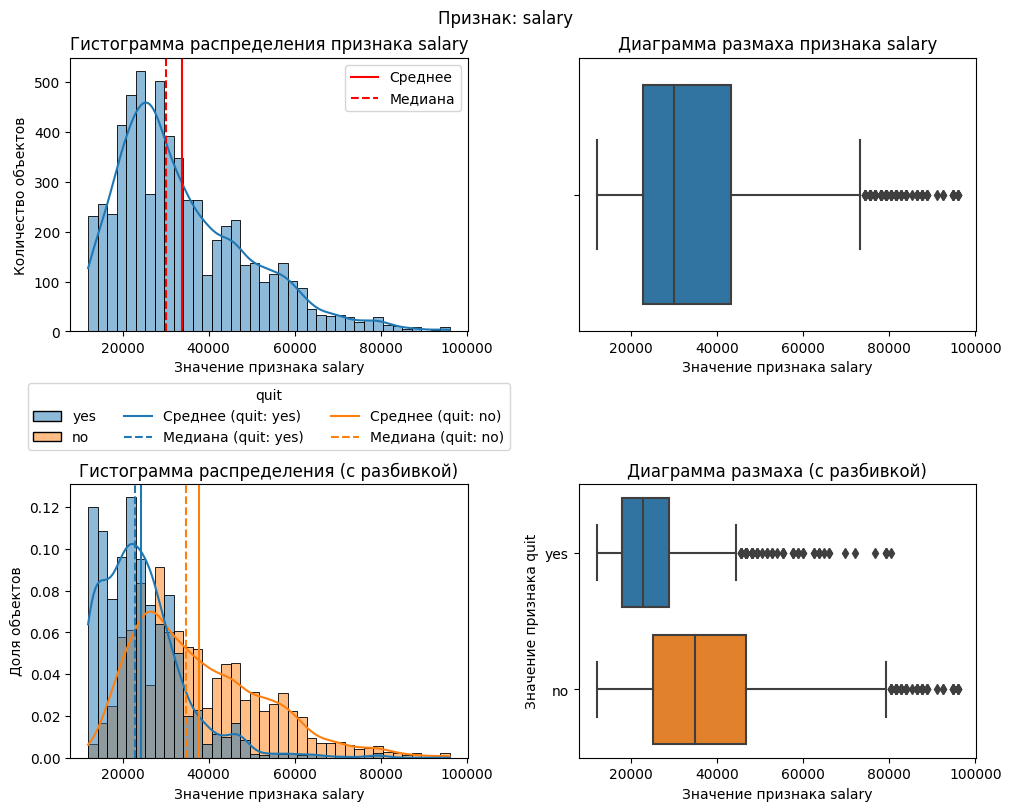

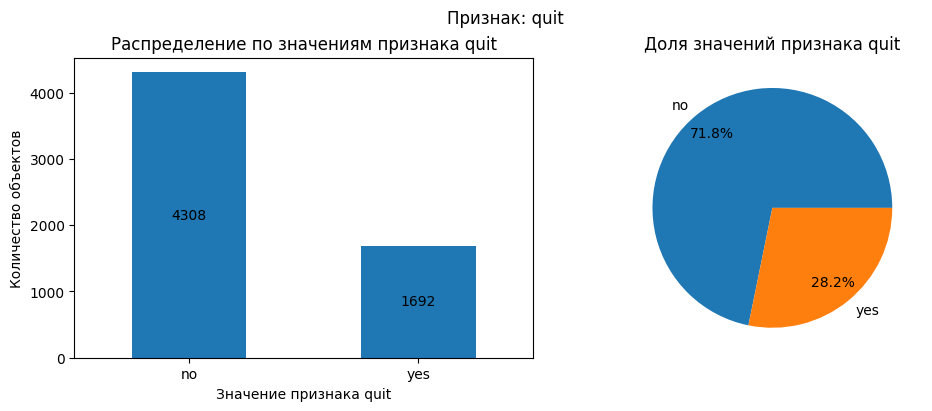

In [91]:
# строим графики для каждого признака в таблице
for feature in df_quit.columns.drop(['subset']):
    stat_plots(df_quit, feature, target='quit')

Также построим графики, которые покажут соотношение уволившихся и оставшихся сотрудников для каждого значения всех категориальных признаков в данных.

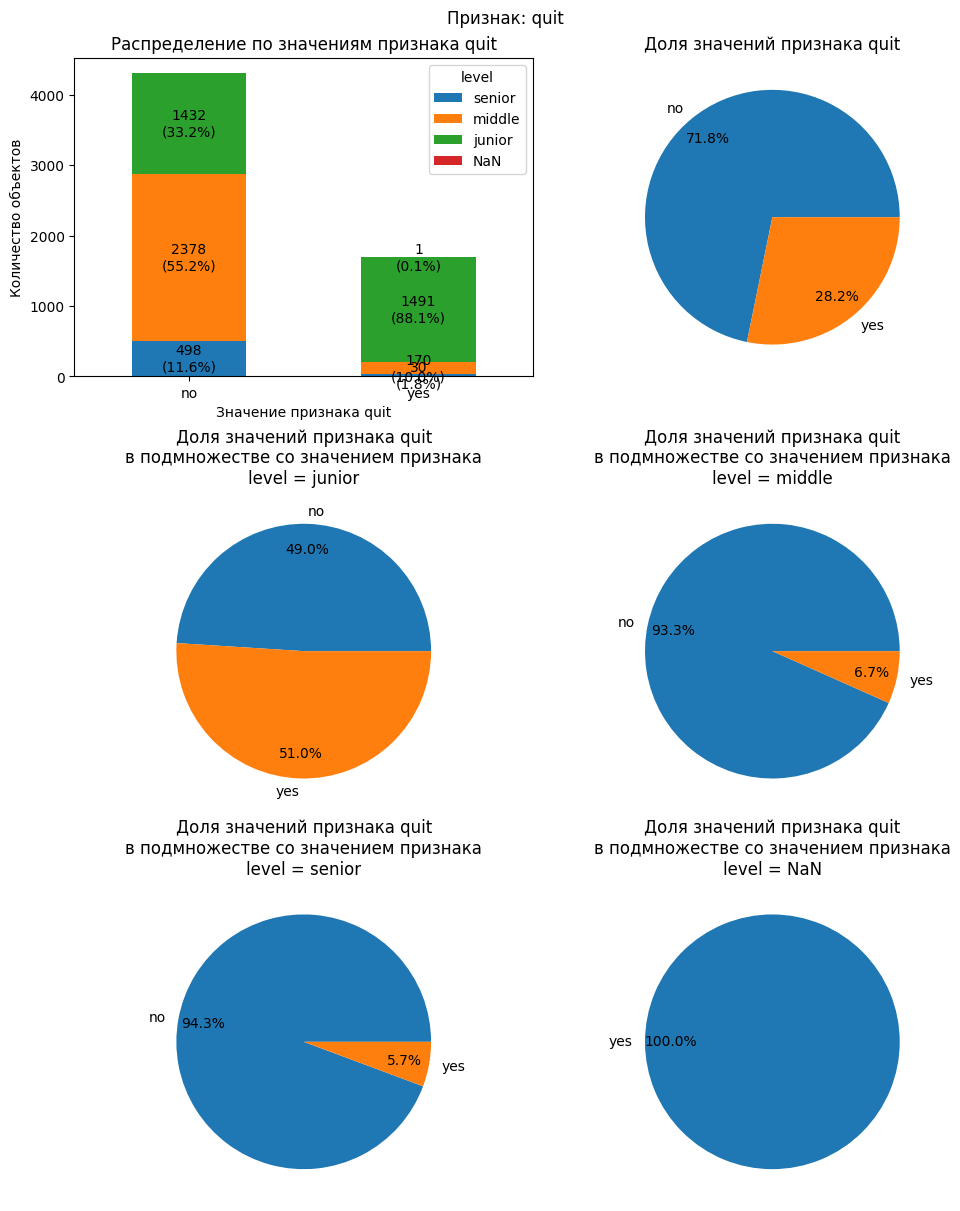

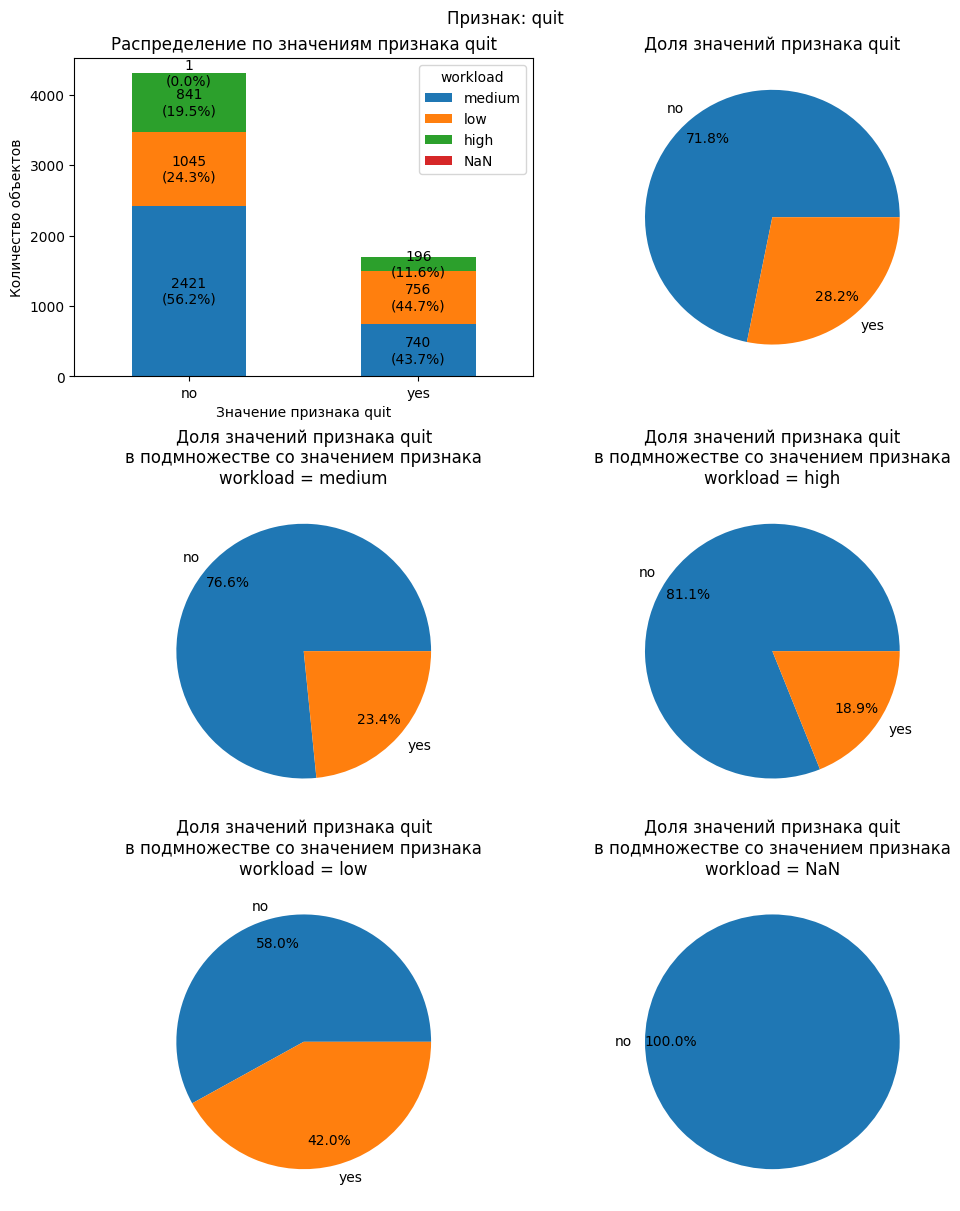

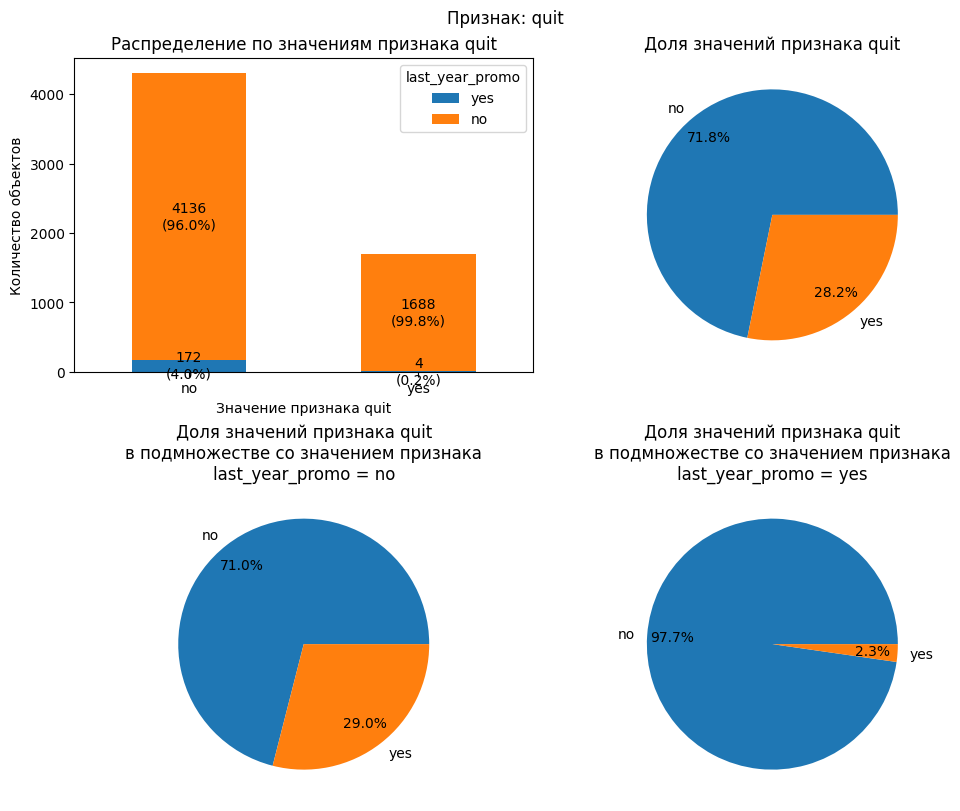

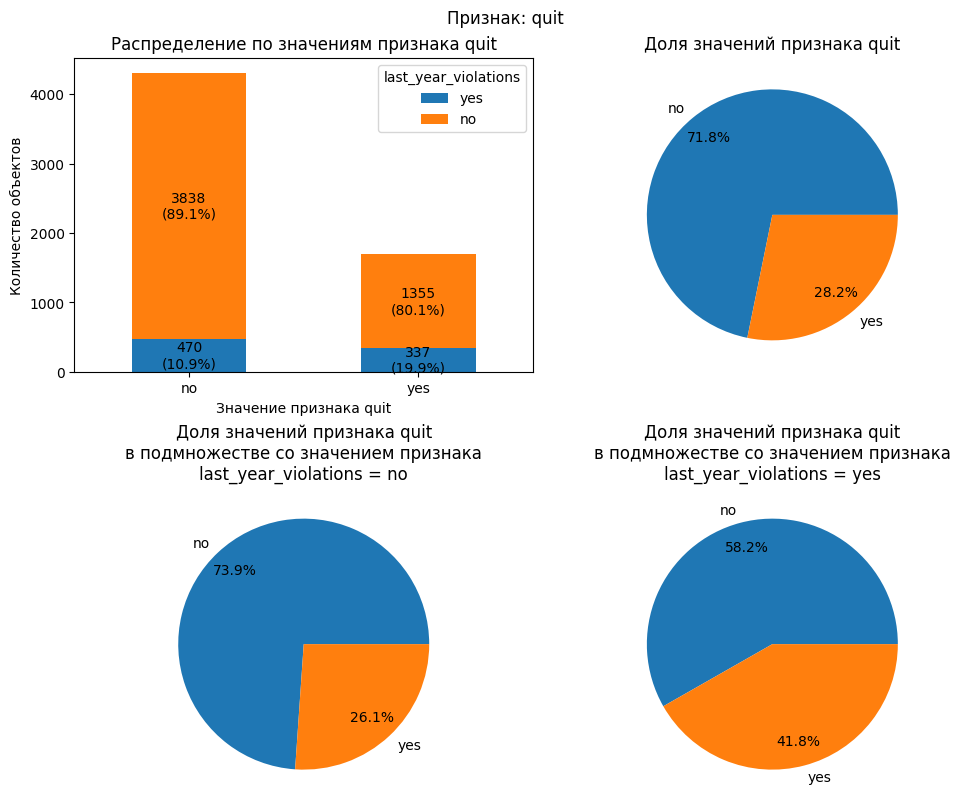

In [92]:
# категориальные признаки
cat_features = (
    df_quit
    .select_dtypes(exclude='number')
    .columns
    .drop(['quit', 'subset'])
)
# строим графики
for feature in cat_features.drop(['dept']):
    stat_plots(df_quit, 'quit', target=feature)

Для составления портрета уволившегося сотрудника будет полезно исследовать относительное распределение значений категориальных и дискретных количественных признаков в подмножестве уволившихся сотрудников.

Соответствующие кроуговые диаграммы для категориальных признаков уже были построены выше. Теперь визуализируем распределения с помощью столбчатых диаграмм.

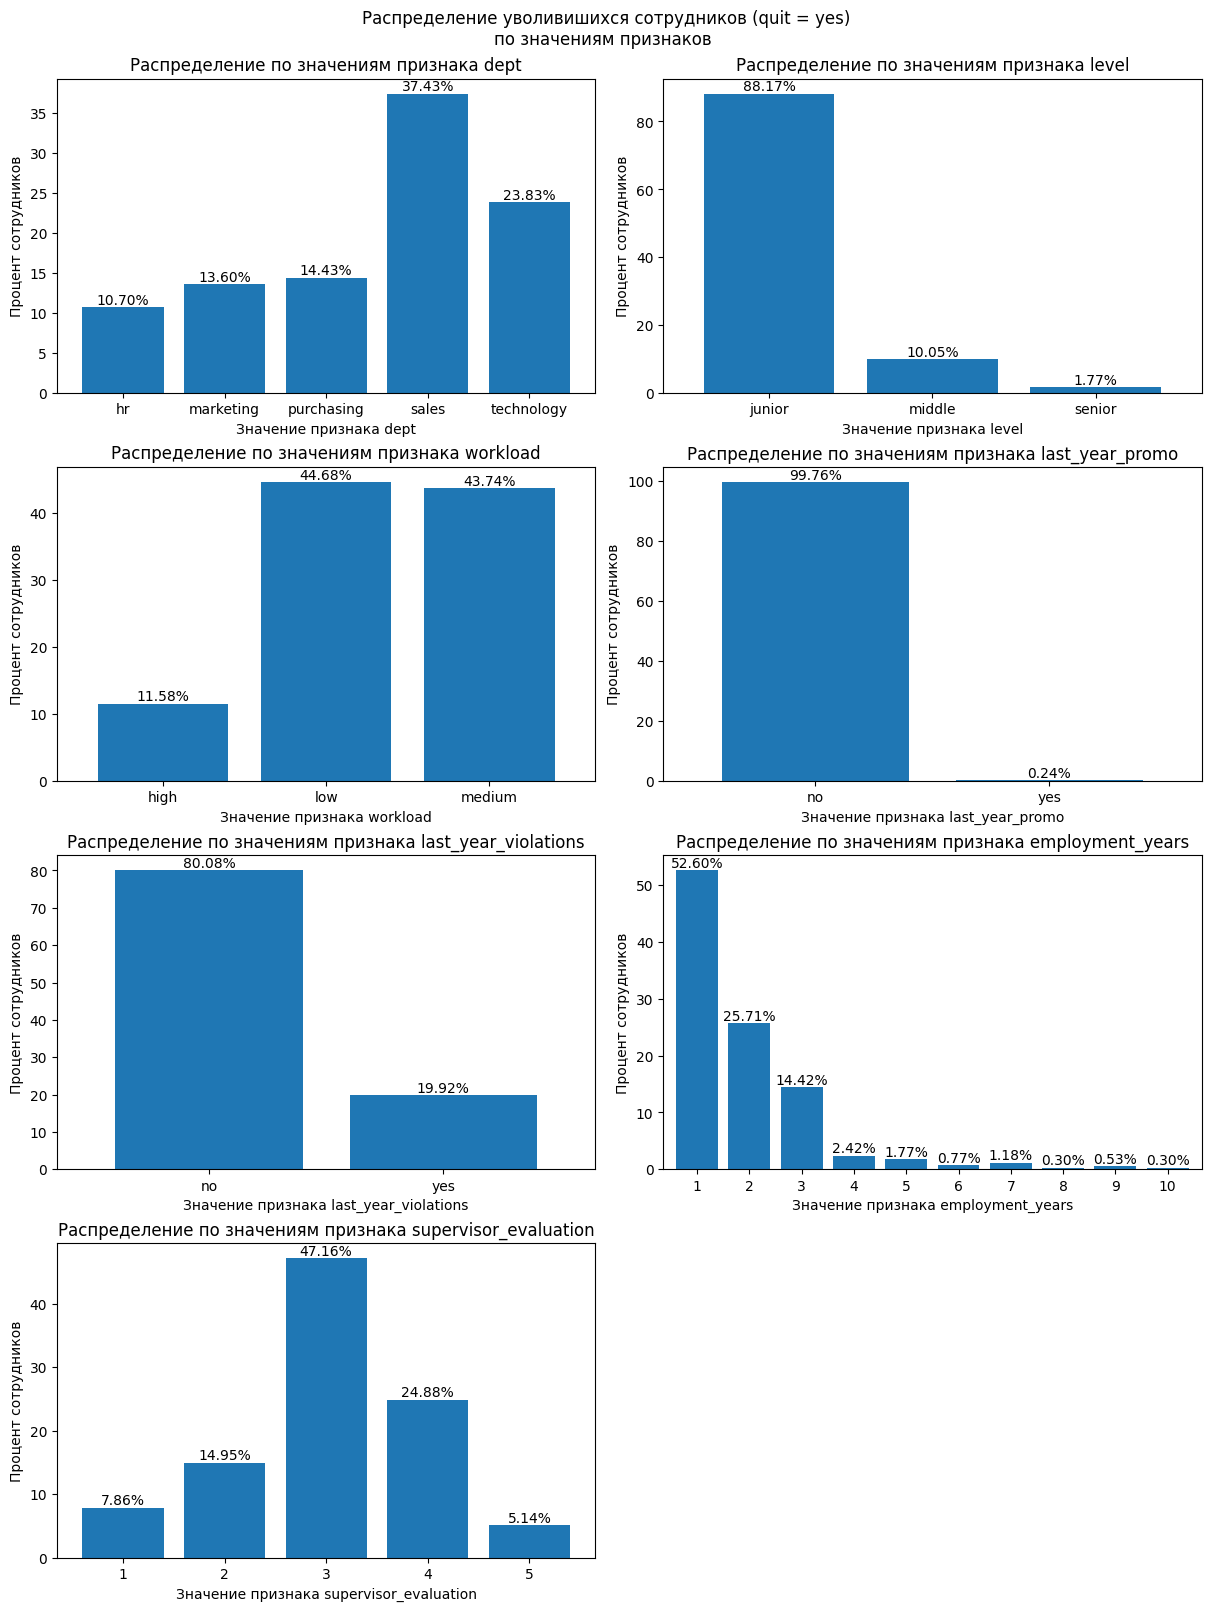

In [93]:
# список признаков для построения графиков
features_list = cat_features.tolist() + ['employment_years', 'supervisor_evaluation']

# создаём область построения графиков
nrows=len(features_list) // 2 + 1
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=2, 
    figsize=(12, nrows*4), 
    constrained_layout=True, 
)
    
# цикл по признакам в списке
for i, feature in enumerate(features_list):
    # данные для построения графика
    stat = (
        df_quit
        .query("quit == 'yes'")
        [feature]
        .value_counts(normalize=True)
        .sort_index()
        * 100
    )
    
    # индексы области построения
    r = i // 2
    c = i % 2
    # строим и оформляем график
    stat.plot.bar(rot=0, width=0.8, ax=axes[r, c])
    axes[r, c].bar_label(axes[r, c].containers[0], label_type='edge', fmt='%.2f%%')
    axes[r, c].set_title('Распределение по значениям признака ' + feature)
    axes[r, c].set_xlabel('Значение признака ' + feature)
    axes[r, c].set_ylabel('Процент сотрудников')
    
# удаляем лишние оси
if len(features_list) % 2 == 1:
    axes[nrows-1, 1].remove()
    
# заголовок
fig.suptitle('Распределение уволивишихся сотрудников (quit = yes)\nпо значениям признаков ');

Анализ показывает:
- Распределение уволившихся сотрудников по отделам примерно повторяет общее: большинство уволившихся работали в отделе продаж. Слегка выше среднего процент уволившихся в техническом отделе (29.1% против 28.2%) и в отделе продаж (28.8%), но это различие слишком мало, чтобы делать выводы о его значимости.
- Увольняются в основном сотрудники уровня junior (88% уволившихся, это 51% от всех junior-ов в данных).
- Уволившиеся сотрудники чаще всего имели низкий (43.7%) или средний (44.7%) уровень загруженности. Но доля уволившихся превышает среднюю только среди сотрудников с низким уровнем загруженности (таких 42%).
- Подавляющее большинство уволившихся (92.7%) проработали в компании не более 3 лет. Причём половина уволилась в течение первого года работы (медианное значение стажа = 1 год).
- Практически никто из уволившихся не получал повышение за последий год, что неудивительно, принимая во внимание вышеизложенные факты. Тем не менее, из не получивших уволилось всего 29%, поскольку в целом повышение получили очень немногие (3%). Зато среди получивших повышение доля уволившихся значительно ниже средней: 2.3%.
- Преобладание среди уволившихся тех, кто не допускал нарушения, также обусловлено небольшим процентом нарушавших в целом. Среди тех, кто допускал нарушения, доля уволившихся значительно больше средней: почти 42%.
- Качество работы уволившихся сотрудников их руководителем оценивалось в среднем ниже: их средняя оценка 3.04, что на 0.62 балла ниже средней оценки оставшихся в компании.
- Средняя зарплата уволившихся на 36% меньше, чем у оставшихся (24.2 тыс. против 37.7 тыс) и на 28% меньше средней по компании в целом. Медианная зарплата тоже на 7200 меньше, чем в целом по компании.

На основе результатов анализа можно составить следующий характерный **портрет уволившегося сотрудника**:
> Это начинающий сотрудник уровня junior, проработавший в компании не более 3 лет, который был слабо загружен работой и получал небольшую зарплату ниже среднего уровня. Качество его работы оставляло желать лучшего, а вероятность нарушений трудового договора с его стороны выше средней.

Таким образом, из компании в основном увольнялись начинающие сотрудники, которые либо не справлялись с работой и потеряли к ней интерес, либо их не устроил уровень зарплаты.

#### Проверка влияния уровня удовлетворённости сотрудника на факт его увольнения

Проверим предположение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Для этого сравним распределения признака `job_satisfaction_rate` для уволившихся и оставшихся сотрудников, используя данные с обоими целевыми признаками тестовой выборки.

In [94]:
# добавляем к входным признакам тестовой выборки оба целевых признака
df_test = X_test.join(y_test_jsr).join(y_test_quit)
df_test.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
100298          hr  junior      low                 2              no   
100480   marketing  junior      low                 4              no   
100503  purchasing  middle     high                 5              no   
100610       sales  middle   medium                 5              no   
100692       sales  middle     high                 6              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
100298                   no                      4   19200   
100480                   no                      4   16800   
100503                   no                      4   55200   
100610                   no                      4   43200   
100692                   no                      4   48000   

        job_satisfaction_rate quit  
id                                  
100298                   0.80   no  
100480                   0.84   no  
100503                   0.79   no  
100610                   0.75   no  
100692                   0.69   no

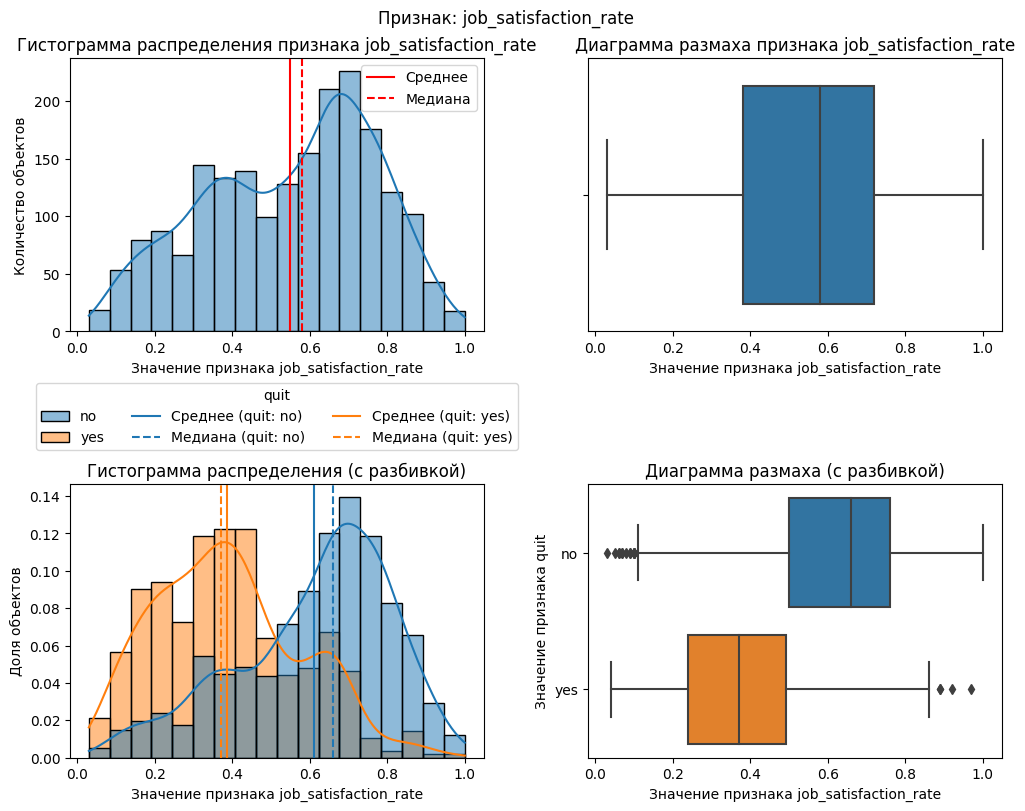

In [95]:
# строим графики
stat_plots(df_test, 'job_satisfaction_rate', target='quit');

По графикам распределений для признака `job_satisfaction_rate` (уровня удовлетворённости сотрудника работой) с разбивкой по признаку `quit` (факту увольнения сотрудника) видно, что максимум распределения для уволившихся сотрудников смещён в сторону меньших значений, также как и среднее значение, и медиана. 

Найдём средние значения уровня удовлетворённости сотрудника работой для уволившихся и оставшихся сотрудников в тестовой выборке.

In [96]:
# сводная таблица со средними значениями признака 'job_satisfaction_rate'
df_test.pivot_table(index='quit', values='job_satisfaction_rate')

job_satisfaction_rate
quit                       
no                 0.612040
yes                0.387713

Средний уровень удовлетворённости работой в тестовой выборке у уволившихся сотрудников на 0.22 ниже, чем у оставшихся. 

Проверим гипотезу о том, что наблюдаемое в тестовой выборке различие среднего уровня удовлетворённости работой между уволившимися и оставшимися сотрудниками статистически значимо.  
- Сформулируем **нулевую гипотезу**: истинные средние значения уровеня удовлетворённости работой для уволившихся и оставшихся сотрудников одинаковы.
- В качестве **альтернативной гипотезы** выберем одностороннюю: у уволившихся сотрудников уровень удовлетворённости работой меньше, чем у оставшихся.

Для проверки возможности отвергнуть нулевую гипотезу в пользу альтернативной проведём двухвыборочный t-тест для независимых выборок.
- Уровень статистической значимости зададим равным $\alpha = 0.01$, чтобы повысить значимость вывода о возможности отвергнуть нулевую гипотезу.
- Для формирования вывода о возможности отвергнуть нулевую гипотезу для заданного уровня статистической значимости $\alpha$ (`alpha`) по полученному результату t-теста (`result`) используем функцию `hypothesis_test(result, alpha)`, которая выводит статистику разности (`result.statistic`) и p-value (`result.pvalue`),  сравнивает p-value с $\alpha$ и возвращает вывод в текстовой форме.

In [97]:
# задаём уровень статистической значимости
alpha = 0.01

# формируем выборки для сравнения
jsr_yes = df_test.query("quit == 'yes'")['job_satisfaction_rate']
jsr_no = df_test.query("quit == 'no'")['job_satisfaction_rate']

# проводим t-тест для двух независимых выборок,
# не считая равными дисперсии соответствующих ген. совокупностей,
# альтернативная гипотеза - односторонняя («меньше»)
result = st.ttest_ind(
    jsr_yes, 
    jsr_no, 
    equal_var=False,
    alternative='less'
)

# выводим результат проверки гипотезы
hypothesis_test(result, alpha)

Статистика разности (t-statistic): -23.80
P-value: 1.385e-101
Уровень статистической значимости: 0.01
P-value < 0.01. Отвергаем нулевую гипотезу.


Статистический тест показал, что для заданного уровня статистической значимости можно отвергнуть нулевую гипотезу в пользу альтернативной, а значит различие истинных средних значений уровня удовлетворённости работой для уволившихся и оставшихся сотрудников статистически значимо, причём для уволившихся уровень удовлетворённости работой меньше. 

Таким образом, подтверждается предположение о влиянии удовлетворённости работой на то, уволится ли сотрудник.

#### Выводы

1. Исследовательский анализ данных показал:
    - Тренировочную и тестовую выборки можно считать стратифицированными по всем признакам, включая целевой. Распределения значений всех признаков в них, а также в данных в целом, практически одинаковы.
    - Аномалии и выбросы в данных отсутствуют.
    - Имеется дисбаланс данных по целевому признаку, однако степень дисбаланса умеренная и данных минорного класса должно быть достаточно для обучения моделей.
    
2. Составлен характерный портрет уволившегося сотрудника:
> Это начинающий сотрудник уровня junior, проработавший в компании не более 3 лет, который был слабо загружен работой и получал небольшую зарплату ниже среднего уровня. Качество его работы оставляло желать лучшего, а вероятность нарушений трудового договора с его стороны выше средней.

   Таким образом, из компании в основном увольнялись начинающие сотрудники, которые либо не справлялись с работой и потеряли к ней интерес, либо их не устроил уровень зарплаты.
   
3. Подтверждено предположение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Статистический тест показал, что среднее значение уровня удовлетворённости работой для уволившихся сотрудников статистически значимо меньше, чем у оставшихся.

### Добавление нового признака

#### Добавление нового признака

Поскольку утверждение о влиянии уровня удовлетворённости сотрудника на факт его увольнения подтвердилось, добавим признак `job_satisfaction_rate_pred` — предсказанные лучшей моделью значения уровня удовлетворённости сотрудника, к входным признакам тренировочной выборки `df_train_quit` в задаче предсказания увольнения сотрудника из компании.

In [98]:
# обучаем пайплайн лучшей модели на тренировочной выборке первой задачи
best_pipe_svr.fit(X_train_jsr, y_train_jsr)

# делаем предсказания на тренировочной выборке второй задачи
jsr_pred_train = best_pipe_svr.predict(df_train_quit)

# добавляем новый признак в тренировочную выборку второй задачи,
# ограничивая диапазон значений интервалом [0, 1],
# чтобы столбец с новым признаком был предпоследним
df_train_quit.insert( 
    len(df_train_quit.columns) - 1,
    'job_satisfaction_rate_pred',
    jsr_pred_train.clip(min=0, max=1)
)
# первые 5 строк таблицы
df_train_quit.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
100222       sales  junior   medium                 3              no   
100459  purchasing  junior   medium                 3              no   
100469   marketing  junior   medium                 1              no   
100601  technology  middle     high                 4              no   
100858       sales  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
100222                   no                      2   20400   
100459                   no                      3   21600   
100469                   no                      4   28800   
100601                   no                      4   68400   
100858                   no                      4   25200   

        job_satisfaction_rate_pred quit  
id                                       
100222                    0.415829  yes  
100459                    0.384501  yes  
100469                    0.650615   no  
100601                    0.769573   no  
100858                    0.775038  yes

К входным признакам тестовой выборки также добавим предсказанные лучшей моделью значения уровня удовлетворённости сотрудника. Чтобы корректно оценить качество модели, предсказывающей увольнение сотрудника, не следует использовать в качестве входного признака во второй задаче известные данные из датасета с целевым признаком в первой задаче, т.к. для новых сотрудников не будет известных заранее значений признака.

In [99]:
# делаем предсказания на тестовой выборке
jsr_pred_test = best_pipe_svr.predict(X_test)

# добавляем новый признак в тестовую выборку,
# ограничивая диапазон значений интервалом [0, 1]
X_test['job_satisfaction_rate_pred'] = jsr_pred_test.clip(min=0, max=1)
# первые 5 строк таблицы
X_test.head()

dept   level workload  employment_years last_year_promo  \
id                                                                      
100298          hr  junior      low                 2              no   
100480   marketing  junior      low                 4              no   
100503  purchasing  middle     high                 5              no   
100610       sales  middle   medium                 5              no   
100692       sales  middle     high                 6              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
100298                   no                      4   19200   
100480                   no                      4   16800   
100503                   no                      4   55200   
100610                   no                      4   43200   
100692                   no                      4   48000   

        job_satisfaction_rate_pred  
id                                  
100298                    0.852208  
100480                    0.763712  
100503                    0.725010  
100610                    0.816563  
100692                    0.687950

Проверим, насколько отличается распределение предсказанных моделью значений признака в тренировочной и тестовой выборках. Для этого объединим их в одну таблицу, пометив соответствующим образом тренировочные и тестовые данные.

In [100]:
# объединяем таблицы
df_quit = pd.concat([
    # помечаем тренировочную выборку значением 'train' в столбце 'subset'
    df_train_quit.assign(subset='train'),
    # присоединяем к тестовой выборке целевый признак и
    # помечаем тестовую выборку значением 'test' в столбце 'subset'
    X_test.join(y_test_quit, how='inner').assign(subset='test')
])

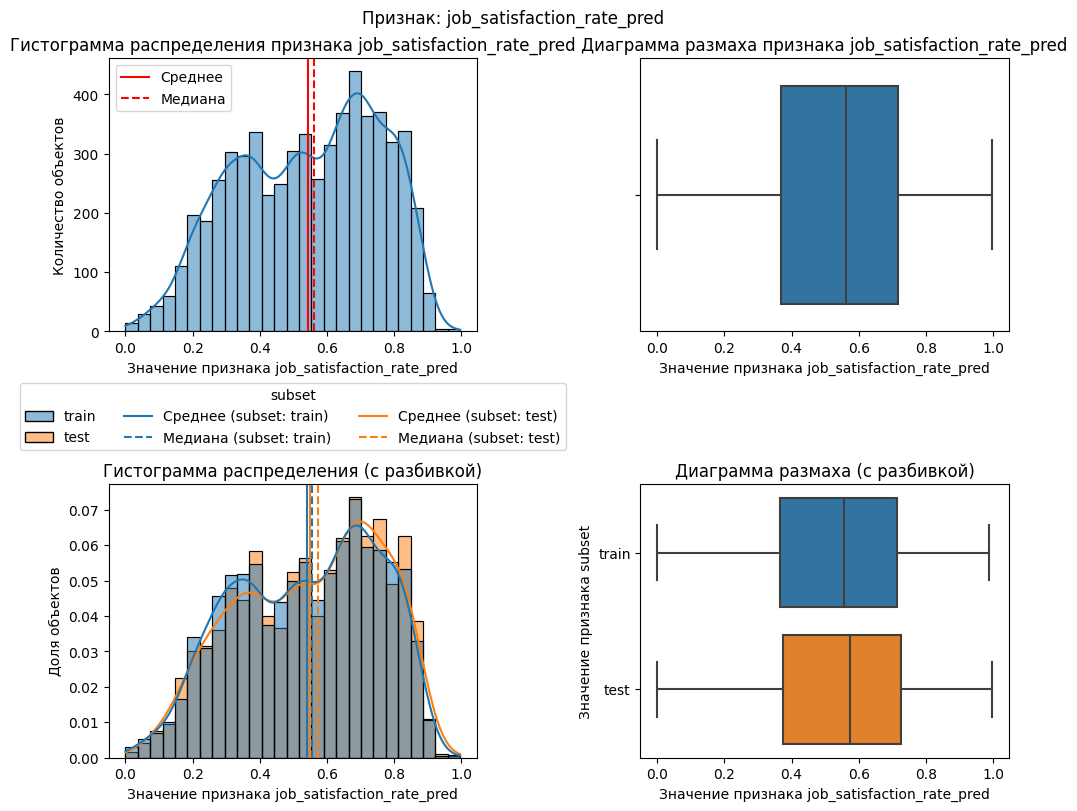

In [101]:
# строим графики
stat_plots(df_quit, 'job_satisfaction_rate_pred', target='subset');

Распределения признака `job_satisfaction_rate_pred` в тренировочной и тестовой выборках довольно близки, средние значения признака в них практически совпадают.

#### Корреляционный анализ данных

После добавления нового признака нужно исследовать степень связи входных признаков друг с другом, чтобы  определить характер и силу связи между каждым из входных признаков и целевым признаком, а также проверить входные признаки на мультиколлинеарность. Для этого рассчитаем матрицу корреляции признаков и визуализируем её в виде тепловой карты.

Качество и интерпретируемость линейных ML моделей может пострадать из-за мультиколлинеарности между входными признаками, т.е. если между ними есть сильная линейная связь. Степень линейной связи между количественными признаками покажет корреляция Пирсона. 

Анализ корреляций проведём для тренировочной и тестовой выборки отдельно, чтобы убедиться, что между ними нет существенных различий связи признаков. Если это так, то оценка качества ML модели, полученная на тестовой выборке, будет корректной.

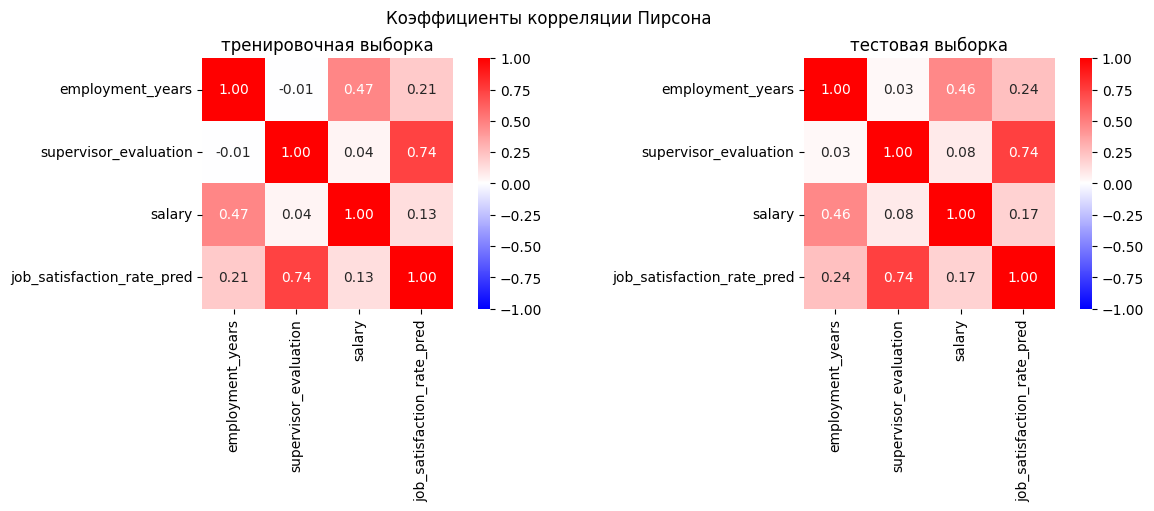

In [102]:
# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True)

plt.sca(axes[0])
# строим матрицу корреляции
# для тренировочной выборки
corr_matrix(df_train_quit)
title = axes[0].get_title()
axes[0].set_title('тренировочная выборка')

plt.sca(axes[1])
# строим матрицу корреляции
# для тестовой выборки
corr_matrix(X_test)
axes[1].set_title('тестовая выборка')

fig.suptitle(title);

- Значения коэффициентов корреляции Пирсона между количественными признаками не превышают 0.74. Значит, мультиколлинеарности нет.
- Коэффициенты корреляции признаков в тренировочной и тестовой выборках близки, их разница не превышает 0.04.

Для анализа связи целевого признака `quit` с входными признаками (что важно для проверки на утечку целевого признака), а также проверки категориальных признаков на мультиколлинеарность, рассчитаем коэффициенты корреляции фи ($\phi_k$) для всех признаков. Для этого используем метод `phik_matrix()` из библиотеки `phik`.

При использовании `phik_matrix()` нужно передать ему в аргументе `interval_cols`  список с названиями **непрерывных количественных признаков**, т.к. от типа признака зависит метод оценки корреляции. В анализируемых данных такими признаками являются `salary` и `job_satisfaction_rate_pred`. 

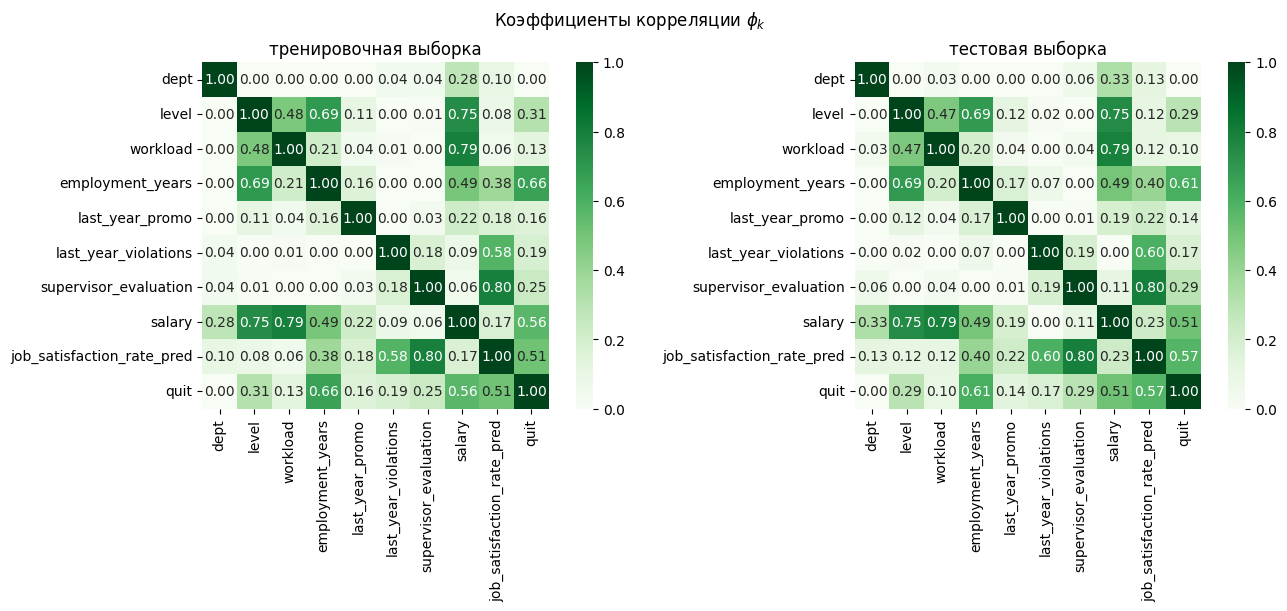

In [103]:
# список непрерывных количественных признаков
interval_cols = ['salary', 'job_satisfaction_rate_pred']

# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), constrained_layout=True)

plt.sca(axes[0])
# строим матрицу корреляции
# для тренировочной выборки
corr_matrix(df_train_quit, method='phik', interval_cols=interval_cols)
title = axes[0].get_title()
axes[0].set_title('тренировочная выборка')

plt.sca(axes[1])
# строим матрицу корреляции
# для тестовой выборки
corr_matrix(X_test.join(y_test_quit), method='phik', interval_cols=interval_cols)
axes[1].set_title('тестовая выборка')

fig.suptitle(title);

- Значения коэффициентов корреляции $\phi_k$ между признаками не превышают 0.8. Значит, мультиколлинеарности и утечки целевого признака нет.
- Коэффициенты корреляции $\phi_k$ в тренировочной и тестовой отличаются близки. Максимальная разница коэффициентов корреляции между выборками не превышает 0.09 (признаки `last_year_violations` и `salary`). Коэффициенты корреляции входных признаков с целевым признаком `quit` отличаются не более чем на 0.07 (новый признак `job_satisfaction_rate_pred`).

#### Выводы

1. К входным признакам в задаче предсказания увольнения сотрудника из компании добавлен новый признак `job_satisfaction_rate_pred` — значения уровня удовлетворённости сотрудника, предсказанные лучшей моделью из задачи предсказания уровня удовлетворённости сотрудника.
    - Новый признак добавлен в тренировочную выборку `df_train_quit` и в тестовую выборку `X_test`.
    - Распределения предсказанных моделью значений признака в тренировочной и тестовой выборках оказались очень похожи.

2. Корреляционный анализ признаков показал:
    - Мультиколлинеарность между входными признаками отсутствует.
    - Различия между величинами коэффициентов корреляции признаков в тренировочной и тестовой выборках не значительны. Поэтому оценка качества ML модели, полученная на тестовой выборке, будет корректной.
    - Наиболее заметная связь с целевым признаком `quit` у признаков `employment_years` (длительность работы в компании в годах), `salary` (ежемесячная зарплата сотрудника) и `job_satisfaction_rate_pred`. Судя по характеру распределений, изученных на этапе исследовательского анализа, высокой вероятности увольнения соответствуют низкие значения этих признаков.
    - Корреляция между признаком `dept` (отдел) и целевым признаком отсутствует. Значит, этот признак — потенциальный кандидат на удаление при настройке ML моделей как самый малозначимый.

### Подготовка данных

#### Проверка на дубликаты

Перед обучением модели на данных их нужно проверить на наличие дубликатов — записей с одинаковым набором признаков. Наличие таких дубликатов в тренировочной выборке не только не принесёт пользы при обучении модели, а даже может навредить. Поэтому при обнаружении их следует удалить.

In [104]:
print(
    'Количество дубликатов в тренировочной выборке:', 
    df_train_quit.duplicated().sum()
)

Количество дубликатов в тренировочной выборке: 1413


Обнаружено много дубликатов. Удалим их.

In [105]:
# удаляем дубликаты
df_train_quit = df_train_quit.drop_duplicates()
print('Количество записей в тренировочной выборке:',len(df_train_quit))

Количество записей в тренировочной выборке: 2587


#### Преобразование данных

Подготовим данные для обучения и проверки качества ML моделей:
- Выделим из тренировочной выборки `df_train_quit` входные признаки в переменную `X_train_quit` и целевой признак `quit` в переменную `y_train_quit`. 
- Преобразуем целевой признак `quit` тестовой выборки в переменной `y_test_quit` из датафрейма в ряд (`pandas.Series`).
- Закодируем бинарный целевой признак `quit` (значения `no`/`yes`) в тренировочной и тестовой выборках с помощью `LabelEncoder`.

In [106]:
# входные признаки тренировочной выборки
X_train_quit = df_train_quit.drop(columns='quit', errors='ignore')

# создаём экземпляр класса LabelEncoder
label_encoder = LabelEncoder()
# кодируем целевой признак тренировочной выборки
y_train_quit = label_encoder.fit_transform(df_train_quit['quit'])
# кодируем целевой признак тестовой выборки
y_test_quit = label_encoder.transform(y_test_quit['quit'])

In [107]:
# проверяем соответствие кодированных значений целевого признака
target_classes = label_encoder.classes_
pd.DataFrame(range(len(target_classes)), index=target_classes, columns=['значение'])

значение
no          0
yes         1

Таким образом, старший класс ("1") соответствует значению `yes`, т.е увольнению сотрудника из компании.

#### Сборка пайплайна

Обновим списки входных признаков для кодирования и масштабирования. 
- Добавим в список количественных признаков для масштабирования новый входной признак `job_satisfaction_rate_pred`. Как было установлено ранее, распределение этого признака в принципе имеет сходство с нормальным, поэтому для него подойдёт заданный в пайплайне скейлер `StandardScaler`.

In [108]:
# добавляем новый признак в список количественных признаков,
# если его там ещё нет
if 'job_satisfaction_rate_pred' not in num_columns:
    num_columns.append('job_satisfaction_rate_pred')

# выводим списки исходных входных признаков и их количество
print('Категориальные признаки для кодирования OneHotEncoder:', ohe_columns)
print('Категориальные признаки для кодирования OrdinalEncoder:', ord_columns)
print('Количественные признаки для масштабирования:', num_columns)
print()
print('Всего {} исходных входных признаков, из них {} количественных и {} категориальных.'
      .format(len(num_columns + cat_columns),
              len(num_columns),
              len(cat_columns)
             ),
     )

Категориальные признаки для кодирования OneHotEncoder: ['dept', 'last_year_promo', 'last_year_violations']
Категориальные признаки для кодирования OrdinalEncoder: ['level', 'workload']
Количественные признаки для масштабирования: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

Всего 9 исходных входных признаков, из них 4 количественных и 5 категориальных.


Модифицируем пайплайн для подготовки данных и обучения ML моделей.
- Добавим в итоговый пайплайн селектор признаков `SelectKBest` для удаления признаков с низкой значимостью. В исходных данных 9 входных признаков, а после кодирования категориальных признаков с помощью `OneHotEncoder` их станет 12. По умолчанию селектор оставляет все входные признаки.
- Предсказание бинарной величины — это задача бинарной классификации. В качестве базовой ML модели возьмём логистическую регрессию `LogisticRegression`. Чтбы можно было применять к модели оба типа регуляризации (L1 и L2), используем солвер `liblinear`, при этом также нужно задать параметр `random_state` для воспроизводимости. Для учёта дисбаланса классов используем взвешивание классов с помощью аргумента `class_weight='balanced'`.

In [109]:
# модифицируем пайплайн
final_pipe.set_params(
    # задаём селектор признаков
    feature_selector = SelectKBest(score_func=f_classif, k='all'),
    # изменяем тип модели в пайплайне
    model = LogisticRegression(
        solver='liblinear', 
        class_weight='balanced',
        random_state=RANDOM_STATE
    )
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate_pred'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', SelectKBest(k='all')),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

#### Выводы

- Из тренировочной выборки удалены обнаруженные дубликаты — записи с одинаковым набором признаков. Наличие таких дубликатов в тренировочной выборке не принесло бы пользы при обучении модели, а даже могло навредить.

- Входные признаки и целевой признак тренировочной выборки выделены в отдельные переменные. Целевой признак тестовой выборки преобразован из датафрейма в ряд (`pandas.Series`).

- Бинарный целевой признак `quit` (значения `no`/`yes`) в тренировочной и тестовой выборках закодирован с помощью `LabelEncoder` таким образом, что старший класс ("1") соответствует значению `yes`, т.е увольнению сотрудника из компании.

- В список количественных признаков для масштабирования добавлен новый входной признак `job_satisfaction_rate_pred`. В результате подготовки данных получилось 12 входных признаков, из которых 6 бинарных (значения 0, 1), 2 тернарных (значения 0, 1, 2) и 4 масштабированных количественных.
    
- Модифицирован итоговый пайплайн для подготовки данных и обучения ML моделей.
    - Добавлен селектор признаков `SelectKBest` для удаления признаков с низкой значимостью.
    - В качестве базовой модели классификации задана логистическая регрессия `LogisticRegression`.
    - Для учёта дисбаланса классов будем использовать взвешивание классов с помощью аргумента `class_weight='balanced'` в тех моделях, которые это поддерживают.

### Обучение моделей

#### Обучение и настройка моделей

##### Логистическая регрессия

В качестве базовой модели классификации в пайплайне задана логистическая регрессия `LogisticRegression`. Оценим качество модели на тренировочной выборке при кросс-валидации.

In [110]:
# вычисляем метрику базовой модели на тренировочной выборке при кросс-валидации
baseline_cv_score = cross_val_score(final_pipe, X_train_quit, y_train_quit, cv=5, n_jobs=-1, scoring='roc_auc')
print('ROC-AUC базовой модели логистической регрессии на тренировочной выборке при кросс-валидации:')
print(f'Среднее значение: {baseline_cv_score.mean():.4f}')
print(f'Стандартное отклонение: {baseline_cv_score.std():.4f}')

ROC-AUC базовой модели логистической регрессии на тренировочной выборке при кросс-валидации:
Среднее значение: 0.9024
Стандартное отклонение: 0.0138


Посмотрим на коэффициенты влияния признаков, чтобы понять, какие признаки наиболее важны для базовой модели.

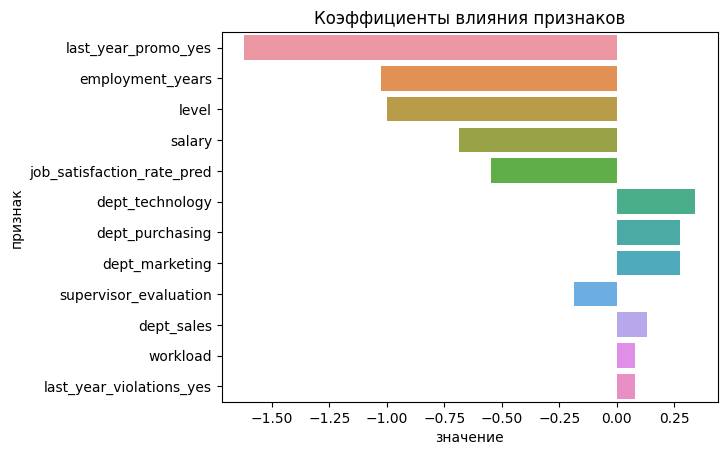

In [111]:
# обучаем модель на тренировочной выборке
final_pipe.fit(X_train_quit, y_train_quit)
# названия признаков
feature_names = final_pipe[:-1].get_feature_names_out()
# строим график важности признаков для модели
plot_feature_importance(final_pipe['model'].coef_[0], feature_names)
plt.title('Коэффициенты влияния признаков');

Наиболее значимый для модели признак — `last_year_promo_yes`, также большое значение оказывают признаки `employment_years`, `level`, `salary` и новый признак `job_satisfaction_rate_pred`. Это соответствует результатам анализа при составлении портрета уволившегося сотрудника. Характер влияния признаков тоже соответствует результатам проведённого анализа: отрицательные значения коэффициентов означают, что большее значение признака снижает вероятность увольнения сотрудника.

Попробуем улучшить модель путём подбора оптимальных значений гиперпараметров в сочетании с отбором входных признаков.
- Будем отбирать число наиболее значимых признаков в диапазоне от 4 до 12.
- Подберём тип регуляризации модели (L1 или L2) и её силу.

In [112]:
# словарь со списками параметров для перебора
param_grid = {
    'feature_selector__k': range(4, 13),
    'model__penalty': ['l2', 'l1'],
    'model__C': np.logspace(-3, 1, num=25),
}
# инициализируем класс для автоматизированного подбора параметров
search_logreg = GridSearchCV(
    final_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1 
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_logreg.fit(X_train_quit, y_train_quit)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 166.397 с


In [113]:
# лучшая метрика на кросс-валидации
mean_cv_score = search_logreg.best_score_
print(
    'ROC-AUC лучшей модели логистической регрессии '
    'на тренировочной выборке при кросс-валидации: '
    f'{mean_cv_score:.4f}'
)

ROC-AUC лучшей модели логистической регрессии на тренировочной выборке при кросс-валидации: 0.9035


In [114]:
# оптимальные гиперпараметры
search_logreg.best_params_

{'feature_selector__k': 8,
 'model__C': 1.467799267622069,
 'model__penalty': 'l1'}

Лучший результат показала модель с 8 входными признаками и ослабленной L1-регуляризацией (параметр C ≈ 1.468). 

Значение метрики на тренировочной выборке при кросс-валидации немного улучшилось по сравнению с базовой моделью: было 0.9024, стало 0.9035. При этом теперь модель позволяет получить лучший результат, используя меньшее количество входных признаков, что является дополнительным преимуществом. Но значение метрики по-прежнему оставляет желать лучшего.

Посмотрим, какие входные признаки использует лучшая модель. Для этого используем функцию `get_features_lists()`.

In [115]:
# выводим списки используемых и неиспользуемых признаков
get_features_lists(search_logreg.best_estimator_);

Используемые входные признаки: ['last_year_promo_yes', 'last_year_violations_yes', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']
Неиспользуемые входные признаки: ['dept_technology', 'dept_purchasing', 'dept_sales', 'dept_marketing']


Лучшая модель использует 8 входных признаков из 9 исходных, сильнее связанных с целевым, которые были определены на этапе анализа корреляций.

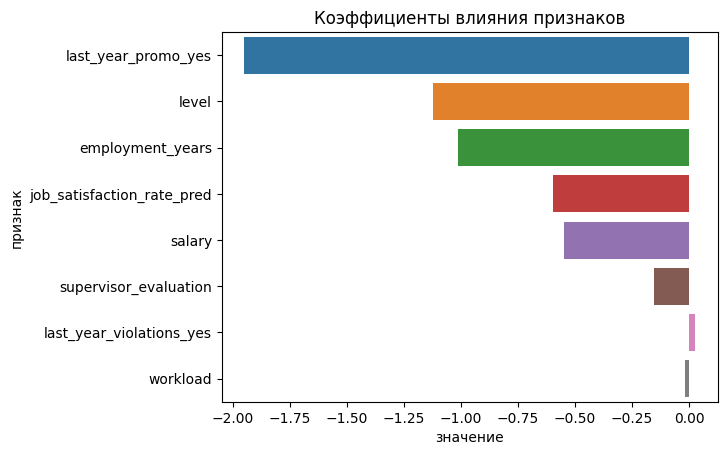

In [116]:
# пайплайн лучшей модели
best_pipe = search_logreg.best_estimator_
# названия признаков
feature_names = best_pipe[:-1].get_feature_names_out()
# строим график важности признаков для модели
plot_feature_importance(best_pipe['model'].coef_[0], feature_names)
plt.title('Коэффициенты влияния признаков');

Степень влияния признаков изменилась не принципиально: 5 самым значимых для модели признаков те же. Признак `last_year_promo_yes` остался самым значимым.

##### Модель k ближайших соседей

Обучим модель k ближайших соседей для задачи классификации —  `KNeighborsClassifier`.

In [117]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = KNeighborsClassifier(),
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate_pred'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', SelectKBest(k='all')),
                ('model', KNeighborsClassifier())])

Подберём оптимальное значение гиперпараметра модели — число ближайших соседей, а также количество значимых признаков для обучения модели, используя метод байесовской оптимизации, реализованный в `OptunaSearchCV`.

In [118]:
# словарь со списками параметров для перебора
param_optuna = {
    'feature_selector__k': distributions.IntDistribution(4, 12),
    'model__n_neighbors': distributions.IntDistribution(2, 100),
}
# инициализируем класс для автоматизированного подбора параметров
search_knn = OptunaSearchCV(
    final_pipe,
    param_optuna,
    cv=5,
    scoring='roc_auc',
    n_trials=100,
    random_state=RANDOM_STATE,
    verbose=-1
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_knn.fit(X_train_quit, y_train_quit)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 120.867 с


In [119]:
# лучшая метрика на кросс-валидации
mean_cv_score = search_knn.best_score_
print(
    'ROC-AUC лучшей модели k ближайших соседей '
    'на тренировочной выборке при кросс-валидации: '
    f'{mean_cv_score:.4f}'
)

ROC-AUC лучшей модели k ближайших соседей на тренировочной выборке при кросс-валидации: 0.9147


In [120]:
# оптимальные гиперпараметры
search_knn.best_params_

{'feature_selector__k': 8, 'model__n_neighbors': 65}

Лучшая модель `KNeighborsClassifier` учитывает 8 входных признаков и использует для предсказания класса его значения у 65 ближайших соседей.

Посмотрим, какие входные признаки использует модель.

In [121]:
# выводим списки используемых и неиспользуемых признаков
get_features_lists(search_knn.best_estimator_);

Используемые входные признаки: ['last_year_promo_yes', 'last_year_violations_yes', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']
Неиспользуемые входные признаки: ['dept_technology', 'dept_purchasing', 'dept_sales', 'dept_marketing']


Не используются моделью признаки, показавшие низкую связь с целевым при анализе корреляций. 

##### Дерево решений

Обучим модель дерева решений для задачи классификации — `DecisionTreeClassifier`.

In [122]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = DecisionTreeClassifier(
        class_weight='balanced',
        random_state=RANDOM_STATE,
    )
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate_pred'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', SelectKBest(k='all')),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

Подберём оптимальные значения гиперпараметров модели, а также количество значимых признаков для обучения модели.

У модели дерева решений несколько гиперпараметров, определяющих его структуру, среди них:
- `max_depth` — максимальная глубина дерева (по умолчанию не ограничена);
- `min_samples_split` — минимальное количество объектов в узле для его разделения (по умолчанию 2);
- `min_samples_leaf` — минимальное количество объектов в листе (по умолчанию 1).

Чтобы определиться с диапазоном значений глубины дерева, в котором будем искать оптимальное значение, надо узнать глубину обученного дерева, если не задано ограничение глубины.

In [123]:
# обучаем модель на тренировочной выборке
final_pipe.fit(X_train_quit, y_train_quit)
# глубина дерева решений
max_depth = final_pipe['model'].get_depth()
print(f'Глубина дерева решений, если не задано ограничение глубины: {max_depth = }')

Глубина дерева решений, если не задано ограничение глубины: max_depth = 25


Подбор оптимальной комбинации гиперпараметров методом полного перебора с использованием `GridSearchCV` занял бы много времени, а при случайном поиске с использованием `RandomizedSearchCV` есть риск пропустить хорошую комбинацию. Поэтому используем поиск с помощью метода байесовской оптимизации, реализованный в `OptunaSearchCV`.

In [124]:
# словарь со списками параметров для перебора
param_optuna = {
    'feature_selector__k': distributions.IntDistribution(4, 12),
    'model__max_depth': distributions.IntDistribution(1, max_depth),
    'model__min_samples_split': distributions.IntDistribution(2, 20),
    'model__min_samples_leaf': distributions.IntDistribution(1, 20),
}
# инициализируем класс для автоматизированного подбора параметров
search_tree = OptunaSearchCV(
    final_pipe,
    param_optuna,
    cv=5,
    scoring='roc_auc',
    n_trials=200,
    random_state=RANDOM_STATE,
    verbose=-1
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_tree.fit(X_train_quit, y_train_quit)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 195.858 с


In [125]:
# лучшая метрика на кросс-валидации
mean_cv_score = search_tree.best_score_
print(
    'ROC-AUC лучшей модели дерева решений '
    'на тренировочной выборке при кросс-валидации: '
    f'{mean_cv_score:.4f}'
)

ROC-AUC лучшей модели дерева решений на тренировочной выборке при кросс-валидации: 0.9095


In [126]:
# оптимальные гиперпараметры
search_tree.best_params_

{'feature_selector__k': 11,
 'model__max_depth': 18,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 18}

Лучшая модель — дерево решений с глубиной 11, минимальным количеством объектов в листе, равным 18, и минимальным количеством объектов в узле для его разделения, равным 5. Последний параметр фактически не важен, т.к. получился меньше минимального количества объектов в листе.

Лучшая модель дерева решений использует 11 входных признаков. Посмотрим, какие.

In [127]:
# выводим списки используемых и неиспользуемых признаков
get_features_lists(search_tree.best_estimator_);

Используемые входные признаки: ['dept_marketing', 'dept_purchasing', 'dept_sales', 'last_year_promo_yes', 'last_year_violations_yes', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']
Неиспользуемые входные признаки: ['dept_technology']


Немного странно, но лучшее дерево решений не использует только признак `dept_technology`.

##### Модель опорных векторов

Обучим модель метода опорных векторов (SVM) для задачи классификации — `SVC`.

In [128]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = SVC(
        probability=True, 
        class_weight='balanced',
        random_state=RANDOM_STATE,
    )
)
final_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate_pred'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', SelectKBest(k='all')),
                ('model',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

Подберём оптимальное значение одного из гиперпараметров модели — силы регуляризации (параметр `C`), а также количество значимых признаков для обучения модели, используя метод байесовской оптимизации, реализованный в `OptunaSearchCV`.

In [129]:
# словарь со списками параметров для перебора
param_optuna = {
    'feature_selector__k': distributions.IntDistribution(4, 12),
    'model__C': distributions.FloatDistribution(0.1, 10, log=True),
}
# инициализируем класс для автоматизированного подбора параметров
search_svc = OptunaSearchCV(
    final_pipe,
    param_optuna,
    cv=5,
    scoring='roc_auc',
    n_trials=100,
    random_state=RANDOM_STATE,
    verbose=-1
)
# запускаем таймер
start = time()
# запускаем подбор параметров 
search_svc.fit(X_train_quit, y_train_quit)
# считаем, сколько секунд прошло с начала запуска
search_time = time() - start
print(f'Время поиска {search_time:.3f} с')

Время поиска 1302.289 с


In [130]:
# лучшая метрика на кросс-валидации
mean_cv_score = search_svc.best_score_
print(
    'ROC-AUC лучшей модели SVC '
    'на тренировочной выборке при кросс-валидации: '
    f'{mean_cv_score:.4f}'
)

ROC-AUC лучшей модели SVC на тренировочной выборке при кросс-валидации: 0.9061


In [131]:
# оптимальные гиперпараметры
search_svc.best_params_

{'feature_selector__k': 8, 'model__C': 0.4645040041785535}

Лучшая модель SVC использует 8 входных признаков и имеет усиленную регуляризацию (параметр C ≈ 0.4645).

Посмотрим, какие входные признаки использует модель.

In [132]:
# выводим списки используемых и неиспользуемых признаков
get_features_lists(search_svc.best_estimator_);

Используемые входные признаки: ['last_year_promo_yes', 'last_year_violations_yes', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']
Неиспользуемые входные признаки: ['dept_technology', 'dept_purchasing', 'dept_sales', 'dept_marketing']


Модель тоже не использует только данные об отделе, в котором работает сотрудник. Это естественно, т.к. данный признак показал отсутствие связи с целевым при анализе корреляций.

#### Выбор лучшей модели

Лучшие значения метрики ROC-AUC на тренировочной выборке при кросс-валидации для моделей четырёх разных классов приведены в таблице.

In [133]:
# метрики лучших моделей каждого класса
pd.DataFrame({
    'модель': ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'SVC'],
    'ROC-AUC': [search.best_score_ for search in (search_logreg, search_knn, search_tree, search_svc)]
}).sort_values('ROC-AUC', ascending=False).reset_index(drop=True).round(4)

модель  ROC-AUC
0    KNeighborsClassifier   0.9147
1  DecisionTreeClassifier   0.9095
2                     SVC   0.9061
3      LogisticRegression   0.9035

- Наибольшее, а значит наилучшее, значение метрики у модели k ближайших соседей.
- Модель логистической регрессии показала худший результат. И в этой задаче линейная модель не выдерживает конкуренции.

Таким образом, **лучшая модель** — это модель k ближайших соседей `KNeighborsClassifier`, которая учитывает 8 входных признаков (все исходные признаки, кроме `dept`) и использует для предсказания класса его значения у 65 ближайших соседей.

Оценим качество лучшей модели на тестовой выборке.

In [134]:
# пайплайн лучшей модели k ближайших соседей
best_pipe_knn = search_knn.best_estimator_
# получаем предсказания вероятности принадлежности к старшему классу
y_prоba_quit = best_pipe_knn.predict_proba(X_test)[:, 1]
# считаем метрику на тестовой выборке
print(f'ROC-AUC лучшей модели k ближайших соседей на тестовой выборке: '
      f'{roc_auc_score(y_test_quit, y_prоba_quit):.4f}')

ROC-AUC лучшей модели k ближайших соседей на тестовой выборке: 0.9167


Значение метрики ROC-AUC лучшей модели (k ближайших соседей) на тестовой выборке удовлетворяет критерию успеха: ROC-AUC = 0.9167 ≥ 0.91.

#### Анализ лучшей модели

##### Проверка на адекватность

Для проверки лучшей модели на адекватность сравним её с дамми-моделью `DummyClassifier`, которая для любого объекта предсказывает вероятности принадлежности к классам, равные их доле в тренировочной выборке.

Лучшую модель можно считать адекватной, если качество её предсказаний на тестовой выборке лучше, чем у дамми-модели.

In [135]:
# изменяем тип модели в пайплайне
final_pipe.set_params(
    model = DummyClassifier()
)
display(final_pipe)
# обучаем модель на тренировочной выборке
final_pipe.fit(X_train_quit, y_train_quit)
# получаем предсказания вероятности принадлежности к старшему классу
y_prоba_quit = final_pipe.predict_proba(X_test)[:, 1]
# считаем метрику на тестовой выборке
dummy_model_test_score = roc_auc_score(y_test_quit, y_prоba_quit)
print(f'ROC-AUC дамми-модели на тестовой выборке: {dummy_model_test_score:.4f}')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='most_...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate_pred'])],
                                   verbose_feature_names_out=False)),
                ('feature_selector', SelectKBest(k='all')),
                ('model', DummyClassifier())])

ROC-AUC дамми-модели на тестовой выборке: 0.5000


Дамми-модель на тестовой выборке показала такое же качество, как и случайное угадывание (ROC-AUC = 0.5), что намного хуже, чем у лучшей модели k ближайших соседей (ROC-AUC = 0.9167). Значит, выбранная лучшая модель адекватно предсказывает значения целевого признака `quit` — увольнение сотрудника из компании.

##### Анализ ошибок

Посмотрим на матрицу ошибок лучшей модели на тестовой выборке. Для этого используем функцию `plot_confusion_matrix()`.

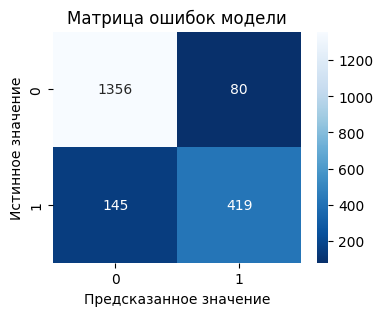

In [136]:
# получаем предсказания меток классов
y_pred_quit = best_pipe_knn.predict(X_test)
# строим матрицу ошибок модели
plot_confusion_matrix(y_test_quit, y_pred_quit)

Рассчитаем метрики матрицы ошибок:
- **Accuracy** — это доля правильных предсказаний модели. В ситуации дисбаланса классов она неадекватно отражает качество модели, поэтому лучше её не использовать. В имеющихся данных среди сотрудников уволившихся меньше 30%, что означает дисбаланс классов.
- **Precision** — это доля верно классифицированных объектов класса 1 от всех объектов, которые модель отнесла к классу 1. В данной задаче это доля уволившихся сотрудников среди тех, для которых модель предсказала увольнение.
- **Recall** (TPR) — это доля верно классифицированных объектов класса 1 от всех объектов, принадлежащих к классу 1. В данной задаче это доля сотрудников, для которых модель предсказала увольнение, среди уволившихся сотрудников.
- **Specificity** — это доля верно классифицированных объектов класса 0. В данной задаче это доля сотрудников, для которых модель предсказала, что они не уволятся, среди не уволившихся сотрудников.

In [137]:
# считаем метрики
accuracy = accuracy_score(y_test_quit, y_pred_quit)
precision = precision_score(y_test_quit, y_pred_quit)
recall = recall_score(y_test_quit, y_pred_quit)
specificity = recall_score(y_test_quit, y_pred_quit, pos_label=0)

# объединяем значения в DataFrame
scores = pd.DataFrame(
    {'значение': [accuracy, precision, recall, specificity]}, 
    index=['Accuracy', 'Precision', 'Recall', 'Specificity']
)
scores.round(4)

значение
Accuracy       0.8875
Precision      0.8397
Recall         0.7429
Specificity    0.9443

Анализ метрик лучшей модели показывает:
- В целом модель даёт верные предсказания в ≈89% случаев. Но поскольку в имеющихся данных имеется дисбаланс классов (доля уволившихся сотрудников составляет меньше 30%), то эту метрику лучше не использовать, т.к. она неадекватно отражает качество модели. 
- Из сотрудников, для которых модель предсказала увольнение, фактически уволились 84% (метрика Precision). Это означает, что в 16% случаев модель ошибочно предсказала увольнение, хотя сотрудник не уволился.
- Модель верно предсказала увольнение для 74% уволившихся сотрудников (метрика Recall). Соответственно, в 26% случаев модель не смогла предсказать произошедшее увольнение сотрудника.
- Модель верно предсказала, что сотрудник не уволится, для 94.4% не уволившихся сотрудников (метрика Specificity). Получается, что модель ошибочно считает сотрудника склонным к увольнению всего в 5.6% случаев.

Таким образом, при значении порога классификации по умолчанию (0.5) модель лучше предсказывает то, что сотрудник не уволится. Однако для предотвращения оттока сотрудников лучше посчитать склонным к увольнению сотрудника, который не собирается увольняться, чем пропустить непредвиденное увольнение, поэтому в данной задаче более высокое значение метрики Recall важнее, чем Precision. Требуемое соотношение Precision/Recall можно настроить подбором порога классификации. Оптимальный порог можно подобрать по графику ROC-кривой: он соответствует точке перелома, где TPR достигает наибольшего значения при низком FPR.

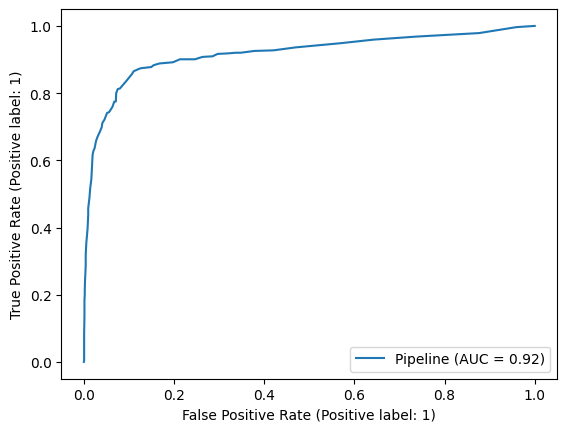

In [138]:
# ROC-кривая
RocCurveDisplay.from_estimator(best_pipe_knn, X_test, y_test_quit);

##### Оценка важности признаков

Посмотрим, какие признаки наиболее важны для лучшей модели. Оценим значимость признаков для модели методами "permutation importance" и SHAP. Метод SHAP также позволяет оценить влияние значений признаков на предсказания модели.

Подготовим данные для оценки важности признаков:
- Возьмём из пайплайна лучшей модели трансформер для подготовки данных и преобразуем с его помощью тренировочную и тестовую выборки, добавив в них названия входных признаков.
- Повторно обучим лучшую модель на тренировочной выборке.

In [139]:
# лучшая модель
best_model_knn = best_pipe_knn['model']
# трансформер для подготовки данных из пайплайна лучшей модели
best_transformer = best_pipe_knn[:-1]

# преобразуем тренировочную выборку
X_train_transformed = best_transformer.fit_transform(X_train_quit, y_train_quit)
# получаем из трансформера названия признаков
feature_names_out = best_transformer.get_feature_names_out()
# добавляем в тренировочную выборку названия признаков
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names_out)

# преобразуем тестовую выборку
X_test_transformed = best_transformer.transform(X_test)
# добавляем в тестовую выборку названия признаков
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_out)

# повторно обучаем модель на тренировочной выборке
best_model_knn.fit(X_train_transformed, y_train_quit);

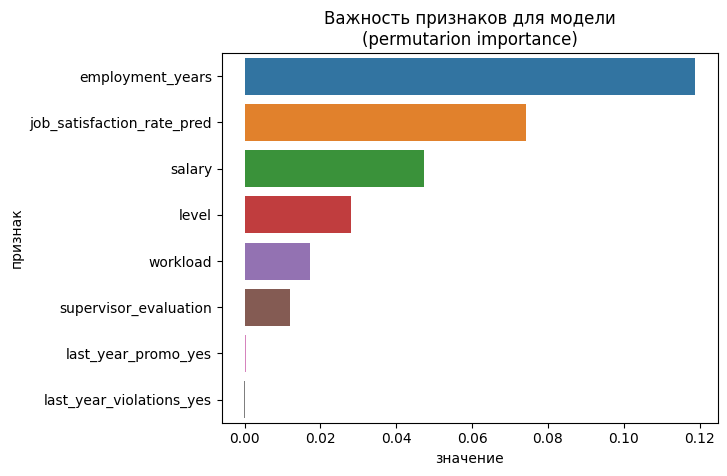

In [140]:
# определяем важность признаков для модели
permutation = permutation_importance(
    best_model_knn, 
    X_test_transformed, 
    y_test_quit, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_repeats=10,
    n_jobs=-1,
)

# строим график важности признаков для модели
plot_feature_importance(permutation['importances_mean'], best_model_knn.feature_names_in_)
plt.title('Важность признаков для модели\n(permutarion importance)');

In [141]:
# инициализируем объект shap.Explainer
shap_explainer = shap.Explainer(best_model_knn.predict, X_train_transformed, seed=RANDOM_STATE)
# вычисляем значения Шепли для части тестовой выборки
shap_values = shap_explainer(X_test_transformed.sample(100, random_state=RANDOM_STATE))

ExactExplainer explainer: 101it [14:41,  8.82s/it]                         


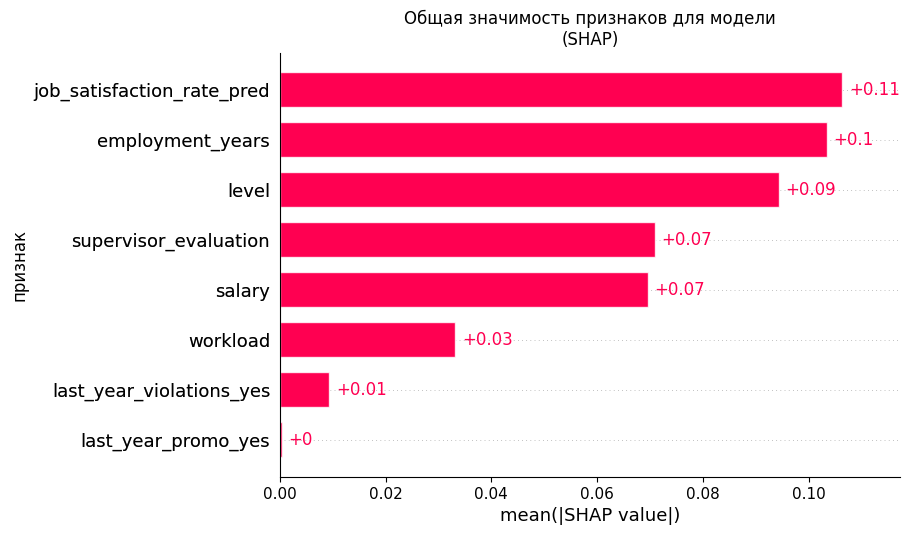

In [142]:
# строим график общей значимости признаков
shap.plots.bar(shap_values, max_display=12, show=False) 
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Общая значимость признаков для модели\n(SHAP)');

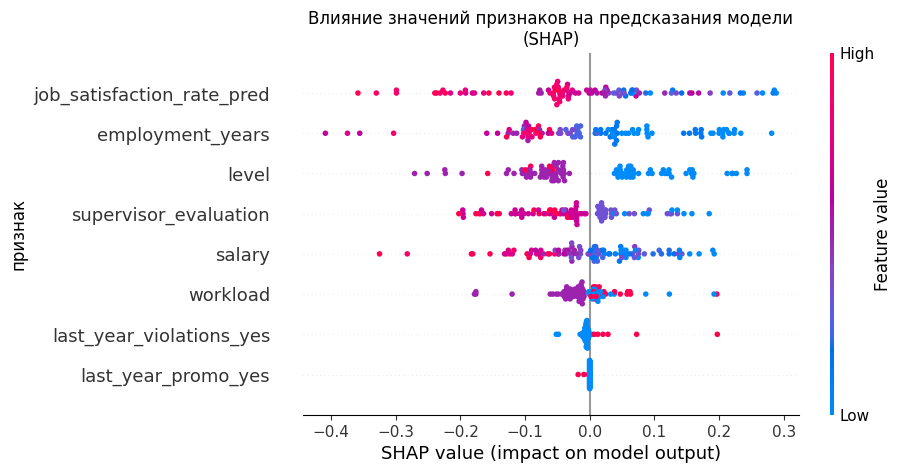

In [143]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака для каждого объекта
shap.plots.beeswarm(shap_values, max_display=12, show=False)
# оформляем график
plt.ylabel('признак', fontsize='large')
plt.title('Влияние значений признаков на предсказания модели\n(SHAP)');

Несмотря на некоторые различия в результатах оценки важности признаков двумя методами, из них можно выделить общее:
- Признак `job_satisfaction_rate_pred` — самый значимый или один из двух наиболее значимых. Это означает, что для предсказания увольнений очень важно следить за удовлетворённостью сотрудников работой.
- Признаки `level` (уровень занимаемой должности), `employment_years` (длительность работы в компании), `salary` (зарплата) и `supervisor_evaluation` (оценка руководителем) тоже значимы для модели. Это было обнаружено ещё при составлении портрета уволившегося сотрудника: увольняются преимущественно junior-ы, не проработавшие и 3-х лет, с невысоким уровнем зарплаты и меньшей оценкой качества работы.
- Признаки `workload` (уровень загруженности)) имеет среднюю значимость.
- Признаки `last_year_violations_yes` (наличие нарушений трудового договора сотрудником) и `last_year_promo_yes` (повышение за последний год) малозначимы для модели.
- Признаки, указывающие на отдел, в котором работает сотрудник, т.е. исходный признак `dept`, были отсеяны при отборе признаков на этапе обучения модели для максимизации метрики, поэтому они тоже малозначимы.

#### Выводы

1. Обучены четыре модели классификации:
    - логистическая регрессия `LogisticRegression`;
    - модель k ближайших соседей `KNeighborsClassifier`
    - дерево решений `DecisionTreeClassifier`;
    - модель метода опорных векторов `SVC`.

2. Для всех моделей подобраны оптимальные значения гиперпараметров, а также количество значимых признаков для обучения модели, обеспечивающие максимальное значение метрики ROC-AUC.

3. Из трёх рассмотренных ML моделей наилучшее качество на тренировочной выборке при кросс-валидации показала модель k ближайших соседей с гиперпараметром `n_neighbors =  65`, обученная на данных без признака `dept` (отдел). Значение метрики ROC-AUC лучшей модели k ближайших соседей на тестовой выборке удовлетворяет критерию успеха: ROC-AUC = 0.9167 ≥ 0.91.

4. Проверка лучшей модели на адекватность показала, что модель хорошо справляется с задачей предсказания увольнений: качество её предсказаний намного лучше, чем у дамми-модели, которая для любого объекта предсказывает вероятности принадлежности к классам, равные их доле в тренировочной выборке.

5. Анализ ошибок лучшей модели показал, что с порогом классификации по умолчанию (0.5) модель лучше предсказывает то, что сотрудник не уволится: модель ошибочно считает сотрудника склонным к увольнению всего в 5.6% случаев, в то время как в 16% случаев модель ошибочно предсказала увольнение, хотя сотрудник не уволился, а в 26% случаев модель не смогла предсказать произошедшее увольнение сотрудника. Для предотвращения оттока сотрудников лучше посчитать склонным к увольнению сотрудника, который не собирается увольняться, чем пропустить непредвиденное увольнение, поэтому в данной задаче более высокое значение метрики Recall важнее, чем Precision. Требуемое соотношение Precision/Recall можно настроить подбором порога классификации.

6. Анализ важности признаков для лучшей модели показал высокую значимость уровня удовлетворённости сотрудника работой при прогнозировании увольнений, а также подтвердил выводы о влиянии признаков, полученные при составлении портрета уволившегося сотрудника.

### Выводы по задаче предсказания увольнения сотрудника из компании

1. Лучшая модель для задачи предсказания увольнения сотрудника из компании — это модель k ближайших соседей с гиперпараметром `n_neighbors =  65`, обученная на данных без признака `dept` (отдел).     
    - Значение метрики ROC-AUC лучшей модели k ближайших соседей на тестовой выборке удовлетворяет критерию успеха: ROC-AUC = 0.9167 ≥ 0.91.
    - Модель не переобучилась: значения метрики на тренировочной выборке при кросс-валидации и на тестовой выборке близки.
    - Модель адекватна задаче и обеспечивает приемлемый баланс ошибок первого (False Positive) и второго рода (False Negative): Precision = 0.84, Recall = 0.74.
   
2. Модель дерева решений показала неплохое значение метрики ROC-AUC на тренировочной выборке при кросс-валидации, и в принципе благодаря наличию у неё большого количества настраиваемых гиперпараметров имеет потенциал для оптимизации. За счёт своей структуры из узлов с условиями дерево решений обладает лучшей интерпретируемостью, поэтому его используют там, где важно чётко понимать, почему получился такой прогноз целевого признака. Хотя для любой модели влияние каждого признака на результат конкретного предсказания можно проанализировать с помощью метода SHAP.

3. Модель SVC показала среднее качество. К тому же применять её там, где важно оперировать с вероятностью принадлежности к классу, не рекомендуется, т.к. между значениями вероятности и прогнозами класса может быть несоответствие.

4. Модель логистической регрессии показала самый низкий результат из рассмотренных моделей. Это естественно, потому что линейная модель не может так же эффективно учитывать сложные нелинейные зависимости в данных.

## Общий вывод

1. В проекте были поставлена **задача** смоделировать уровень удовлетворённости и предсказать факт увольнения на основе характеристик сотрудников компании. Для этого нужно разработать две прогнозные модели:
    - Модель, которая сможет предсказать уровень удовлетворённости сотрудника.
    - Модель, которая сможет предсказать то, что сотрудник уволится из компании. 

   При этом вторая модель может использовать прогноз первой в качестве дополнительного входного признака.

   Таким образом, задача разбивается на две:
    - Первая задача — предсказание уровня удовлетворённости сотрудника. Уровень удовлетворённости — это непрерывный количественный признак, который выражается дробным числом от 0 до 1. Таким образом, это задача регрессии.
    - Вторая задача — предсказание увольнения сотрудника из компании. Факт увольнения — это бинарный признак. Таким образом, это задача бинарной классификации.
    
2. Краткий обзор **исходных данных**:
    - Исходные данные представлены в 5 датасетах:
        - тренировочная выборка первой задачи,
        - тренировочная выборка второй задачи,
        - входные признаки общей тестовой выборки,
        - целевой признак тестовой выборки первой задачи,
        - целевой признак тестовой выборки второй задачи.
    - Тренировочные выборки содержат по 4000 записей, тестовая — 2000. 
    - Во всех датасетах ключом является уникальный идентификатор сотрудника. 
    - В тренировочной и тестовой выборках имеются пропущенные значения входных признаков.

3. В результате **предобработки данных**:
    - Исправлены опечатки в текстовых значениях.
    - Неявные пропуски заменены на явные (`NaN`).
    - Выполнена проверка на дубликаты и корректность данных.
    - Проверена корректность разделения данных на выборки.

4. В результате **исследовательского анализа данных**:
    - На этапе статистического анализа признаков установлено:
        - Обе тренировочных и тестовая выборки — стратифицированные по всем признакам, включая целевые. 
        - Аномалии и выбросы в данных отсутствуют.
        - В данных для второй задачи имеется дисбаланс данных по целевому признаку, однако степень дисбаланса умеренная и данных минорного класса должно быть достаточно для обучения моделей.
    
    - На этапе корреляционного анализа признаков: 
        - Установлено, что мультиколлинеарность между входными признаками отсутствует.
        - Для каждой задачи выполнена оценка степени связи входных признаков с целевым.
        - Установлено, что между тренировочной и тестовой выборками нет существенных различий в корреляциях признаков. Поэтому оценка качества ML модели, полученная на тестовой выборке, будет корректной.
        
    - Определены подходящие способы кодирования и масштабирования данных при их подготовке для обучения ML моделей.
    
    - Составлен характерный **портрет уволившегося сотрудника**:
      > Это начинающий сотрудник уровня junior, проработавший в компании не более 3 лет, который был слабо загружен работой и получал небольшую зарплату ниже среднего уровня. Качество его работы оставляло желать лучшего, а вероятность нарушений трудового договора с его стороны выше средней.

      Таким образом, отмечены признаки, влияющие на увольнение сотрудника из компании.

    - Подтверждено предположение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Статистический тест показал, что среднее значение уровня удовлетворённости работой для уволившихся сотрудников статистически значимо меньше, чем у оставшихся. 
    
      Таким образом, можно использовать результат прогноза модели, предсказывающей уровень удовлетворённости сотрудника, в качестве дополнительного входного признака для предсказания увольнения сотрудника из компании.
    
5. Данные подготовлены для обучения на них ML моделей:
    - Входные признаки и целевой признак тренировочной выборки выделены в отдельные переменные.
    - Входные признаки разделены на наборы для кодирования и масштабирования в соотвествии с выводами о подходящем для каждого признака типе кодировщика и скейлера.
    - Построен пайплайн для подготовки данных и обучения ML моделей, включающий этапы заполнения пропусков, кодирования и масштабирования входных признаков, отбора входных признаков по их значимости на основе статистических тестов, обучения модели.
    
6. Решена первая задача — разработана модель для **предсказания уровня удовлетворённости сотрудника**.
    - Для решения задачи обучены три регрессионные модели:
        - Линейная регрессия `LinearRegression`. Линейная модель не справляется с задачей, потому что не может подстроиться под нелинейную зависимость целевого признака от входных.
        - Дерево решений `DecisionTreeRegressor`. Даже с оптимальными значениями гиперпараметров показала среднее качество на тренировочной выборке при кросс-валидации. Возможная причина такого результата в том, что модель слишком высоко оценивает важность одного признака — оценки качества работы сотрудника руководителем.
        - Модель метода опорных векторов `SVR` с нелинейным ядром RBF. Показала наилучший результат. 
    - Выбрана **лучшая модель** с минимальной метрикой SMAPE на тренировочной выборке при кросс-валидации — модель метода опорных векторов `SVR` с ядром RBF и значением параметра регуляризации `C ≈ 3.789`. 
    
    - Проверено качество лучшей модели на тестовой выборке. Значение метрики SMAPE лучшей модели SVR на тестовой выборке удовлетворяет критерию успеха: SMAPE = 13.61 ≤ 15.
    
    - Анализ предсказаний лучшей модели на тестовой выборке показал:
        - Лучшая модель адекватна задаче и обеспечивает стабильную и в среднем равномерную точность предсказаний, а также допускает мало значительных ошибок.
        - Предсказания лучшей модели в определённых узких интервалах значения целевого признака могут быть неустойчивыми по причине слишком грубой дискретности одного из наиболее значимых признаков для модели — оценки качества работы сотрудника руководителем. 
        - В редких случаях предсказанные значения уровня удовлетворённости сотрудника могут выходить за пределы диапазона $[0, 1]$, поэтому предсказания модели нужно корректировать, приводя выходящие за пределы диапазона значения к его границам.
        
    - Анализ важности признаков для лучшей модели показал:
        - Наиболее значимые для модели признаки: зарплата, оценка качества работы сотрудника руководителем, уровень занимаемой должности и уровень загруженности.
        - Сотрудники с высоким уровнем занимаемой должности менее удовлетворены своей работой, возможно, по причине высокой загруженности. 
        
7. Решена вторая задача — разработана модель для **предсказания увольнения сотрудника из компании**.
    - На основании установленного влияния уровня удовлетворённости сотрудника работой в компании на факт увольнения к входным признакам тренировочной и тестовой выборки второй задачи добавлены предсказанные значения уровня удовлетворённости сотрудника, полученные с помощью лучшей модели из первой задачи.
    - Для решения задачи обучены четыре модели классификации:
        - Логистическая регрессия `LogisticRegression`. Показала самый низкий результат из рассмотренных моделей. Это естественно, потому что линейная модель не может так же эффективно учитывать сложные нелинейные зависимости в данных.
        - Модель метода опорных векторов `SVC`. Показала среднее качество. К тому же применять её там, где важно оперировать с вероятностью принадлежности к классу, не рекомендуется, т.к. между значениями вероятности и прогнозами класса может быть несоответствие.
        - Дерево решений `DecisionTreeClassifier`. Заняла второе место по значению метрики ROC-AUC на тренировочной выборке при кросс-валидации. Благодаря наличию у неё большого количества настраиваемых гиперпараметров имеет потенциал для оптимизации, а за счёт своей структуры из узлов с условиями дерево решений обладает хорошей интерпретируемостью.
        - Модель k ближайших соседей `KNeighborsClassifier`. Показала самое высокое значение метрики ROC-AUC на тренировочной выборке при кросс-валидации.
       
    - Выбрана **лучшая модель** с максимальной метрикой ROC-AUC на тренировочной выборке при кросс-валидации — модель k ближайших соседей с гиперпараметром `n_neighbors =  65`, обученная на данных без признака `dept` (отдел). 
    - Проверено качество лучшей модели на тестовой выборке. Значение метрики ROC-AUC лучшей модели дерева решений на тестовой выборке удовлетворяет критерию успеха: ROC-AUC = 0.9167 ≥ 0.91.
        - Модель не переобучилась: значения метрики на тренировочной выборке при кросс-валидации и на тестовой выборке близки.
        - Модель адекватна задаче: качество её предсказаний намного выше случайного угадывания.
    - Анализ ошибок лучшей модели показал, что с порогом по умолчанию (0.5) модель обеспечивает приемлемый баланс ошибок первого (False Positive) и второго рода (False Negative): Precision = 0.84, Recall = 0.74.
        - Модель лучше предсказывает то, что сотрудник не уволится: модель ошибочно считает сотрудника склонным к увольнению всего в 5.6% случаев, в то время как в 16% случаев модель ошибочно предсказала увольнение, хотя сотрудник не уволился, а в 26% случаев модель не смогла предсказать произошедшее увольнение сотрудника.
        - Для предотвращения оттока сотрудников лучше посчитать склонным к увольнению сотрудника, который не собирается увольняться, чем пропустить непредвиденное увольнение, поэтому в данной задаче более высокое значение метрики Recall важнее, чем Precision. Требуемое соотношение Precision/Recall можно настроить подбором порога классификации.

    - Анализ важности признаков для лучшей модели показал высокую значимость уровня удовлетворённости сотрудника работой при прогнозировании увольнений, а также подтвердил выводы о влиянии признаков, полученные при составлении портрета уволившегося сотрудника.


**Выводы для бизнеса**:

- Составленный портрет уволившегося сотрудника позволяет утверждать, что из компании в основном увольнялись начинающие сотрудники, которые либо не справлялись с работой и потеряли к ней интерес, либо их не устроил уровень зарплаты.

- Анализ влияния признаков на уровень удовлетворённости сотрудника показал, что сотрудники с высоким уровнем занимаемой должности менее удовлетворены своей работой в компании, что связано с их более высокой загруженностью, и что сотрудники технического отдела (`technology`) тоже менее удовлетворены своей работой в компании.


**Рекомендации заказчику**:

- Для предсказания и предотвращения внезапных увольнений важно регулярно контролировать удовлетворённость сотрудников работой. Низкий уровень удовлетворённости сотрудника работой — один из наиболее значимых факторов, которые указывают на потенциальное увольнение.

- Желательно принять меры для снижения загруженности сотрудников высокого уровня, т.к. они из-за высокой загруженности менее удовлетворены своей работой в компании.

- Необходимо усовершенствовать методику сбора исходных данных для прогнозирования уровня удовлетворённости сотрудника: следует увеличить число возможных градаций оценки качества работы сотрудника, которую даёт руководитель (например, использовать хотя бы 10-балльную шкалу).

- Чтобы снизить текучку кадров, нужно скорректировать кадровую политику в компании — более тщательно отбирать подходящих кандидатов на собеседованиях при приёме на работу в компанию, а также принять меры по стимулированию начинающих сотрудников (в том числе материальному).

- Для дальнейшего совершенствования модели предсказания увольнения сотрудника из компании необходимо определить оптимальное соотношение ложноположительных и ложноотрицательных прогнозов модели, исходя из принципа минимизации финансовых потерь для компании.